# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits! We will use the loss functions and models we built in the previous exercises.


The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
>* The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
>* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='../assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

In this notebook, we will be using the [MNIST Dataset](http://yann.lecun.com/exdb/mnist/), a dataset of handwritten digits. We can use the torch [Datasets API](https://pytorch.org/vision/stable/datasets.html) to load the whole dataset directly. The MNIST dataset is made of 28x28 grayscale images.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

100%|██████████| 9912422/9912422 [00:19<00:00, 512064.09it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 3593891.11it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:02<00:00, 573974.10it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



### Visualize the data

We visualize a single random example of the MNIST dataset. You can rerun this cell multiple times to see different logits.

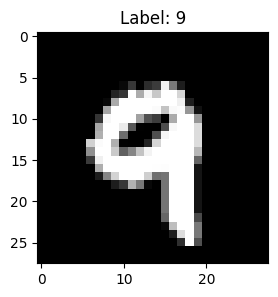

In [5]:
# obtain one batch of training images
rand_index = np.random.randint(0, len(train_data), 1)[0]
images = train_data[rand_index][0]
label = train_data[rand_index][1]
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator. In this exercise, we will be using the Generator and Discriminator we previously built.

## Discriminator

In [6]:
import torch.nn as nn

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size: int, hidden_dim: int):
        super(Discriminator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
        # define the final layer
        self.fc4 = nn.Linear(hidden_dim // 4, 1)        
        
        # define the dropout
        self.dropout = nn.Dropout(0.3)
        
        # define the activation
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # flatten image
        x = x.view(-1, 28*28)
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # we are using BCE with logits loss so the last activation is not required
        x = self.fc4(x)
        return x

## Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_size: int):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # define the activation
        self.activation = nn.LeakyReLU(0.2)
        self.final_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)

        x = self.fc2(x)
        x = self.activation(x)

        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        x = self.final_activation(x)
        return x

## Model hyperparameters

In [9]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of last hidden layer in the discriminator
d_hidden_size = 128

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [10]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (final_activation): Tanh()
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. For this exercise, we will use the loss functions we previously implemented. 

In [11]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [12]:
import torch.optim as optim

# Optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [13]:
from datetime import datetime
import pickle as pkl

In [14]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

2024-01-01 09:33:17 | Epoch [1/150] | Batch 0/469 | d_loss: 0.8618 | g_loss: 2.2344
2024-01-01 09:33:18 | Epoch [1/150] | Batch 100/469 | d_loss: 1.0219 | g_loss: 2.3180
2024-01-01 09:33:19 | Epoch [1/150] | Batch 200/469 | d_loss: 0.7946 | g_loss: 2.4739
2024-01-01 09:33:20 | Epoch [1/150] | Batch 300/469 | d_loss: 0.8905 | g_loss: 2.7974
2024-01-01 09:33:21 | Epoch [1/150] | Batch 400/469 | d_loss: 1.0745 | g_loss: 1.9458


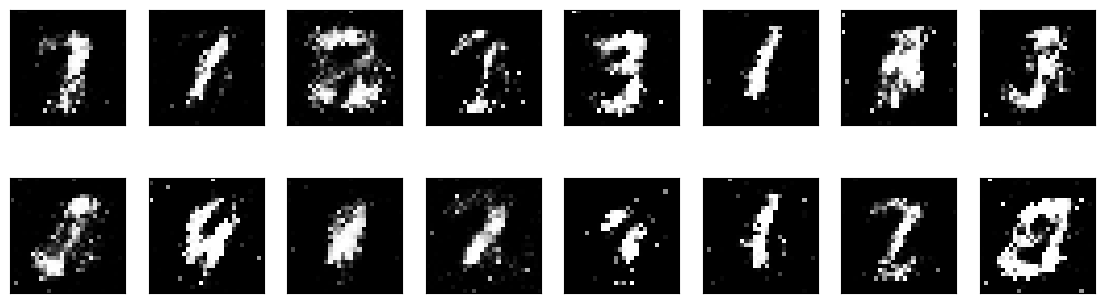

2024-01-01 09:33:25 | Epoch [2/150] | Batch 0/469 | d_loss: 0.9192 | g_loss: 2.2452
2024-01-01 09:33:26 | Epoch [2/150] | Batch 100/469 | d_loss: 0.7846 | g_loss: 2.5927
2024-01-01 09:33:28 | Epoch [2/150] | Batch 200/469 | d_loss: 0.7271 | g_loss: 2.5342
2024-01-01 09:33:29 | Epoch [2/150] | Batch 300/469 | d_loss: 0.8829 | g_loss: 2.5111
2024-01-01 09:33:31 | Epoch [2/150] | Batch 400/469 | d_loss: 0.7918 | g_loss: 2.8029


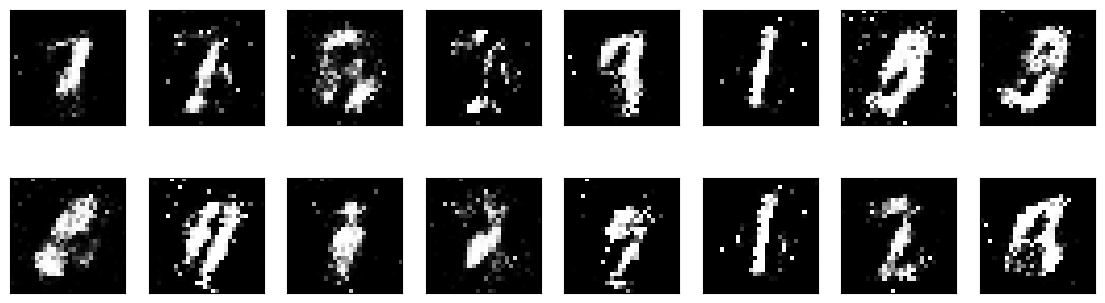

2024-01-01 09:33:34 | Epoch [3/150] | Batch 0/469 | d_loss: 0.7953 | g_loss: 2.1425
2024-01-01 09:33:36 | Epoch [3/150] | Batch 100/469 | d_loss: 0.8912 | g_loss: 2.1701
2024-01-01 09:33:37 | Epoch [3/150] | Batch 200/469 | d_loss: 0.9286 | g_loss: 1.9798
2024-01-01 09:33:39 | Epoch [3/150] | Batch 300/469 | d_loss: 0.8893 | g_loss: 2.5107
2024-01-01 09:33:40 | Epoch [3/150] | Batch 400/469 | d_loss: 0.9064 | g_loss: 2.8801


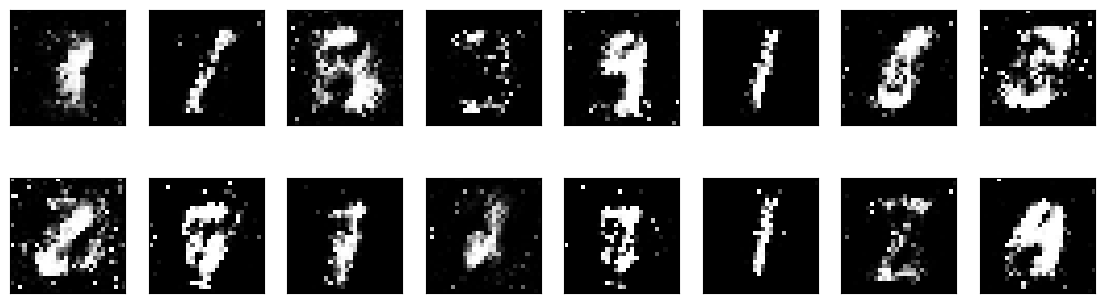

2024-01-01 09:33:44 | Epoch [4/150] | Batch 0/469 | d_loss: 0.8233 | g_loss: 2.4158
2024-01-01 09:33:46 | Epoch [4/150] | Batch 100/469 | d_loss: 0.9040 | g_loss: 2.4898
2024-01-01 09:33:47 | Epoch [4/150] | Batch 200/469 | d_loss: 0.7079 | g_loss: 2.6059
2024-01-01 09:33:49 | Epoch [4/150] | Batch 300/469 | d_loss: 0.8680 | g_loss: 2.4742
2024-01-01 09:33:50 | Epoch [4/150] | Batch 400/469 | d_loss: 0.8040 | g_loss: 2.4861


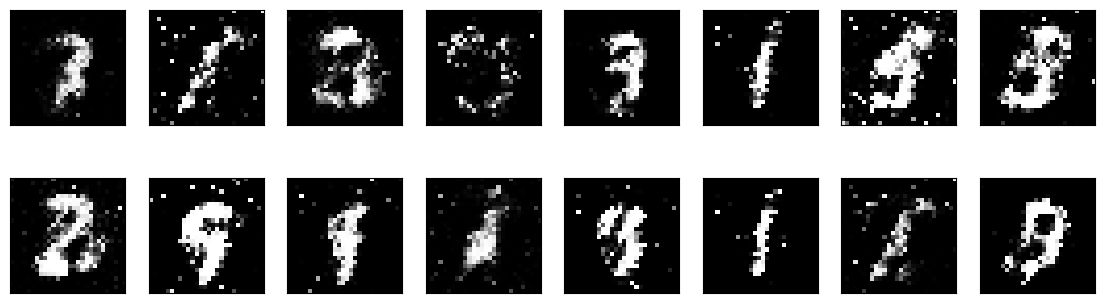

2024-01-01 09:33:54 | Epoch [5/150] | Batch 0/469 | d_loss: 0.7573 | g_loss: 2.5156
2024-01-01 09:33:55 | Epoch [5/150] | Batch 100/469 | d_loss: 0.8801 | g_loss: 2.2104
2024-01-01 09:33:56 | Epoch [5/150] | Batch 200/469 | d_loss: 0.7378 | g_loss: 2.5861
2024-01-01 09:33:58 | Epoch [5/150] | Batch 300/469 | d_loss: 0.8817 | g_loss: 2.3409
2024-01-01 09:33:59 | Epoch [5/150] | Batch 400/469 | d_loss: 0.8957 | g_loss: 2.1784


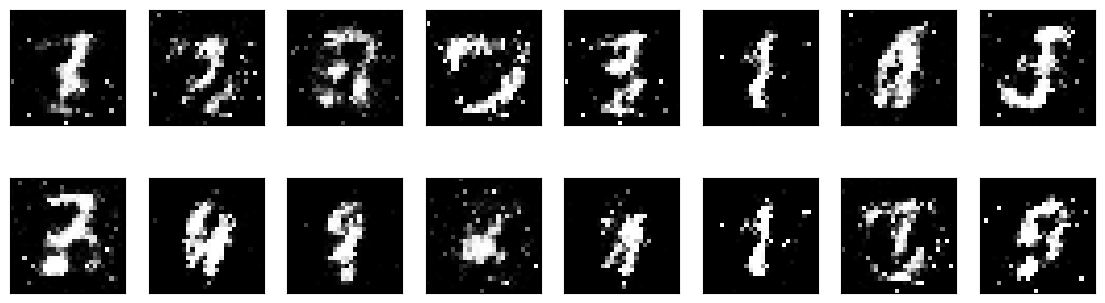

2024-01-01 09:34:03 | Epoch [6/150] | Batch 0/469 | d_loss: 0.8535 | g_loss: 1.8790
2024-01-01 09:34:04 | Epoch [6/150] | Batch 100/469 | d_loss: 0.9700 | g_loss: 2.1484
2024-01-01 09:34:06 | Epoch [6/150] | Batch 200/469 | d_loss: 0.7828 | g_loss: 2.4958
2024-01-01 09:34:07 | Epoch [6/150] | Batch 300/469 | d_loss: 0.9727 | g_loss: 2.1339
2024-01-01 09:34:09 | Epoch [6/150] | Batch 400/469 | d_loss: 0.8871 | g_loss: 2.2298


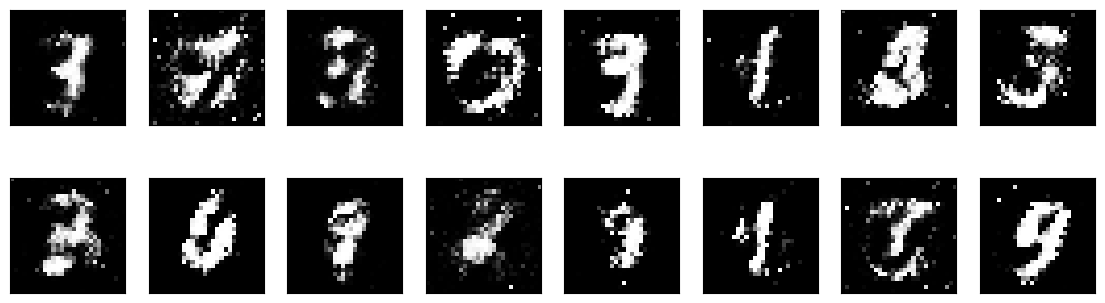

2024-01-01 09:34:13 | Epoch [7/150] | Batch 0/469 | d_loss: 0.9756 | g_loss: 1.8931
2024-01-01 09:34:14 | Epoch [7/150] | Batch 100/469 | d_loss: 0.7535 | g_loss: 1.9934
2024-01-01 09:34:15 | Epoch [7/150] | Batch 200/469 | d_loss: 0.9856 | g_loss: 2.2043
2024-01-01 09:34:17 | Epoch [7/150] | Batch 300/469 | d_loss: 0.8955 | g_loss: 2.2030
2024-01-01 09:34:18 | Epoch [7/150] | Batch 400/469 | d_loss: 0.8473 | g_loss: 1.7427


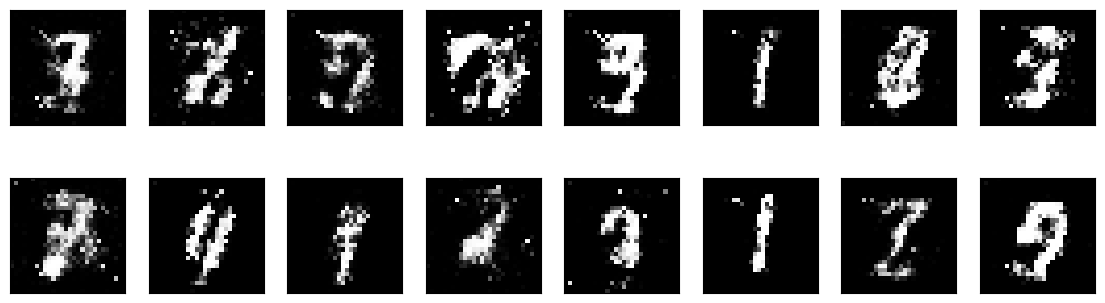

2024-01-01 09:34:22 | Epoch [8/150] | Batch 0/469 | d_loss: 0.9344 | g_loss: 2.1962
2024-01-01 09:34:24 | Epoch [8/150] | Batch 100/469 | d_loss: 0.8155 | g_loss: 2.1851
2024-01-01 09:34:25 | Epoch [8/150] | Batch 200/469 | d_loss: 0.9168 | g_loss: 1.8039
2024-01-01 09:34:27 | Epoch [8/150] | Batch 300/469 | d_loss: 0.9166 | g_loss: 2.1797
2024-01-01 09:34:28 | Epoch [8/150] | Batch 400/469 | d_loss: 0.8973 | g_loss: 2.4165


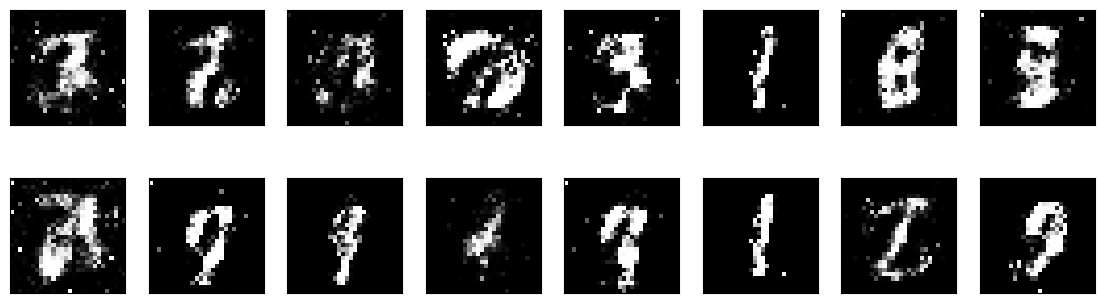

2024-01-01 09:34:32 | Epoch [9/150] | Batch 0/469 | d_loss: 0.8792 | g_loss: 1.9279
2024-01-01 09:34:33 | Epoch [9/150] | Batch 100/469 | d_loss: 0.8837 | g_loss: 2.4411
2024-01-01 09:34:35 | Epoch [9/150] | Batch 200/469 | d_loss: 0.9083 | g_loss: 2.1515
2024-01-01 09:34:36 | Epoch [9/150] | Batch 300/469 | d_loss: 0.8988 | g_loss: 2.1314
2024-01-01 09:34:38 | Epoch [9/150] | Batch 400/469 | d_loss: 0.8525 | g_loss: 1.9379


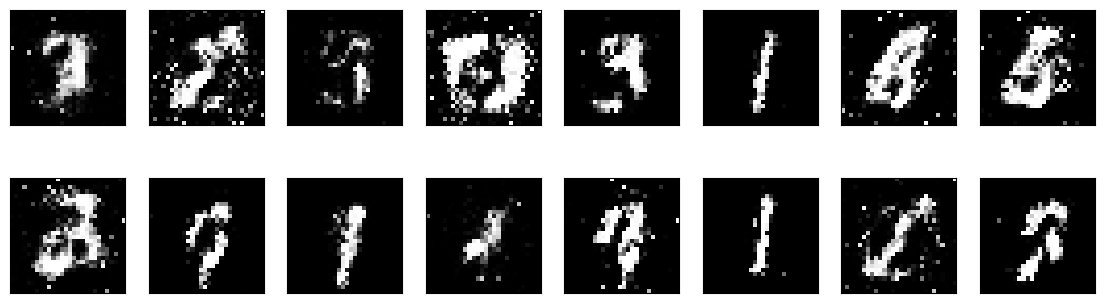

2024-01-01 09:34:41 | Epoch [10/150] | Batch 0/469 | d_loss: 0.8581 | g_loss: 2.2286
2024-01-01 09:34:43 | Epoch [10/150] | Batch 100/469 | d_loss: 0.8279 | g_loss: 1.9465
2024-01-01 09:34:44 | Epoch [10/150] | Batch 200/469 | d_loss: 0.8171 | g_loss: 2.2971
2024-01-01 09:34:46 | Epoch [10/150] | Batch 300/469 | d_loss: 0.9099 | g_loss: 2.1925
2024-01-01 09:34:47 | Epoch [10/150] | Batch 400/469 | d_loss: 0.8222 | g_loss: 2.1108


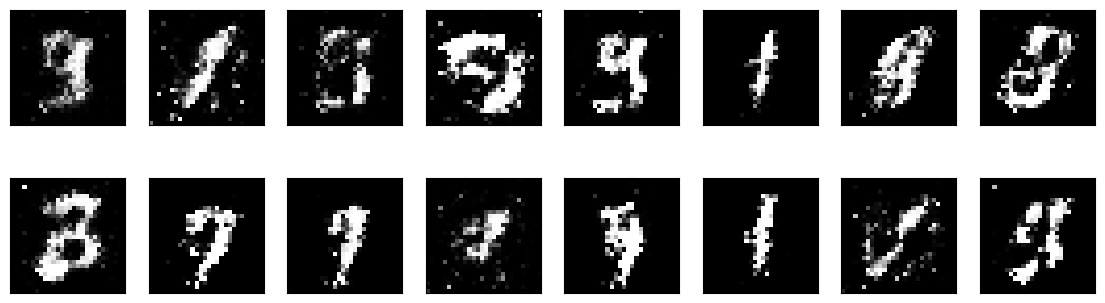

2024-01-01 09:34:51 | Epoch [11/150] | Batch 0/469 | d_loss: 0.8577 | g_loss: 2.0591
2024-01-01 09:34:52 | Epoch [11/150] | Batch 100/469 | d_loss: 0.9248 | g_loss: 1.8781
2024-01-01 09:34:54 | Epoch [11/150] | Batch 200/469 | d_loss: 0.9487 | g_loss: 1.8274
2024-01-01 09:34:55 | Epoch [11/150] | Batch 300/469 | d_loss: 1.0581 | g_loss: 2.2458
2024-01-01 09:34:57 | Epoch [11/150] | Batch 400/469 | d_loss: 0.8381 | g_loss: 1.9743


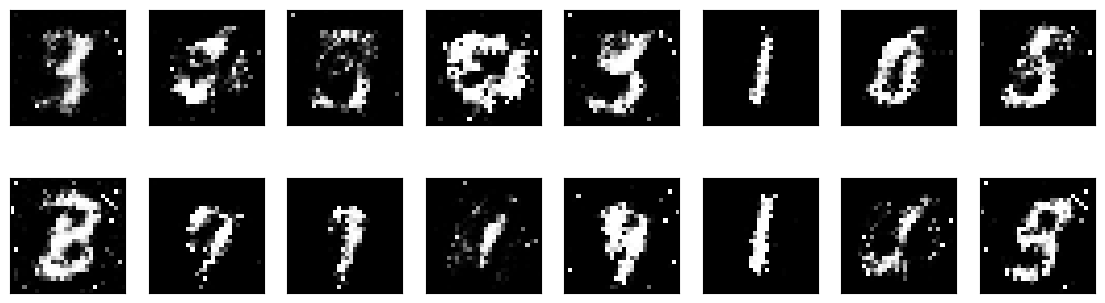

2024-01-01 09:35:01 | Epoch [12/150] | Batch 0/469 | d_loss: 0.8500 | g_loss: 2.1349
2024-01-01 09:35:02 | Epoch [12/150] | Batch 100/469 | d_loss: 0.8437 | g_loss: 2.0079
2024-01-01 09:35:03 | Epoch [12/150] | Batch 200/469 | d_loss: 0.8235 | g_loss: 2.3236
2024-01-01 09:35:05 | Epoch [12/150] | Batch 300/469 | d_loss: 1.1019 | g_loss: 2.0640
2024-01-01 09:35:06 | Epoch [12/150] | Batch 400/469 | d_loss: 0.8345 | g_loss: 2.3002


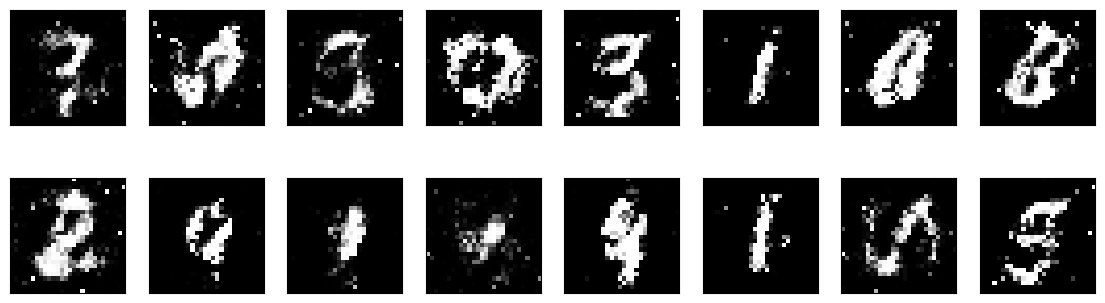

2024-01-01 09:35:10 | Epoch [13/150] | Batch 0/469 | d_loss: 0.8427 | g_loss: 1.9342
2024-01-01 09:35:12 | Epoch [13/150] | Batch 100/469 | d_loss: 0.9081 | g_loss: 2.1729
2024-01-01 09:35:13 | Epoch [13/150] | Batch 200/469 | d_loss: 0.8961 | g_loss: 1.7892
2024-01-01 09:35:15 | Epoch [13/150] | Batch 300/469 | d_loss: 0.9468 | g_loss: 2.3408
2024-01-01 09:35:16 | Epoch [13/150] | Batch 400/469 | d_loss: 0.8618 | g_loss: 2.2118


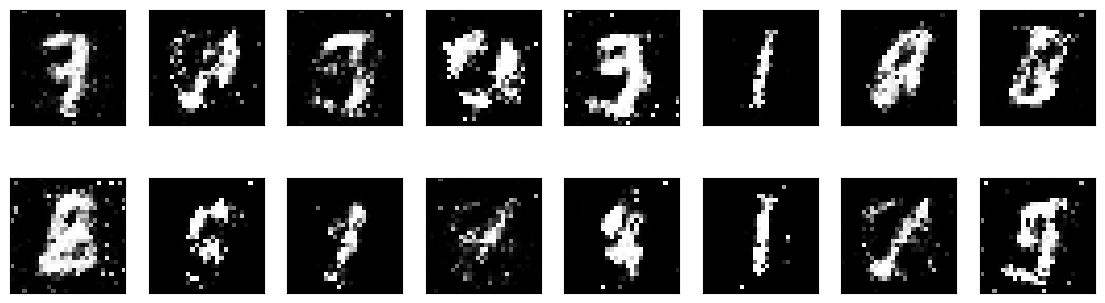

2024-01-01 09:35:20 | Epoch [14/150] | Batch 0/469 | d_loss: 0.8889 | g_loss: 1.6757
2024-01-01 09:35:22 | Epoch [14/150] | Batch 100/469 | d_loss: 0.9811 | g_loss: 1.9759
2024-01-01 09:35:23 | Epoch [14/150] | Batch 200/469 | d_loss: 0.9031 | g_loss: 1.9641
2024-01-01 09:35:24 | Epoch [14/150] | Batch 300/469 | d_loss: 0.9524 | g_loss: 1.9335
2024-01-01 09:35:26 | Epoch [14/150] | Batch 400/469 | d_loss: 0.8696 | g_loss: 2.1533


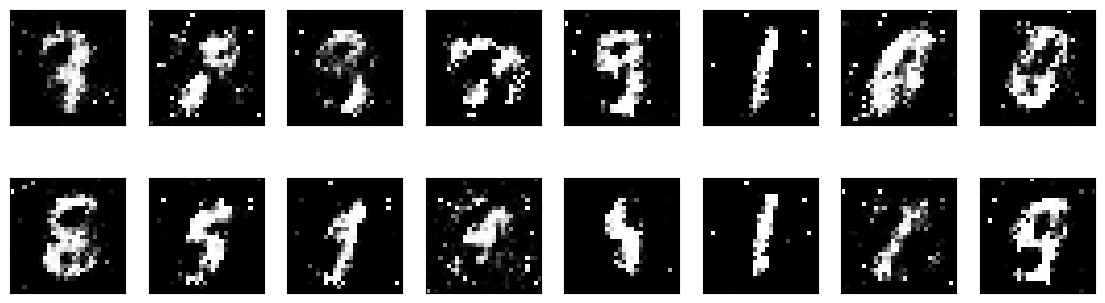

2024-01-01 09:35:30 | Epoch [15/150] | Batch 0/469 | d_loss: 0.9852 | g_loss: 1.7094
2024-01-01 09:35:31 | Epoch [15/150] | Batch 100/469 | d_loss: 0.9753 | g_loss: 2.0998
2024-01-01 09:35:33 | Epoch [15/150] | Batch 200/469 | d_loss: 0.7710 | g_loss: 2.0931
2024-01-01 09:35:34 | Epoch [15/150] | Batch 300/469 | d_loss: 0.9253 | g_loss: 1.8783
2024-01-01 09:35:36 | Epoch [15/150] | Batch 400/469 | d_loss: 0.8896 | g_loss: 1.9784


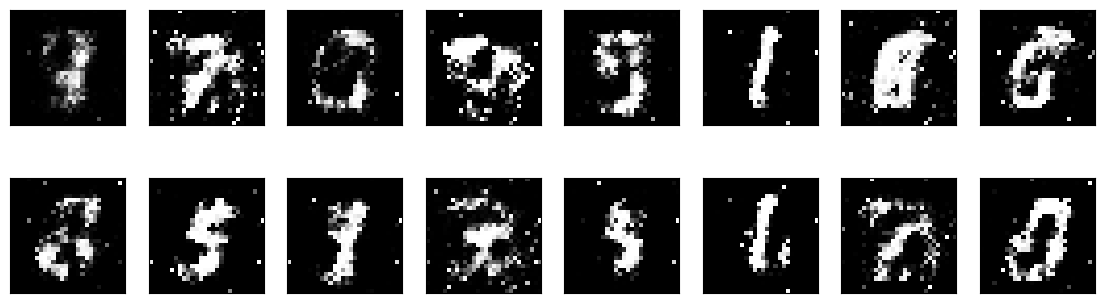

2024-01-01 09:35:40 | Epoch [16/150] | Batch 0/469 | d_loss: 0.8654 | g_loss: 2.1486
2024-01-01 09:35:41 | Epoch [16/150] | Batch 100/469 | d_loss: 0.8545 | g_loss: 2.2652
2024-01-01 09:35:42 | Epoch [16/150] | Batch 200/469 | d_loss: 0.9350 | g_loss: 1.8987
2024-01-01 09:35:44 | Epoch [16/150] | Batch 300/469 | d_loss: 1.0466 | g_loss: 2.2074
2024-01-01 09:35:45 | Epoch [16/150] | Batch 400/469 | d_loss: 1.0224 | g_loss: 2.1436


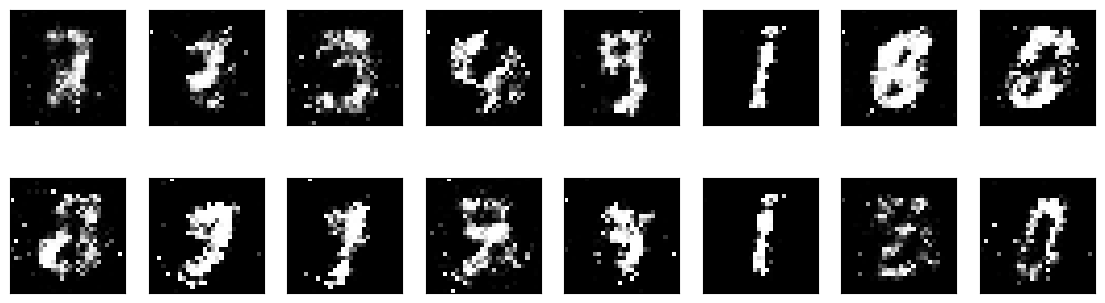

2024-01-01 09:35:49 | Epoch [17/150] | Batch 0/469 | d_loss: 0.7577 | g_loss: 2.3860
2024-01-01 09:35:50 | Epoch [17/150] | Batch 100/469 | d_loss: 0.8441 | g_loss: 2.4504
2024-01-01 09:35:52 | Epoch [17/150] | Batch 200/469 | d_loss: 0.9194 | g_loss: 2.0466
2024-01-01 09:35:53 | Epoch [17/150] | Batch 300/469 | d_loss: 0.9855 | g_loss: 1.9129
2024-01-01 09:35:55 | Epoch [17/150] | Batch 400/469 | d_loss: 0.8989 | g_loss: 1.9821


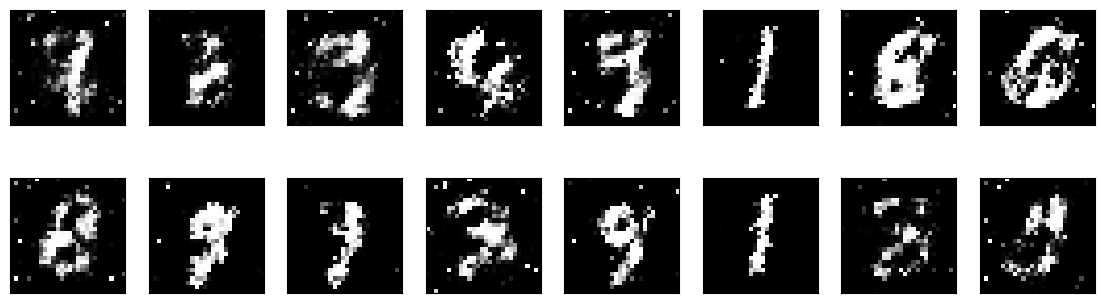

2024-01-01 09:35:59 | Epoch [18/150] | Batch 0/469 | d_loss: 1.0780 | g_loss: 1.9751
2024-01-01 09:36:01 | Epoch [18/150] | Batch 100/469 | d_loss: 0.9866 | g_loss: 1.7143
2024-01-01 09:36:02 | Epoch [18/150] | Batch 200/469 | d_loss: 0.9379 | g_loss: 2.0694
2024-01-01 09:36:04 | Epoch [18/150] | Batch 300/469 | d_loss: 0.9678 | g_loss: 1.7905
2024-01-01 09:36:05 | Epoch [18/150] | Batch 400/469 | d_loss: 1.0674 | g_loss: 2.0674


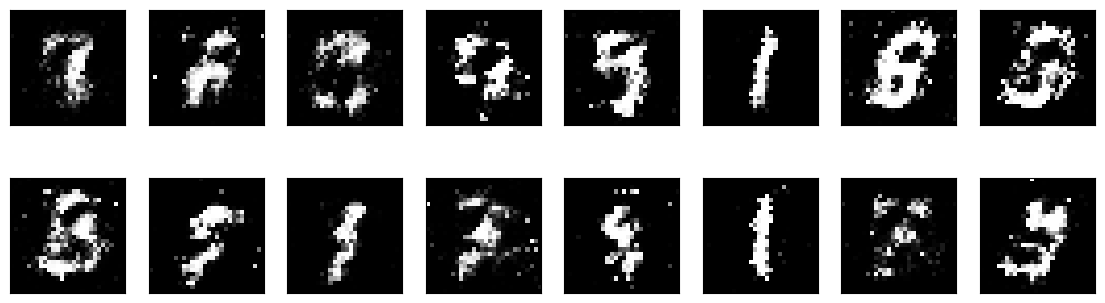

2024-01-01 09:36:09 | Epoch [19/150] | Batch 0/469 | d_loss: 1.0156 | g_loss: 1.6414
2024-01-01 09:36:11 | Epoch [19/150] | Batch 100/469 | d_loss: 1.0193 | g_loss: 1.8812
2024-01-01 09:36:12 | Epoch [19/150] | Batch 200/469 | d_loss: 0.8949 | g_loss: 1.7489
2024-01-01 09:36:13 | Epoch [19/150] | Batch 300/469 | d_loss: 1.0449 | g_loss: 1.9056
2024-01-01 09:36:15 | Epoch [19/150] | Batch 400/469 | d_loss: 0.8810 | g_loss: 2.0224


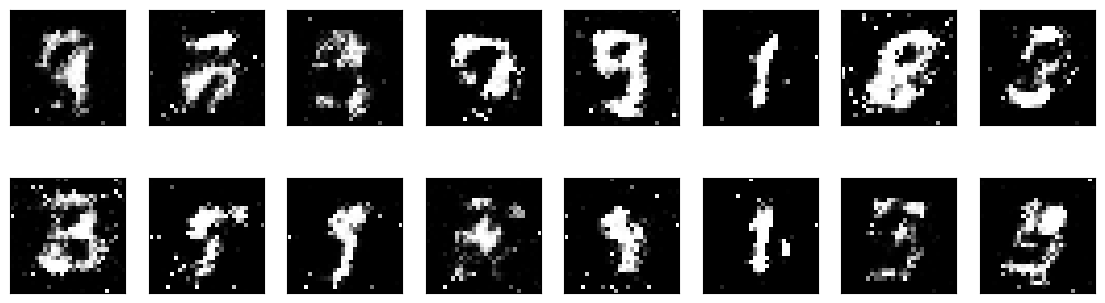

2024-01-01 09:36:19 | Epoch [20/150] | Batch 0/469 | d_loss: 0.9275 | g_loss: 2.2987
2024-01-01 09:36:20 | Epoch [20/150] | Batch 100/469 | d_loss: 0.9672 | g_loss: 1.8011
2024-01-01 09:36:22 | Epoch [20/150] | Batch 200/469 | d_loss: 0.9591 | g_loss: 2.1746
2024-01-01 09:36:23 | Epoch [20/150] | Batch 300/469 | d_loss: 0.9388 | g_loss: 2.0623
2024-01-01 09:36:25 | Epoch [20/150] | Batch 400/469 | d_loss: 0.9027 | g_loss: 1.9496


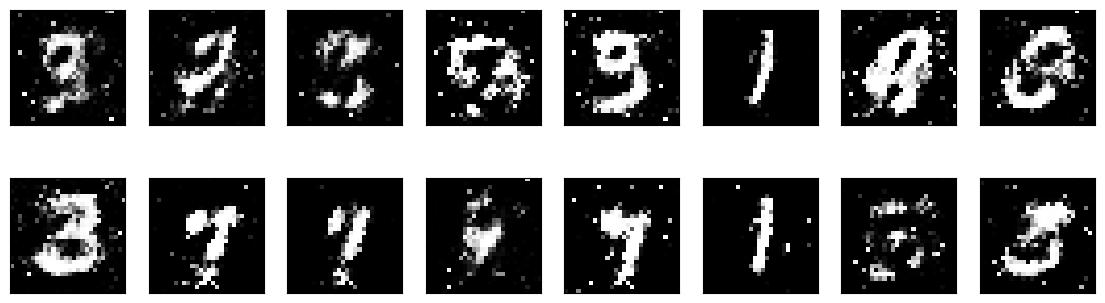

2024-01-01 09:36:29 | Epoch [21/150] | Batch 0/469 | d_loss: 0.9872 | g_loss: 1.6695
2024-01-01 09:36:31 | Epoch [21/150] | Batch 100/469 | d_loss: 1.0036 | g_loss: 2.0381
2024-01-01 09:36:32 | Epoch [21/150] | Batch 200/469 | d_loss: 0.9078 | g_loss: 1.6564
2024-01-01 09:36:33 | Epoch [21/150] | Batch 300/469 | d_loss: 0.9290 | g_loss: 1.6405
2024-01-01 09:36:35 | Epoch [21/150] | Batch 400/469 | d_loss: 0.9753 | g_loss: 1.7584


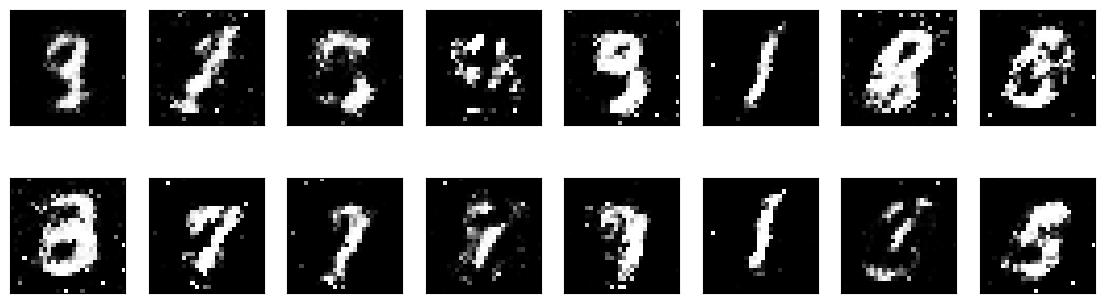

2024-01-01 09:36:39 | Epoch [22/150] | Batch 0/469 | d_loss: 0.9772 | g_loss: 1.5586
2024-01-01 09:36:41 | Epoch [22/150] | Batch 100/469 | d_loss: 0.9841 | g_loss: 1.8657
2024-01-01 09:36:42 | Epoch [22/150] | Batch 200/469 | d_loss: 1.0689 | g_loss: 1.7815
2024-01-01 09:36:43 | Epoch [22/150] | Batch 300/469 | d_loss: 1.0291 | g_loss: 1.4895
2024-01-01 09:36:45 | Epoch [22/150] | Batch 400/469 | d_loss: 1.0561 | g_loss: 1.7168


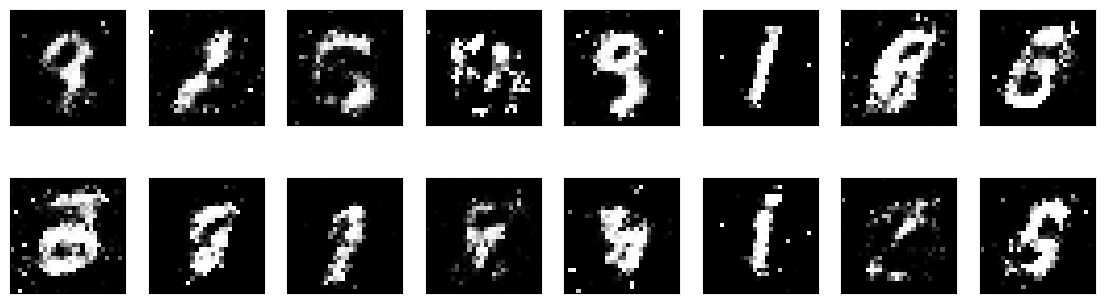

2024-01-01 09:36:49 | Epoch [23/150] | Batch 0/469 | d_loss: 0.9470 | g_loss: 1.9319
2024-01-01 09:36:50 | Epoch [23/150] | Batch 100/469 | d_loss: 1.0604 | g_loss: 2.0421
2024-01-01 09:36:52 | Epoch [23/150] | Batch 200/469 | d_loss: 0.9999 | g_loss: 1.8963
2024-01-01 09:36:53 | Epoch [23/150] | Batch 300/469 | d_loss: 1.0238 | g_loss: 1.8278
2024-01-01 09:36:54 | Epoch [23/150] | Batch 400/469 | d_loss: 1.0363 | g_loss: 2.0238


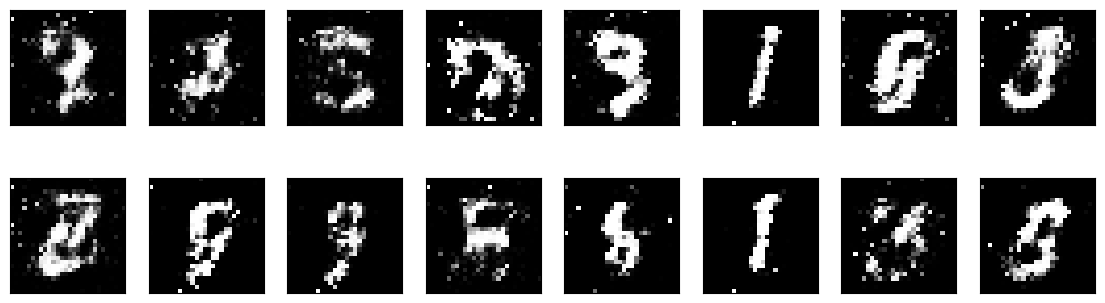

2024-01-01 09:36:58 | Epoch [24/150] | Batch 0/469 | d_loss: 0.9599 | g_loss: 2.0668
2024-01-01 09:37:00 | Epoch [24/150] | Batch 100/469 | d_loss: 0.9573 | g_loss: 2.0905
2024-01-01 09:37:01 | Epoch [24/150] | Batch 200/469 | d_loss: 0.9077 | g_loss: 1.7966
2024-01-01 09:37:03 | Epoch [24/150] | Batch 300/469 | d_loss: 1.0216 | g_loss: 1.8103
2024-01-01 09:37:04 | Epoch [24/150] | Batch 400/469 | d_loss: 0.9370 | g_loss: 1.7802


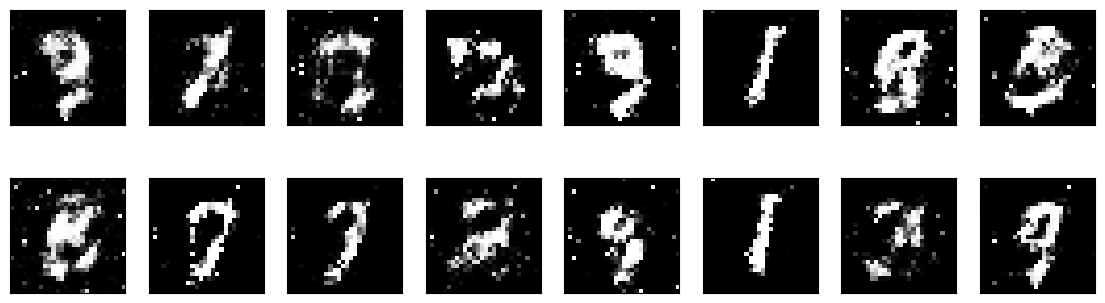

2024-01-01 09:37:08 | Epoch [25/150] | Batch 0/469 | d_loss: 0.8930 | g_loss: 2.0477
2024-01-01 09:37:10 | Epoch [25/150] | Batch 100/469 | d_loss: 1.0851 | g_loss: 1.8534
2024-01-01 09:37:11 | Epoch [25/150] | Batch 200/469 | d_loss: 0.9430 | g_loss: 2.0167
2024-01-01 09:37:13 | Epoch [25/150] | Batch 300/469 | d_loss: 1.0842 | g_loss: 1.9796
2024-01-01 09:37:14 | Epoch [25/150] | Batch 400/469 | d_loss: 0.9791 | g_loss: 1.5718


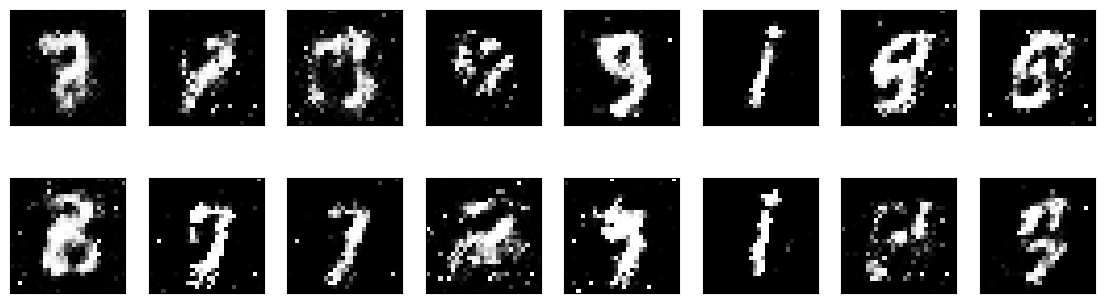

2024-01-01 09:37:18 | Epoch [26/150] | Batch 0/469 | d_loss: 0.9630 | g_loss: 1.8991
2024-01-01 09:37:20 | Epoch [26/150] | Batch 100/469 | d_loss: 0.9431 | g_loss: 1.9204
2024-01-01 09:37:21 | Epoch [26/150] | Batch 200/469 | d_loss: 0.9603 | g_loss: 1.7015
2024-01-01 09:37:23 | Epoch [26/150] | Batch 300/469 | d_loss: 0.9298 | g_loss: 1.6669
2024-01-01 09:37:24 | Epoch [26/150] | Batch 400/469 | d_loss: 0.9242 | g_loss: 1.7931


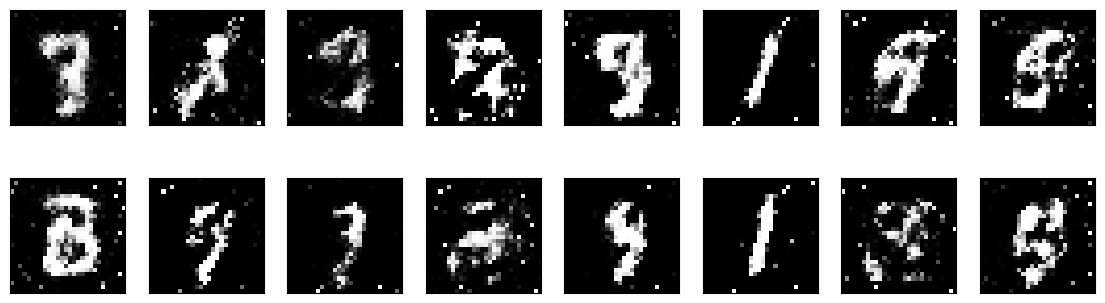

2024-01-01 09:37:28 | Epoch [27/150] | Batch 0/469 | d_loss: 0.9799 | g_loss: 2.1368
2024-01-01 09:37:30 | Epoch [27/150] | Batch 100/469 | d_loss: 0.9670 | g_loss: 1.8729
2024-01-01 09:37:31 | Epoch [27/150] | Batch 200/469 | d_loss: 0.8730 | g_loss: 2.1057
2024-01-01 09:37:33 | Epoch [27/150] | Batch 300/469 | d_loss: 0.9966 | g_loss: 1.4791
2024-01-01 09:37:34 | Epoch [27/150] | Batch 400/469 | d_loss: 0.8087 | g_loss: 2.0768


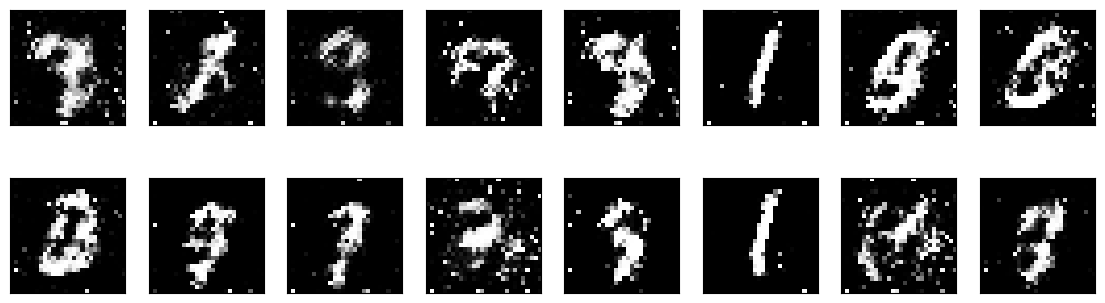

2024-01-01 09:37:38 | Epoch [28/150] | Batch 0/469 | d_loss: 0.9942 | g_loss: 2.0558
2024-01-01 09:37:40 | Epoch [28/150] | Batch 100/469 | d_loss: 0.9770 | g_loss: 2.0802
2024-01-01 09:37:41 | Epoch [28/150] | Batch 200/469 | d_loss: 0.9274 | g_loss: 1.8531
2024-01-01 09:37:42 | Epoch [28/150] | Batch 300/469 | d_loss: 0.9650 | g_loss: 1.7172
2024-01-01 09:37:44 | Epoch [28/150] | Batch 400/469 | d_loss: 0.9387 | g_loss: 2.0004


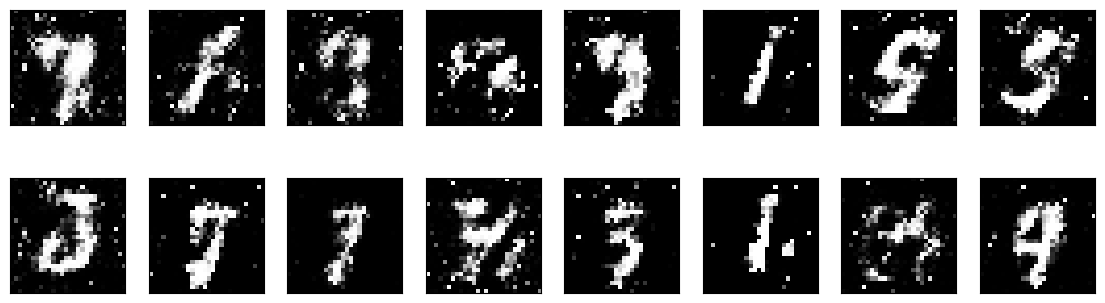

2024-01-01 09:37:48 | Epoch [29/150] | Batch 0/469 | d_loss: 0.9924 | g_loss: 1.8121
2024-01-01 09:37:50 | Epoch [29/150] | Batch 100/469 | d_loss: 1.0175 | g_loss: 2.0042
2024-01-01 09:37:51 | Epoch [29/150] | Batch 200/469 | d_loss: 0.9312 | g_loss: 1.9686
2024-01-01 09:37:53 | Epoch [29/150] | Batch 300/469 | d_loss: 0.9233 | g_loss: 1.8695
2024-01-01 09:37:54 | Epoch [29/150] | Batch 400/469 | d_loss: 1.1028 | g_loss: 1.5934


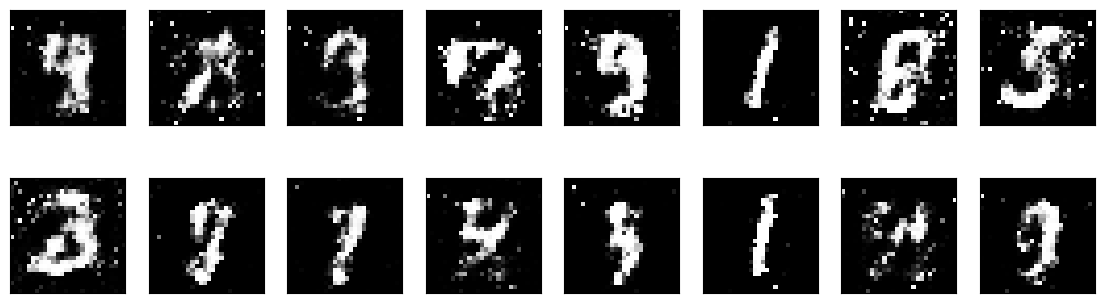

2024-01-01 09:37:58 | Epoch [30/150] | Batch 0/469 | d_loss: 0.9373 | g_loss: 1.8769
2024-01-01 09:38:00 | Epoch [30/150] | Batch 100/469 | d_loss: 1.0581 | g_loss: 2.0466
2024-01-01 09:38:01 | Epoch [30/150] | Batch 200/469 | d_loss: 0.9837 | g_loss: 1.7365
2024-01-01 09:38:03 | Epoch [30/150] | Batch 300/469 | d_loss: 1.0356 | g_loss: 1.8191
2024-01-01 09:38:04 | Epoch [30/150] | Batch 400/469 | d_loss: 0.9139 | g_loss: 1.7297


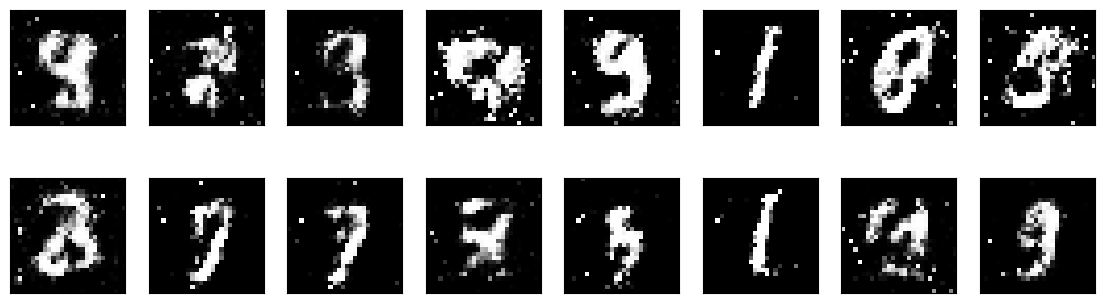

2024-01-01 09:38:08 | Epoch [31/150] | Batch 0/469 | d_loss: 0.9577 | g_loss: 1.8705
2024-01-01 09:38:10 | Epoch [31/150] | Batch 100/469 | d_loss: 1.0200 | g_loss: 1.9342
2024-01-01 09:38:11 | Epoch [31/150] | Batch 200/469 | d_loss: 1.0368 | g_loss: 1.7943
2024-01-01 09:38:12 | Epoch [31/150] | Batch 300/469 | d_loss: 1.0086 | g_loss: 1.5589
2024-01-01 09:38:14 | Epoch [31/150] | Batch 400/469 | d_loss: 1.0747 | g_loss: 1.4631


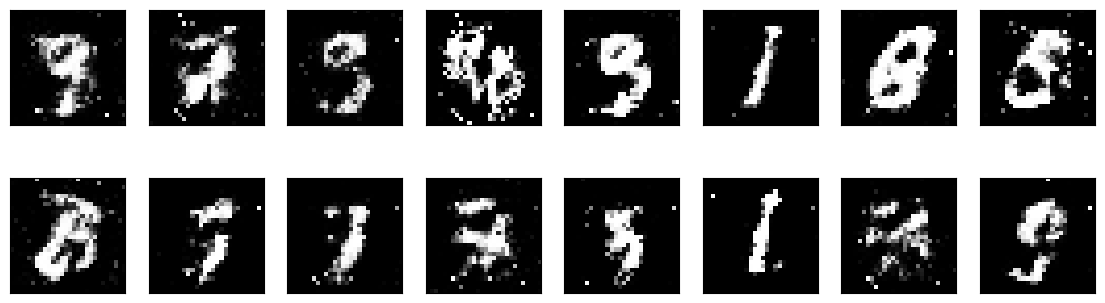

2024-01-01 09:38:18 | Epoch [32/150] | Batch 0/469 | d_loss: 1.0664 | g_loss: 1.8970
2024-01-01 09:38:20 | Epoch [32/150] | Batch 100/469 | d_loss: 0.9955 | g_loss: 1.6443
2024-01-01 09:38:21 | Epoch [32/150] | Batch 200/469 | d_loss: 0.9625 | g_loss: 1.7195
2024-01-01 09:38:22 | Epoch [32/150] | Batch 300/469 | d_loss: 1.0258 | g_loss: 1.6231
2024-01-01 09:38:24 | Epoch [32/150] | Batch 400/469 | d_loss: 1.0928 | g_loss: 1.8728


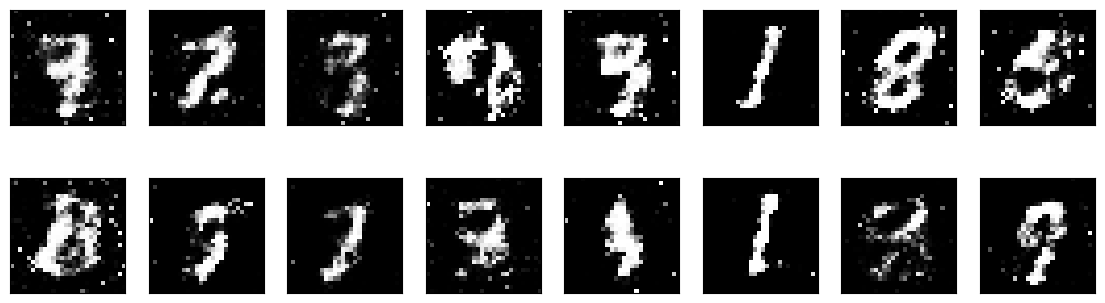

2024-01-01 09:38:28 | Epoch [33/150] | Batch 0/469 | d_loss: 1.1124 | g_loss: 1.4763
2024-01-01 09:38:29 | Epoch [33/150] | Batch 100/469 | d_loss: 1.0503 | g_loss: 1.6085
2024-01-01 09:38:31 | Epoch [33/150] | Batch 200/469 | d_loss: 1.0089 | g_loss: 1.5713
2024-01-01 09:38:32 | Epoch [33/150] | Batch 300/469 | d_loss: 1.0307 | g_loss: 1.7618
2024-01-01 09:38:33 | Epoch [33/150] | Batch 400/469 | d_loss: 0.9941 | g_loss: 1.7835


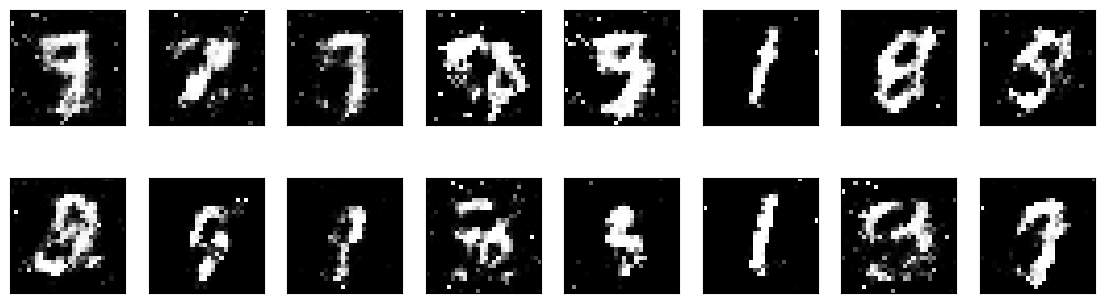

2024-01-01 09:38:37 | Epoch [34/150] | Batch 0/469 | d_loss: 0.9947 | g_loss: 1.6425
2024-01-01 09:38:39 | Epoch [34/150] | Batch 100/469 | d_loss: 1.0359 | g_loss: 1.7421
2024-01-01 09:38:40 | Epoch [34/150] | Batch 200/469 | d_loss: 1.0638 | g_loss: 1.6176
2024-01-01 09:38:41 | Epoch [34/150] | Batch 300/469 | d_loss: 1.0283 | g_loss: 1.6660
2024-01-01 09:38:43 | Epoch [34/150] | Batch 400/469 | d_loss: 1.1744 | g_loss: 1.5816


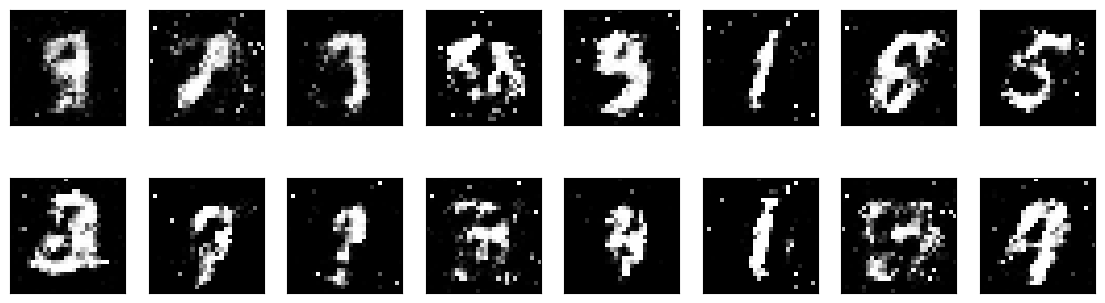

2024-01-01 09:38:47 | Epoch [35/150] | Batch 0/469 | d_loss: 1.0127 | g_loss: 1.8532
2024-01-01 09:38:48 | Epoch [35/150] | Batch 100/469 | d_loss: 1.0140 | g_loss: 2.0259
2024-01-01 09:38:49 | Epoch [35/150] | Batch 200/469 | d_loss: 0.9841 | g_loss: 1.7868
2024-01-01 09:38:51 | Epoch [35/150] | Batch 300/469 | d_loss: 1.0464 | g_loss: 1.7632
2024-01-01 09:38:52 | Epoch [35/150] | Batch 400/469 | d_loss: 1.1420 | g_loss: 1.3154


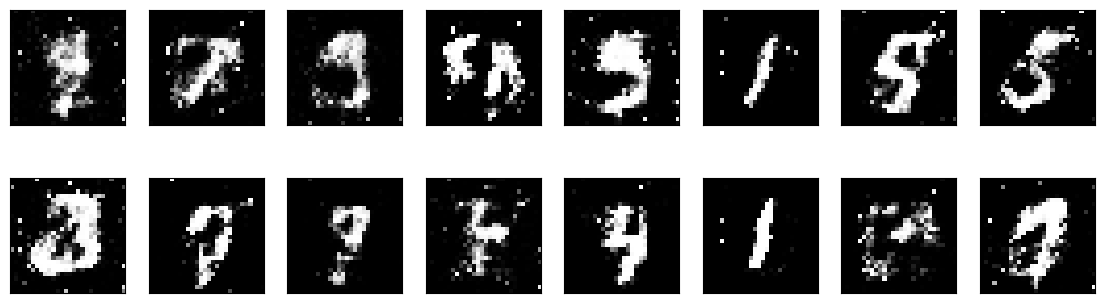

2024-01-01 09:38:56 | Epoch [36/150] | Batch 0/469 | d_loss: 0.9536 | g_loss: 1.5689
2024-01-01 09:38:58 | Epoch [36/150] | Batch 100/469 | d_loss: 1.1146 | g_loss: 2.0025
2024-01-01 09:38:59 | Epoch [36/150] | Batch 200/469 | d_loss: 0.9584 | g_loss: 1.7860
2024-01-01 09:39:01 | Epoch [36/150] | Batch 300/469 | d_loss: 1.0573 | g_loss: 1.6771
2024-01-01 09:39:02 | Epoch [36/150] | Batch 400/469 | d_loss: 0.9758 | g_loss: 1.9558


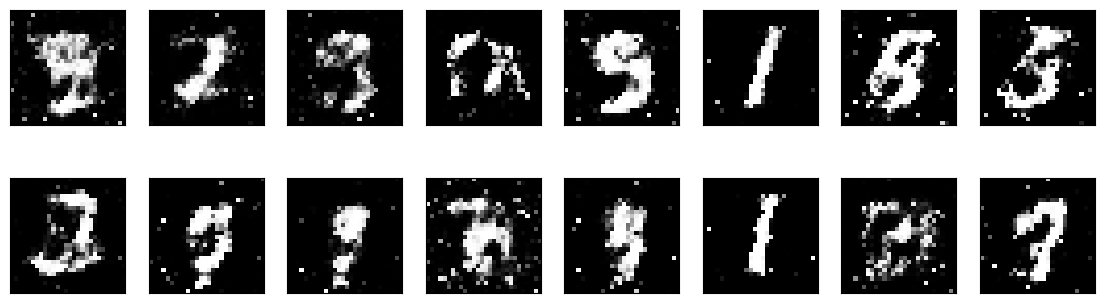

2024-01-01 09:39:06 | Epoch [37/150] | Batch 0/469 | d_loss: 1.0800 | g_loss: 1.5891
2024-01-01 09:39:07 | Epoch [37/150] | Batch 100/469 | d_loss: 1.0260 | g_loss: 1.8340
2024-01-01 09:39:09 | Epoch [37/150] | Batch 200/469 | d_loss: 0.9093 | g_loss: 1.6306
2024-01-01 09:39:10 | Epoch [37/150] | Batch 300/469 | d_loss: 0.9880 | g_loss: 1.7675
2024-01-01 09:39:12 | Epoch [37/150] | Batch 400/469 | d_loss: 1.0589 | g_loss: 1.7649


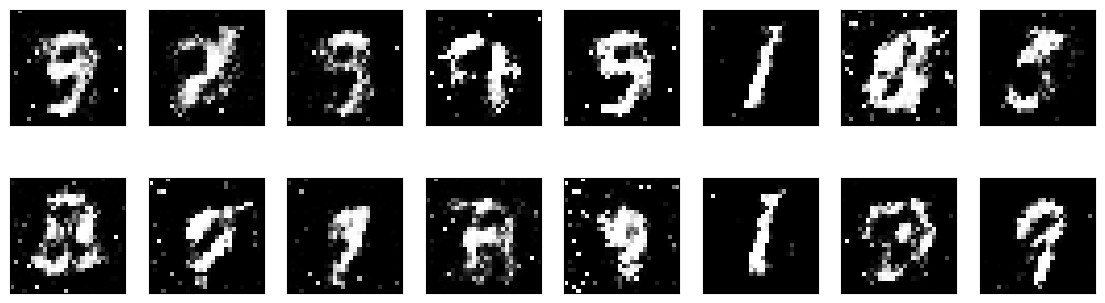

2024-01-01 09:39:15 | Epoch [38/150] | Batch 0/469 | d_loss: 0.9349 | g_loss: 1.7925
2024-01-01 09:39:17 | Epoch [38/150] | Batch 100/469 | d_loss: 1.1095 | g_loss: 1.6833
2024-01-01 09:39:18 | Epoch [38/150] | Batch 200/469 | d_loss: 1.0161 | g_loss: 1.6290
2024-01-01 09:39:19 | Epoch [38/150] | Batch 300/469 | d_loss: 0.9795 | g_loss: 1.7887
2024-01-01 09:39:21 | Epoch [38/150] | Batch 400/469 | d_loss: 0.9589 | g_loss: 1.5031


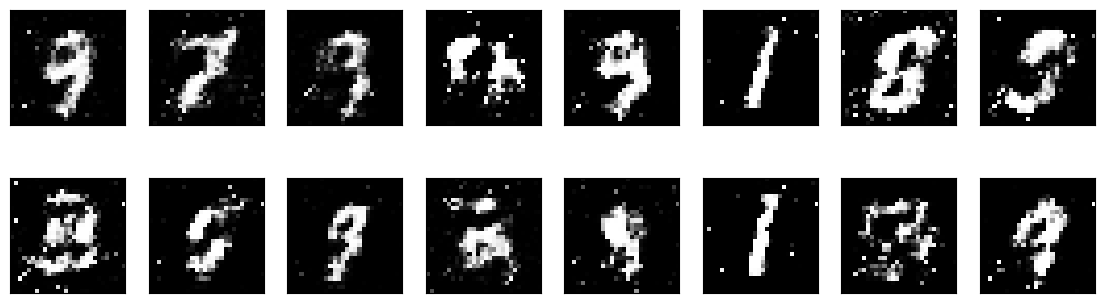

2024-01-01 09:39:25 | Epoch [39/150] | Batch 0/469 | d_loss: 0.9690 | g_loss: 1.8508
2024-01-01 09:39:26 | Epoch [39/150] | Batch 100/469 | d_loss: 1.1260 | g_loss: 1.6328
2024-01-01 09:39:28 | Epoch [39/150] | Batch 200/469 | d_loss: 0.9278 | g_loss: 1.7288
2024-01-01 09:39:29 | Epoch [39/150] | Batch 300/469 | d_loss: 1.0970 | g_loss: 1.5400
2024-01-01 09:39:31 | Epoch [39/150] | Batch 400/469 | d_loss: 0.9798 | g_loss: 1.4993


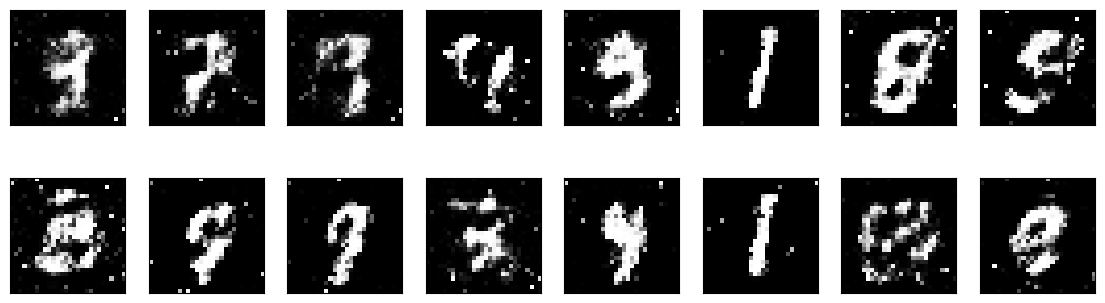

2024-01-01 09:39:34 | Epoch [40/150] | Batch 0/469 | d_loss: 0.9411 | g_loss: 1.5964
2024-01-01 09:39:36 | Epoch [40/150] | Batch 100/469 | d_loss: 1.1866 | g_loss: 1.5627
2024-01-01 09:39:37 | Epoch [40/150] | Batch 200/469 | d_loss: 1.0611 | g_loss: 1.4911
2024-01-01 09:39:38 | Epoch [40/150] | Batch 300/469 | d_loss: 1.0740 | g_loss: 1.4458
2024-01-01 09:39:40 | Epoch [40/150] | Batch 400/469 | d_loss: 0.9480 | g_loss: 1.6104


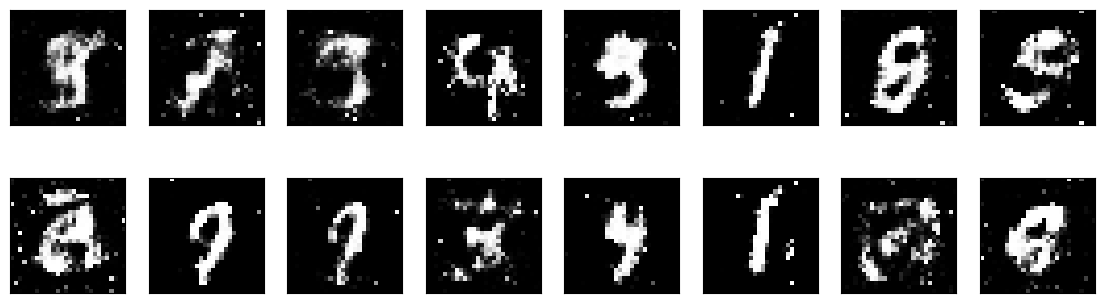

2024-01-01 09:39:44 | Epoch [41/150] | Batch 0/469 | d_loss: 1.0235 | g_loss: 1.9625
2024-01-01 09:39:45 | Epoch [41/150] | Batch 100/469 | d_loss: 1.0270 | g_loss: 1.5722
2024-01-01 09:39:46 | Epoch [41/150] | Batch 200/469 | d_loss: 1.0478 | g_loss: 1.5382
2024-01-01 09:39:48 | Epoch [41/150] | Batch 300/469 | d_loss: 1.1026 | g_loss: 1.8167
2024-01-01 09:39:49 | Epoch [41/150] | Batch 400/469 | d_loss: 0.9684 | g_loss: 1.6137


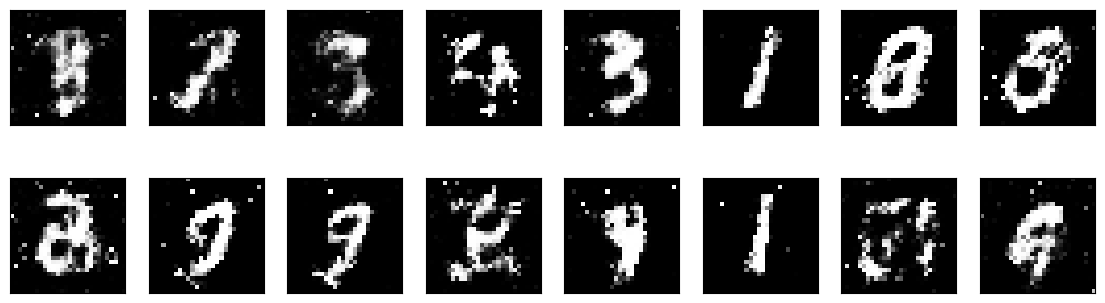

2024-01-01 09:39:53 | Epoch [42/150] | Batch 0/469 | d_loss: 0.9670 | g_loss: 1.6756
2024-01-01 09:39:54 | Epoch [42/150] | Batch 100/469 | d_loss: 1.0794 | g_loss: 1.6169
2024-01-01 09:39:56 | Epoch [42/150] | Batch 200/469 | d_loss: 1.0417 | g_loss: 1.7350
2024-01-01 09:39:57 | Epoch [42/150] | Batch 300/469 | d_loss: 1.0023 | g_loss: 1.5394
2024-01-01 09:39:58 | Epoch [42/150] | Batch 400/469 | d_loss: 1.0917 | g_loss: 1.5023


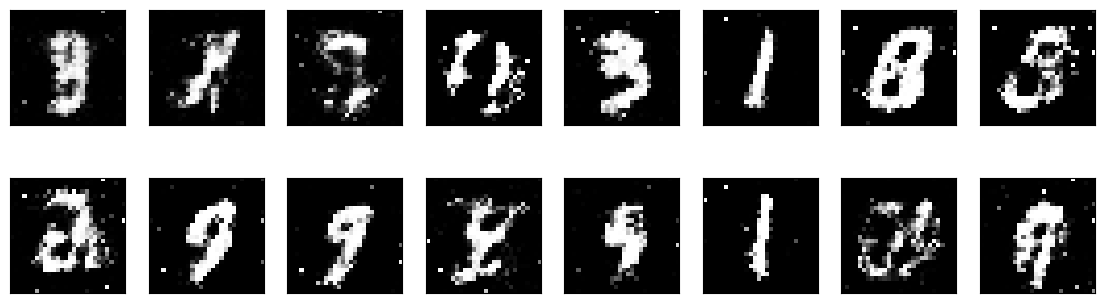

2024-01-01 09:40:02 | Epoch [43/150] | Batch 0/469 | d_loss: 1.0423 | g_loss: 1.6207
2024-01-01 09:40:04 | Epoch [43/150] | Batch 100/469 | d_loss: 1.0836 | g_loss: 1.5653
2024-01-01 09:40:05 | Epoch [43/150] | Batch 200/469 | d_loss: 1.0882 | g_loss: 1.4286
2024-01-01 09:40:06 | Epoch [43/150] | Batch 300/469 | d_loss: 1.1459 | g_loss: 1.3691
2024-01-01 09:40:08 | Epoch [43/150] | Batch 400/469 | d_loss: 1.0980 | g_loss: 1.5576


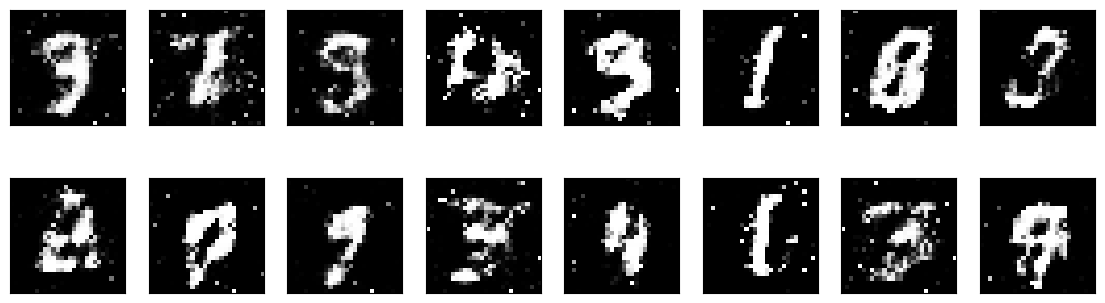

2024-01-01 09:40:12 | Epoch [44/150] | Batch 0/469 | d_loss: 1.1200 | g_loss: 1.4982
2024-01-01 09:40:13 | Epoch [44/150] | Batch 100/469 | d_loss: 1.1271 | g_loss: 1.6521
2024-01-01 09:40:14 | Epoch [44/150] | Batch 200/469 | d_loss: 1.0330 | g_loss: 1.4214
2024-01-01 09:40:16 | Epoch [44/150] | Batch 300/469 | d_loss: 1.1846 | g_loss: 1.4620
2024-01-01 09:40:17 | Epoch [44/150] | Batch 400/469 | d_loss: 1.0625 | g_loss: 1.3699


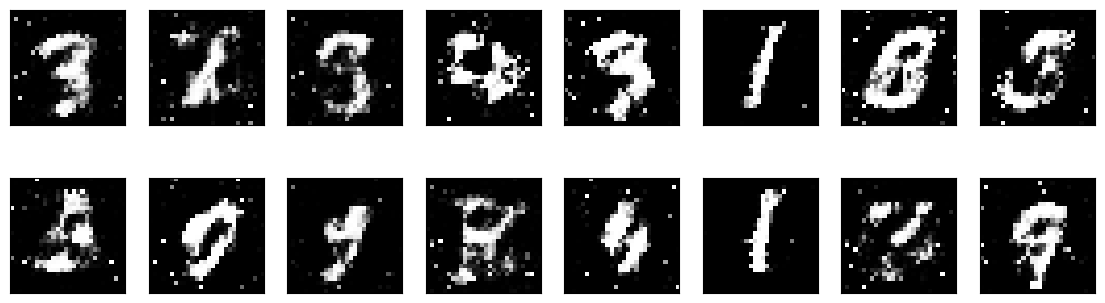

2024-01-01 09:40:21 | Epoch [45/150] | Batch 0/469 | d_loss: 1.0720 | g_loss: 1.4521
2024-01-01 09:40:22 | Epoch [45/150] | Batch 100/469 | d_loss: 1.0863 | g_loss: 1.4191
2024-01-01 09:40:24 | Epoch [45/150] | Batch 200/469 | d_loss: 1.0574 | g_loss: 1.5804
2024-01-01 09:40:25 | Epoch [45/150] | Batch 300/469 | d_loss: 1.0599 | g_loss: 1.4072
2024-01-01 09:40:26 | Epoch [45/150] | Batch 400/469 | d_loss: 1.0219 | g_loss: 1.6507


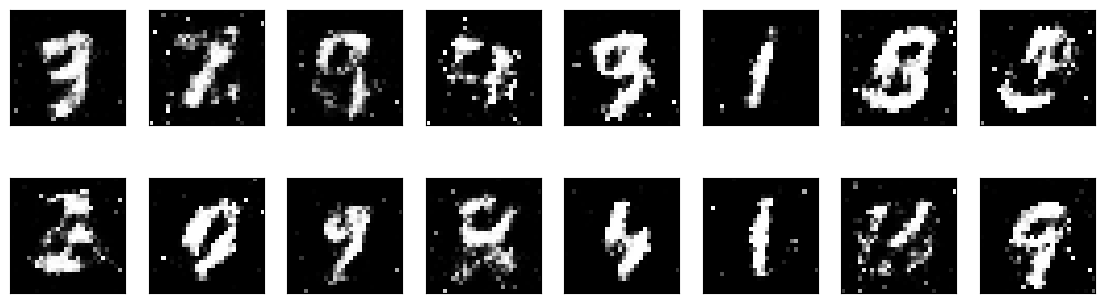

2024-01-01 09:40:30 | Epoch [46/150] | Batch 0/469 | d_loss: 1.1782 | g_loss: 1.4318
2024-01-01 09:40:32 | Epoch [46/150] | Batch 100/469 | d_loss: 1.0668 | g_loss: 1.3328
2024-01-01 09:40:33 | Epoch [46/150] | Batch 200/469 | d_loss: 1.0395 | g_loss: 1.6088
2024-01-01 09:40:35 | Epoch [46/150] | Batch 300/469 | d_loss: 1.1002 | g_loss: 1.4700
2024-01-01 09:40:36 | Epoch [46/150] | Batch 400/469 | d_loss: 0.9720 | g_loss: 1.4622


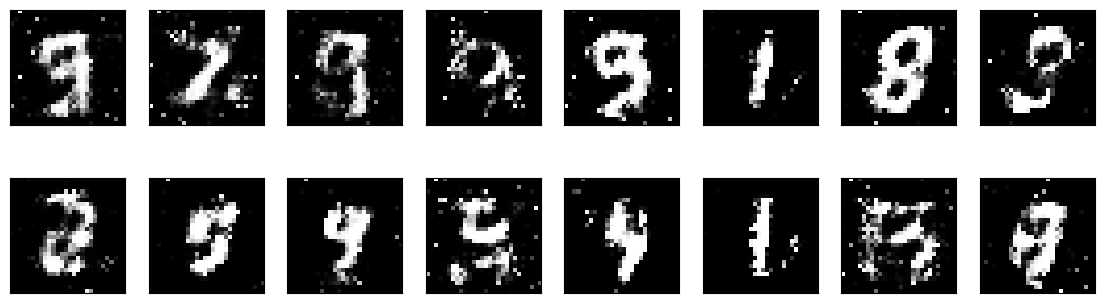

2024-01-01 09:40:40 | Epoch [47/150] | Batch 0/469 | d_loss: 0.9898 | g_loss: 1.6430
2024-01-01 09:40:41 | Epoch [47/150] | Batch 100/469 | d_loss: 0.9715 | g_loss: 1.6767
2024-01-01 09:40:43 | Epoch [47/150] | Batch 200/469 | d_loss: 0.9948 | g_loss: 1.4388
2024-01-01 09:40:44 | Epoch [47/150] | Batch 300/469 | d_loss: 0.9869 | g_loss: 1.4828
2024-01-01 09:40:46 | Epoch [47/150] | Batch 400/469 | d_loss: 1.0985 | g_loss: 1.6222


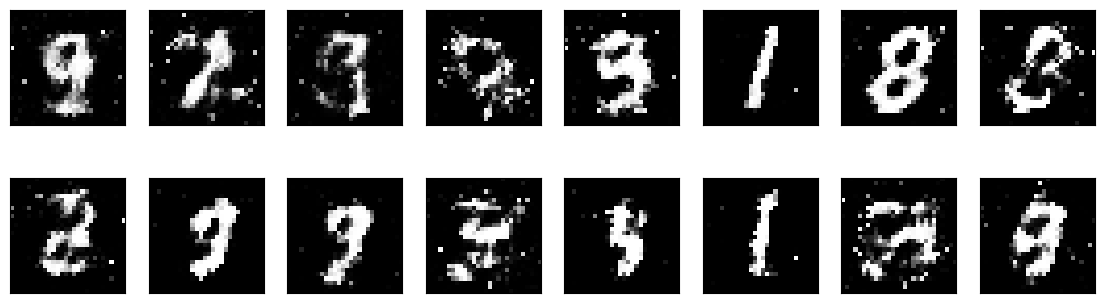

2024-01-01 09:40:50 | Epoch [48/150] | Batch 0/469 | d_loss: 0.9730 | g_loss: 1.7831
2024-01-01 09:40:51 | Epoch [48/150] | Batch 100/469 | d_loss: 1.1100 | g_loss: 1.6124
2024-01-01 09:40:52 | Epoch [48/150] | Batch 200/469 | d_loss: 0.9656 | g_loss: 1.5375
2024-01-01 09:40:54 | Epoch [48/150] | Batch 300/469 | d_loss: 1.0555 | g_loss: 1.5895
2024-01-01 09:40:55 | Epoch [48/150] | Batch 400/469 | d_loss: 1.1405 | g_loss: 1.5020


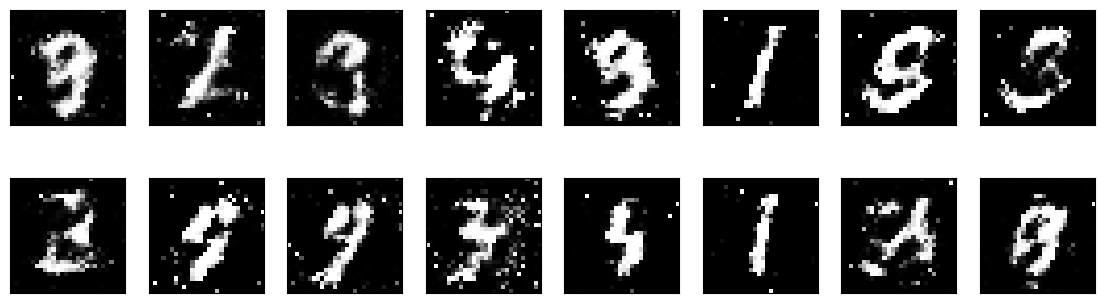

2024-01-01 09:40:59 | Epoch [49/150] | Batch 0/469 | d_loss: 0.9984 | g_loss: 1.6123
2024-01-01 09:41:01 | Epoch [49/150] | Batch 100/469 | d_loss: 1.0038 | g_loss: 1.7449
2024-01-01 09:41:02 | Epoch [49/150] | Batch 200/469 | d_loss: 1.0015 | g_loss: 1.5972
2024-01-01 09:41:04 | Epoch [49/150] | Batch 300/469 | d_loss: 1.0452 | g_loss: 1.7512
2024-01-01 09:41:05 | Epoch [49/150] | Batch 400/469 | d_loss: 1.0607 | g_loss: 1.4769


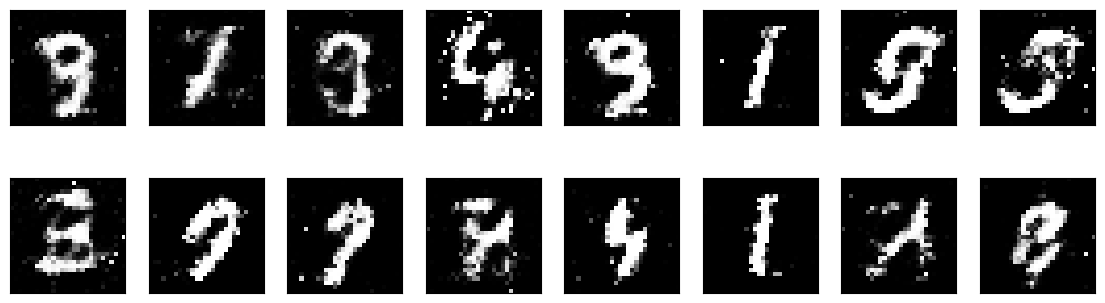

2024-01-01 09:41:09 | Epoch [50/150] | Batch 0/469 | d_loss: 0.9159 | g_loss: 1.3735
2024-01-01 09:41:11 | Epoch [50/150] | Batch 100/469 | d_loss: 1.0419 | g_loss: 1.3837
2024-01-01 09:41:12 | Epoch [50/150] | Batch 200/469 | d_loss: 1.1045 | g_loss: 1.6930
2024-01-01 09:41:14 | Epoch [50/150] | Batch 300/469 | d_loss: 1.0710 | g_loss: 1.3103
2024-01-01 09:41:15 | Epoch [50/150] | Batch 400/469 | d_loss: 1.0634 | g_loss: 1.5234


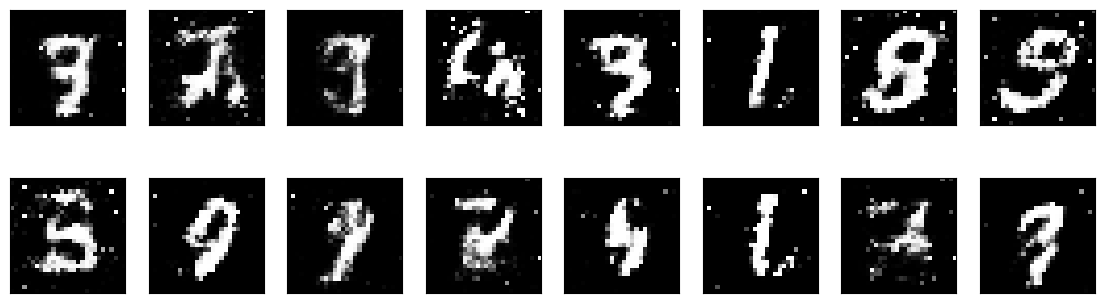

2024-01-01 09:41:19 | Epoch [51/150] | Batch 0/469 | d_loss: 1.0979 | g_loss: 1.5169
2024-01-01 09:41:20 | Epoch [51/150] | Batch 100/469 | d_loss: 1.1113 | g_loss: 1.5968
2024-01-01 09:41:22 | Epoch [51/150] | Batch 200/469 | d_loss: 1.1460 | g_loss: 1.3917
2024-01-01 09:41:23 | Epoch [51/150] | Batch 300/469 | d_loss: 1.0660 | g_loss: 1.4358
2024-01-01 09:41:25 | Epoch [51/150] | Batch 400/469 | d_loss: 0.9600 | g_loss: 1.6963


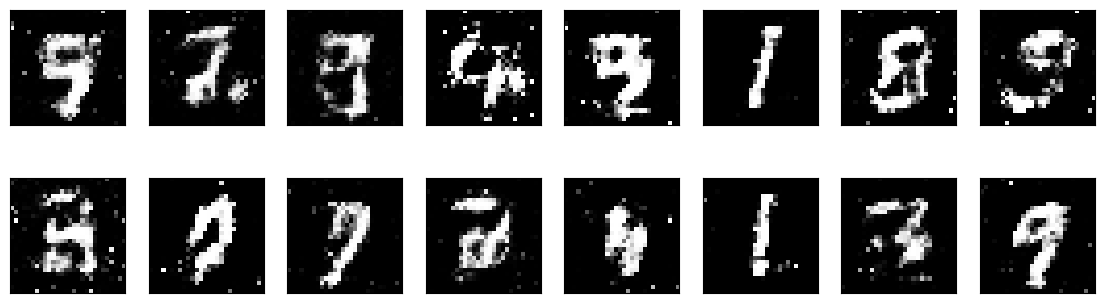

2024-01-01 09:41:29 | Epoch [52/150] | Batch 0/469 | d_loss: 0.9566 | g_loss: 1.5060
2024-01-01 09:41:30 | Epoch [52/150] | Batch 100/469 | d_loss: 0.9855 | g_loss: 1.9514
2024-01-01 09:41:32 | Epoch [52/150] | Batch 200/469 | d_loss: 1.0246 | g_loss: 1.7013
2024-01-01 09:41:33 | Epoch [52/150] | Batch 300/469 | d_loss: 1.0695 | g_loss: 1.4286
2024-01-01 09:41:34 | Epoch [52/150] | Batch 400/469 | d_loss: 1.0677 | g_loss: 1.5159


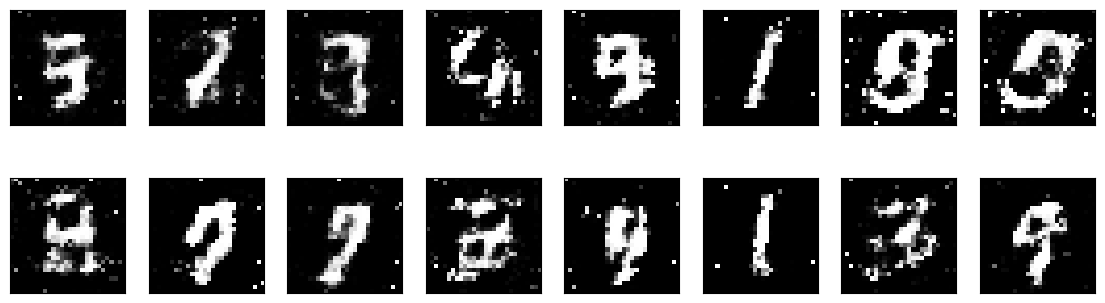

2024-01-01 09:41:38 | Epoch [53/150] | Batch 0/469 | d_loss: 1.0696 | g_loss: 1.6657
2024-01-01 09:41:40 | Epoch [53/150] | Batch 100/469 | d_loss: 1.0214 | g_loss: 1.7209
2024-01-01 09:41:41 | Epoch [53/150] | Batch 200/469 | d_loss: 0.9934 | g_loss: 1.7560
2024-01-01 09:41:43 | Epoch [53/150] | Batch 300/469 | d_loss: 1.0445 | g_loss: 1.5408
2024-01-01 09:41:44 | Epoch [53/150] | Batch 400/469 | d_loss: 1.1635 | g_loss: 1.3483


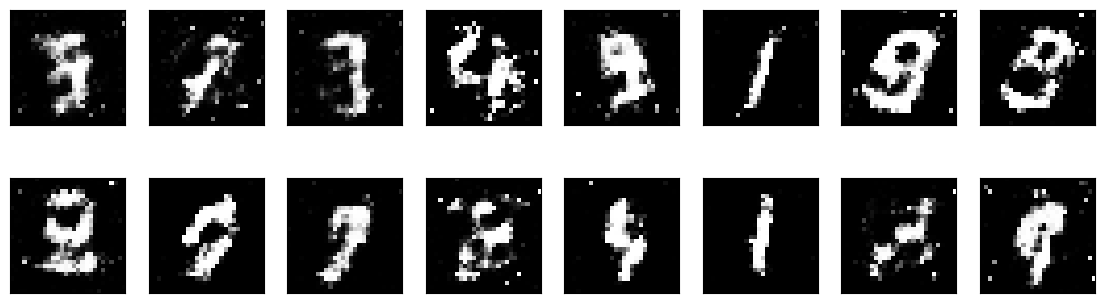

2024-01-01 09:41:48 | Epoch [54/150] | Batch 0/469 | d_loss: 1.2025 | g_loss: 1.3672
2024-01-01 09:41:50 | Epoch [54/150] | Batch 100/469 | d_loss: 1.0722 | g_loss: 1.6892
2024-01-01 09:41:51 | Epoch [54/150] | Batch 200/469 | d_loss: 1.0382 | g_loss: 1.4016
2024-01-01 09:41:52 | Epoch [54/150] | Batch 300/469 | d_loss: 1.1446 | g_loss: 1.5776
2024-01-01 09:41:54 | Epoch [54/150] | Batch 400/469 | d_loss: 1.0965 | g_loss: 1.6424


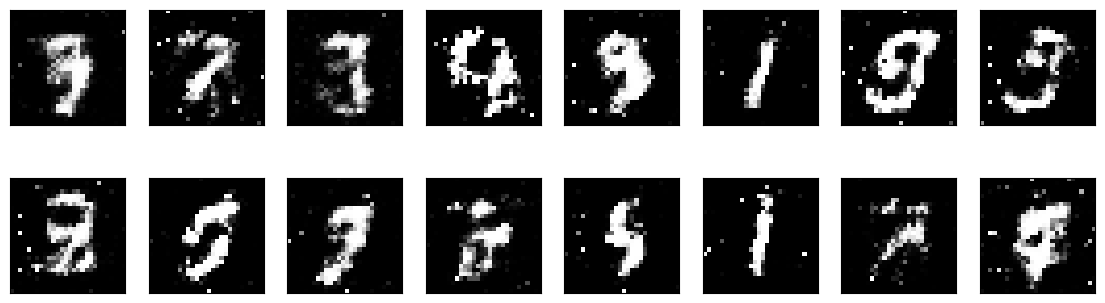

2024-01-01 09:41:58 | Epoch [55/150] | Batch 0/469 | d_loss: 0.9987 | g_loss: 1.5471
2024-01-01 09:41:59 | Epoch [55/150] | Batch 100/469 | d_loss: 1.1339 | g_loss: 1.5778
2024-01-01 09:42:01 | Epoch [55/150] | Batch 200/469 | d_loss: 1.0824 | g_loss: 1.5794
2024-01-01 09:42:02 | Epoch [55/150] | Batch 300/469 | d_loss: 1.1312 | g_loss: 1.6036
2024-01-01 09:42:04 | Epoch [55/150] | Batch 400/469 | d_loss: 0.9662 | g_loss: 1.5168


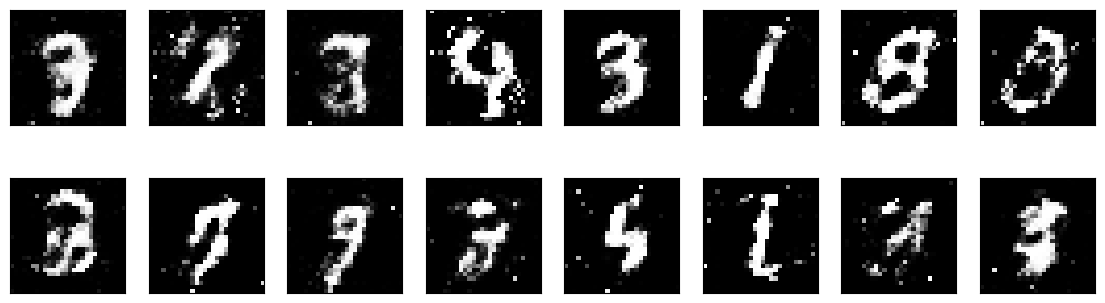

2024-01-01 09:42:08 | Epoch [56/150] | Batch 0/469 | d_loss: 1.0895 | g_loss: 1.6702
2024-01-01 09:42:09 | Epoch [56/150] | Batch 100/469 | d_loss: 1.1098 | g_loss: 1.4659
2024-01-01 09:42:11 | Epoch [56/150] | Batch 200/469 | d_loss: 0.9761 | g_loss: 1.3494
2024-01-01 09:42:12 | Epoch [56/150] | Batch 300/469 | d_loss: 0.9353 | g_loss: 1.5075
2024-01-01 09:42:14 | Epoch [56/150] | Batch 400/469 | d_loss: 1.0205 | g_loss: 1.6524


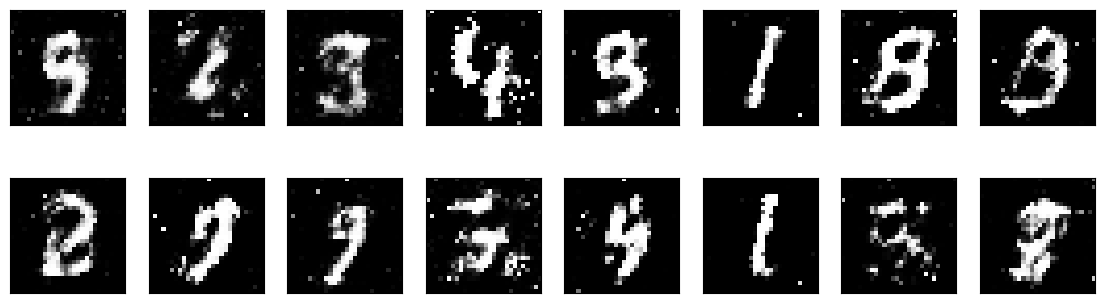

2024-01-01 09:42:18 | Epoch [57/150] | Batch 0/469 | d_loss: 0.9231 | g_loss: 1.6115
2024-01-01 09:42:19 | Epoch [57/150] | Batch 100/469 | d_loss: 1.0782 | g_loss: 1.5608
2024-01-01 09:42:21 | Epoch [57/150] | Batch 200/469 | d_loss: 1.0691 | g_loss: 1.3347
2024-01-01 09:42:22 | Epoch [57/150] | Batch 300/469 | d_loss: 1.1120 | g_loss: 1.6907
2024-01-01 09:42:24 | Epoch [57/150] | Batch 400/469 | d_loss: 1.0049 | g_loss: 1.6927


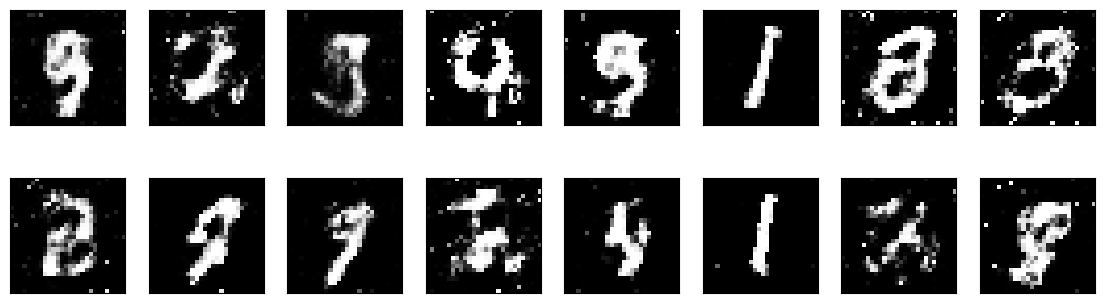

2024-01-01 09:42:28 | Epoch [58/150] | Batch 0/469 | d_loss: 1.1332 | g_loss: 1.6125
2024-01-01 09:42:29 | Epoch [58/150] | Batch 100/469 | d_loss: 1.0781 | g_loss: 1.4237
2024-01-01 09:42:30 | Epoch [58/150] | Batch 200/469 | d_loss: 1.0904 | g_loss: 1.7338
2024-01-01 09:42:32 | Epoch [58/150] | Batch 300/469 | d_loss: 1.0675 | g_loss: 1.5251
2024-01-01 09:42:33 | Epoch [58/150] | Batch 400/469 | d_loss: 1.1104 | g_loss: 1.3977


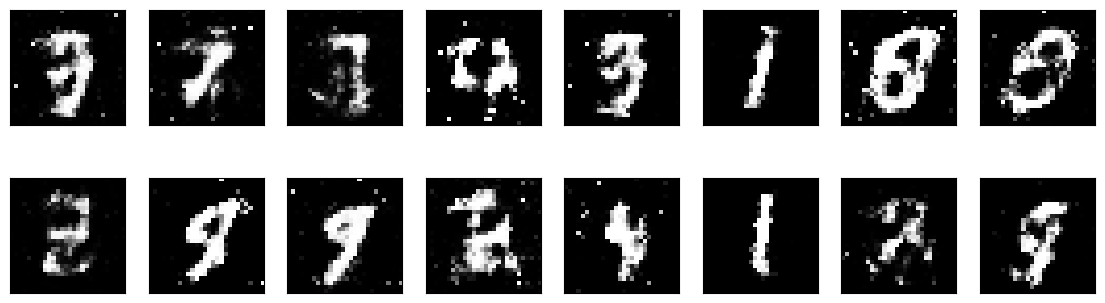

2024-01-01 09:42:37 | Epoch [59/150] | Batch 0/469 | d_loss: 1.0068 | g_loss: 1.4994
2024-01-01 09:42:38 | Epoch [59/150] | Batch 100/469 | d_loss: 1.0727 | g_loss: 1.5309
2024-01-01 09:42:40 | Epoch [59/150] | Batch 200/469 | d_loss: 1.0692 | g_loss: 1.4520
2024-01-01 09:42:41 | Epoch [59/150] | Batch 300/469 | d_loss: 1.0985 | g_loss: 1.3251
2024-01-01 09:42:43 | Epoch [59/150] | Batch 400/469 | d_loss: 1.0329 | g_loss: 1.5967


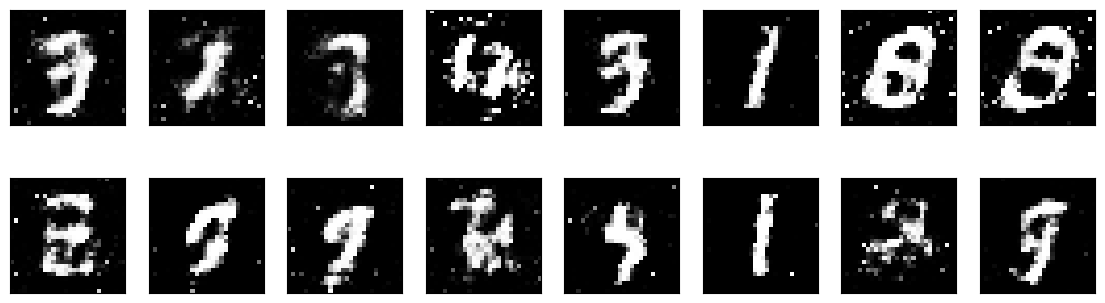

2024-01-01 09:42:47 | Epoch [60/150] | Batch 0/469 | d_loss: 1.0263 | g_loss: 1.5298
2024-01-01 09:42:48 | Epoch [60/150] | Batch 100/469 | d_loss: 1.0664 | g_loss: 1.4970
2024-01-01 09:42:50 | Epoch [60/150] | Batch 200/469 | d_loss: 1.0950 | g_loss: 1.4590
2024-01-01 09:42:51 | Epoch [60/150] | Batch 300/469 | d_loss: 1.0795 | g_loss: 1.3838
2024-01-01 09:42:52 | Epoch [60/150] | Batch 400/469 | d_loss: 1.0868 | g_loss: 1.4751


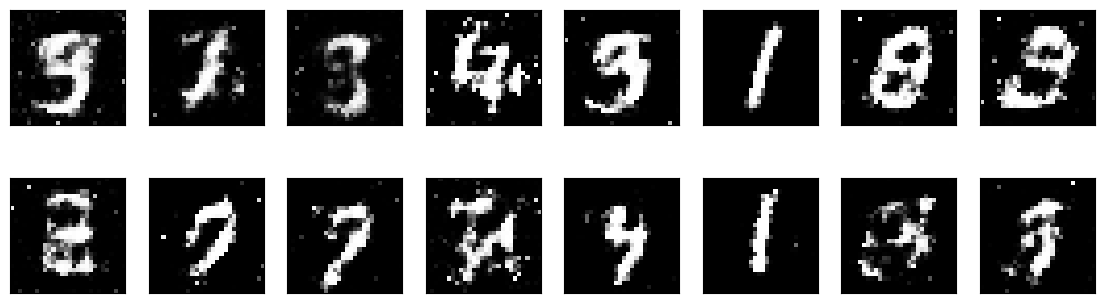

2024-01-01 09:42:56 | Epoch [61/150] | Batch 0/469 | d_loss: 1.0985 | g_loss: 1.4773
2024-01-01 09:42:58 | Epoch [61/150] | Batch 100/469 | d_loss: 1.0774 | g_loss: 1.4424
2024-01-01 09:42:59 | Epoch [61/150] | Batch 200/469 | d_loss: 0.9964 | g_loss: 1.3855
2024-01-01 09:43:01 | Epoch [61/150] | Batch 300/469 | d_loss: 1.2138 | g_loss: 1.5146
2024-01-01 09:43:02 | Epoch [61/150] | Batch 400/469 | d_loss: 1.0382 | g_loss: 1.7350


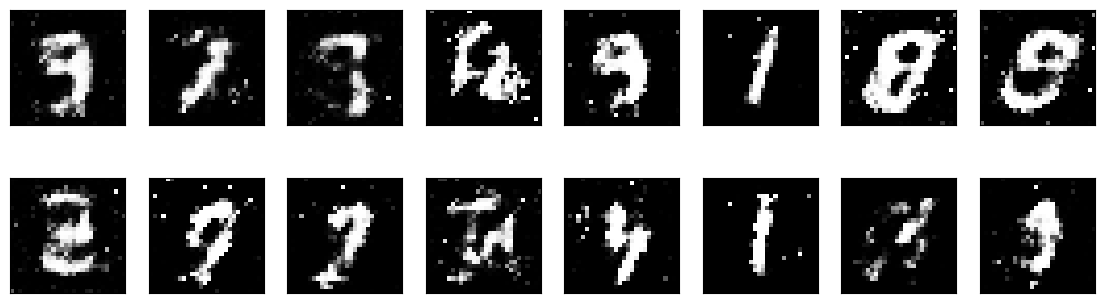

2024-01-01 09:43:06 | Epoch [62/150] | Batch 0/469 | d_loss: 1.1116 | g_loss: 1.2733
2024-01-01 09:43:08 | Epoch [62/150] | Batch 100/469 | d_loss: 1.1041 | g_loss: 1.6212
2024-01-01 09:43:09 | Epoch [62/150] | Batch 200/469 | d_loss: 1.0784 | g_loss: 1.3967
2024-01-01 09:43:11 | Epoch [62/150] | Batch 300/469 | d_loss: 1.0867 | g_loss: 1.3446
2024-01-01 09:43:12 | Epoch [62/150] | Batch 400/469 | d_loss: 1.1798 | g_loss: 1.1361


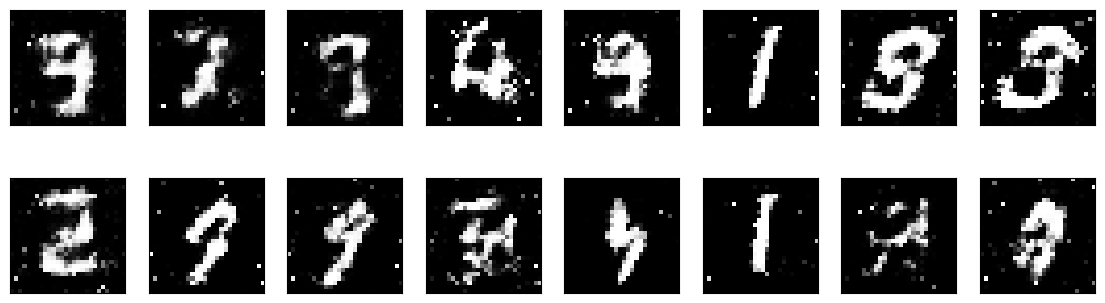

2024-01-01 09:43:16 | Epoch [63/150] | Batch 0/469 | d_loss: 1.1040 | g_loss: 1.5008
2024-01-01 09:43:17 | Epoch [63/150] | Batch 100/469 | d_loss: 1.1815 | g_loss: 1.4210
2024-01-01 09:43:19 | Epoch [63/150] | Batch 200/469 | d_loss: 1.0330 | g_loss: 1.5044
2024-01-01 09:43:20 | Epoch [63/150] | Batch 300/469 | d_loss: 1.0472 | g_loss: 1.4707
2024-01-01 09:43:22 | Epoch [63/150] | Batch 400/469 | d_loss: 1.2205 | g_loss: 1.1080


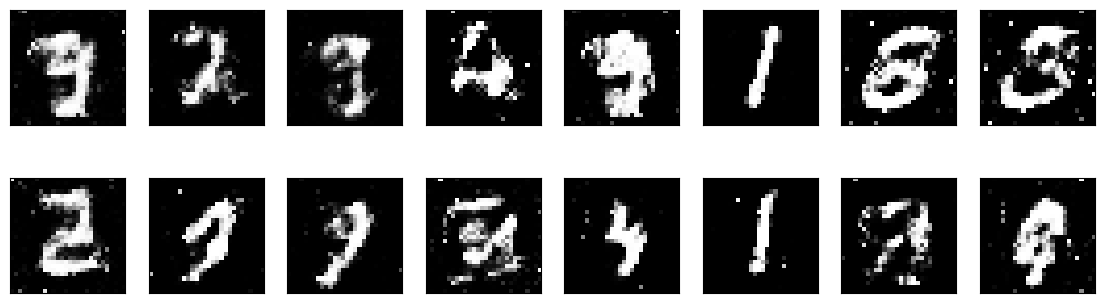

2024-01-01 09:43:26 | Epoch [64/150] | Batch 0/469 | d_loss: 1.0595 | g_loss: 1.6146
2024-01-01 09:43:27 | Epoch [64/150] | Batch 100/469 | d_loss: 1.1784 | g_loss: 1.4240
2024-01-01 09:43:28 | Epoch [64/150] | Batch 200/469 | d_loss: 1.0148 | g_loss: 1.5392
2024-01-01 09:43:30 | Epoch [64/150] | Batch 300/469 | d_loss: 1.1310 | g_loss: 1.6381
2024-01-01 09:43:31 | Epoch [64/150] | Batch 400/469 | d_loss: 1.2087 | g_loss: 1.3263


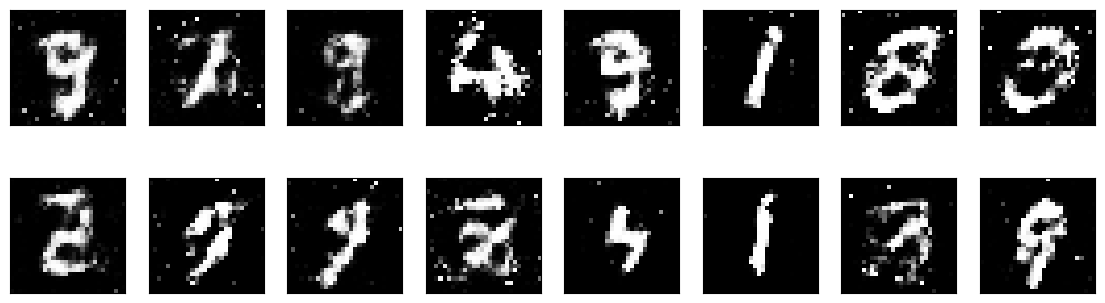

2024-01-01 09:43:36 | Epoch [65/150] | Batch 0/469 | d_loss: 0.9580 | g_loss: 1.5905
2024-01-01 09:43:37 | Epoch [65/150] | Batch 100/469 | d_loss: 1.1279 | g_loss: 1.2501
2024-01-01 09:43:38 | Epoch [65/150] | Batch 200/469 | d_loss: 1.0910 | g_loss: 1.3257
2024-01-01 09:43:40 | Epoch [65/150] | Batch 300/469 | d_loss: 1.1096 | g_loss: 1.4672
2024-01-01 09:43:41 | Epoch [65/150] | Batch 400/469 | d_loss: 1.1052 | g_loss: 1.2415


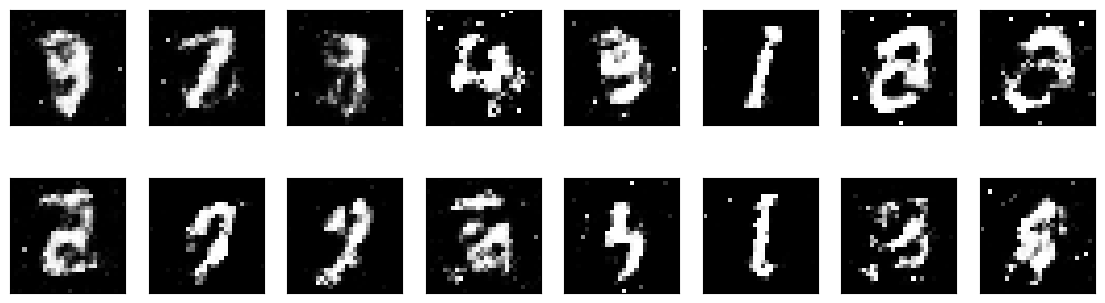

2024-01-01 09:43:46 | Epoch [66/150] | Batch 0/469 | d_loss: 1.0384 | g_loss: 1.4263
2024-01-01 09:43:48 | Epoch [66/150] | Batch 100/469 | d_loss: 1.0981 | g_loss: 1.5908
2024-01-01 09:43:49 | Epoch [66/150] | Batch 200/469 | d_loss: 1.1240 | g_loss: 1.6183
2024-01-01 09:43:51 | Epoch [66/150] | Batch 300/469 | d_loss: 1.1495 | g_loss: 1.5283
2024-01-01 09:43:52 | Epoch [66/150] | Batch 400/469 | d_loss: 1.0292 | g_loss: 1.3647


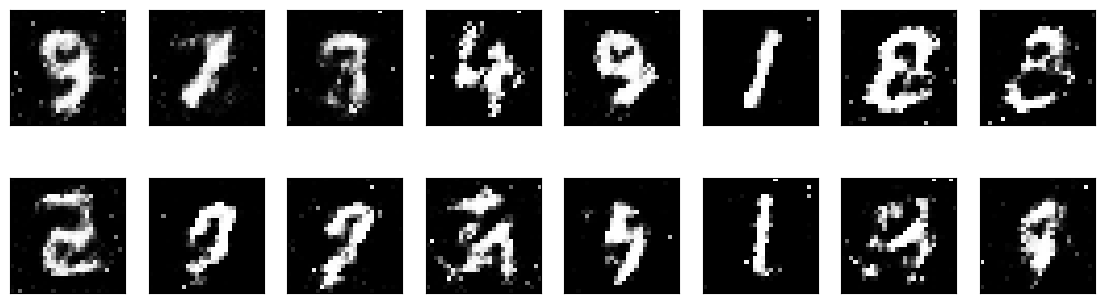

2024-01-01 09:43:57 | Epoch [67/150] | Batch 0/469 | d_loss: 1.0879 | g_loss: 1.4948
2024-01-01 09:43:58 | Epoch [67/150] | Batch 100/469 | d_loss: 1.0926 | g_loss: 1.5675
2024-01-01 09:43:59 | Epoch [67/150] | Batch 200/469 | d_loss: 1.0429 | g_loss: 1.5807
2024-01-01 09:44:01 | Epoch [67/150] | Batch 300/469 | d_loss: 1.1253 | g_loss: 1.4953
2024-01-01 09:44:02 | Epoch [67/150] | Batch 400/469 | d_loss: 1.0187 | g_loss: 1.4585


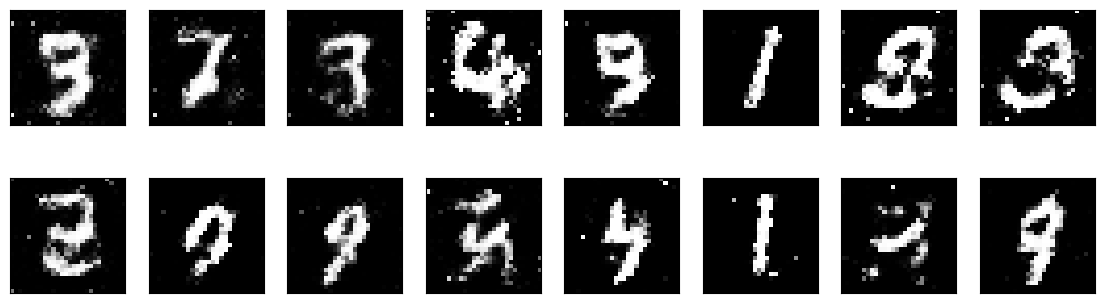

2024-01-01 09:44:06 | Epoch [68/150] | Batch 0/469 | d_loss: 1.0353 | g_loss: 1.3963
2024-01-01 09:44:08 | Epoch [68/150] | Batch 100/469 | d_loss: 1.0631 | g_loss: 1.3855
2024-01-01 09:44:09 | Epoch [68/150] | Batch 200/469 | d_loss: 1.0388 | g_loss: 1.5731
2024-01-01 09:44:11 | Epoch [68/150] | Batch 300/469 | d_loss: 1.0493 | g_loss: 1.6236
2024-01-01 09:44:12 | Epoch [68/150] | Batch 400/469 | d_loss: 1.1875 | g_loss: 1.4579


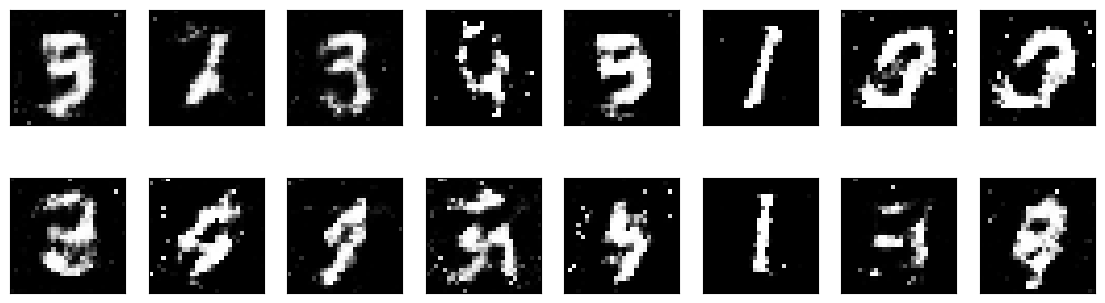

2024-01-01 09:44:16 | Epoch [69/150] | Batch 0/469 | d_loss: 1.1293 | g_loss: 1.4424
2024-01-01 09:44:18 | Epoch [69/150] | Batch 100/469 | d_loss: 1.0994 | g_loss: 1.5712
2024-01-01 09:44:19 | Epoch [69/150] | Batch 200/469 | d_loss: 1.0752 | g_loss: 1.3709
2024-01-01 09:44:21 | Epoch [69/150] | Batch 300/469 | d_loss: 1.2069 | g_loss: 1.4032
2024-01-01 09:44:22 | Epoch [69/150] | Batch 400/469 | d_loss: 1.1632 | g_loss: 1.2996


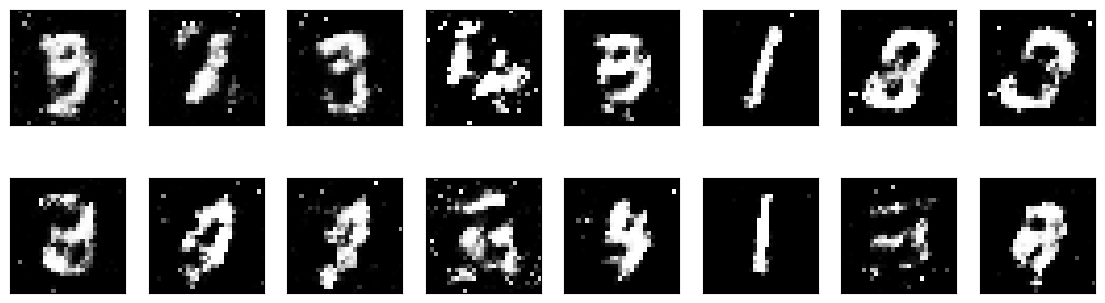

2024-01-01 09:44:26 | Epoch [70/150] | Batch 0/469 | d_loss: 1.1025 | g_loss: 1.3245
2024-01-01 09:44:28 | Epoch [70/150] | Batch 100/469 | d_loss: 1.0628 | g_loss: 1.5227
2024-01-01 09:44:29 | Epoch [70/150] | Batch 200/469 | d_loss: 1.0889 | g_loss: 1.4876
2024-01-01 09:44:31 | Epoch [70/150] | Batch 300/469 | d_loss: 1.1401 | g_loss: 1.4214
2024-01-01 09:44:32 | Epoch [70/150] | Batch 400/469 | d_loss: 1.1190 | g_loss: 1.5032


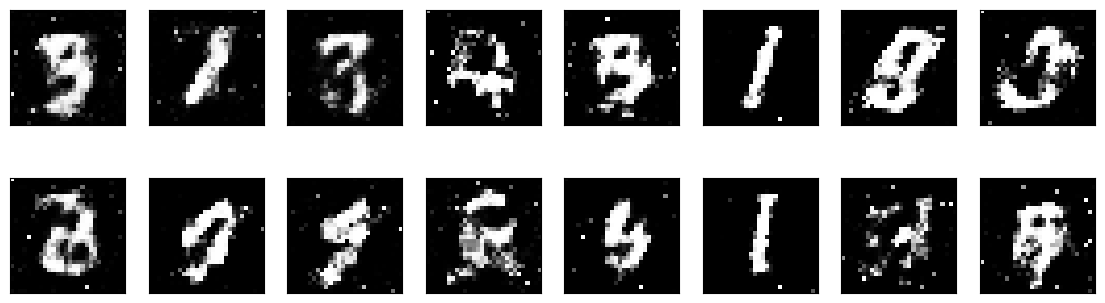

2024-01-01 09:44:36 | Epoch [71/150] | Batch 0/469 | d_loss: 1.0615 | g_loss: 1.4810
2024-01-01 09:44:38 | Epoch [71/150] | Batch 100/469 | d_loss: 1.1107 | g_loss: 1.3347
2024-01-01 09:44:39 | Epoch [71/150] | Batch 200/469 | d_loss: 1.0716 | g_loss: 1.4580
2024-01-01 09:44:41 | Epoch [71/150] | Batch 300/469 | d_loss: 1.0770 | g_loss: 1.2209
2024-01-01 09:44:42 | Epoch [71/150] | Batch 400/469 | d_loss: 1.1510 | g_loss: 1.2844


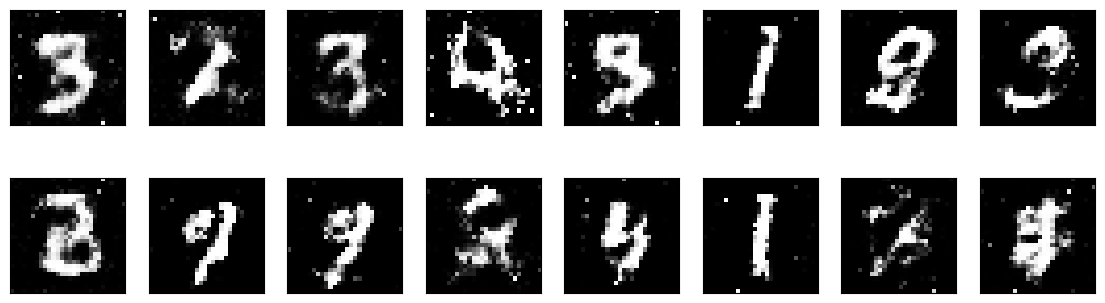

2024-01-01 09:44:46 | Epoch [72/150] | Batch 0/469 | d_loss: 1.1065 | g_loss: 1.3863
2024-01-01 09:44:47 | Epoch [72/150] | Batch 100/469 | d_loss: 1.1532 | g_loss: 1.4924
2024-01-01 09:44:49 | Epoch [72/150] | Batch 200/469 | d_loss: 1.1679 | g_loss: 1.3038
2024-01-01 09:44:50 | Epoch [72/150] | Batch 300/469 | d_loss: 1.1187 | g_loss: 1.3020
2024-01-01 09:44:52 | Epoch [72/150] | Batch 400/469 | d_loss: 1.1012 | g_loss: 1.4123


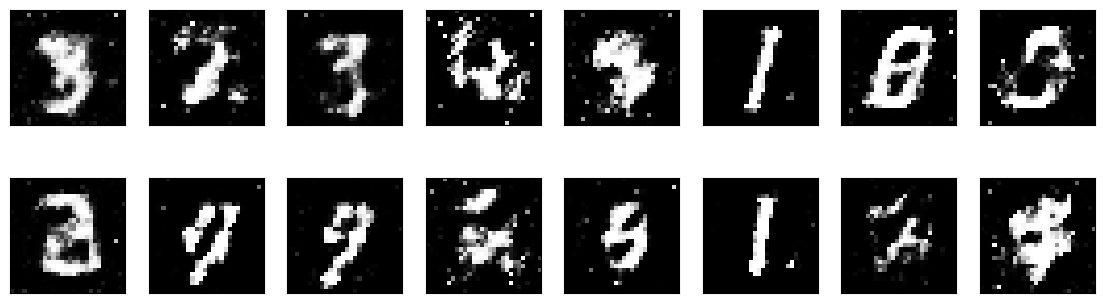

2024-01-01 09:44:56 | Epoch [73/150] | Batch 0/469 | d_loss: 1.0904 | g_loss: 1.4751
2024-01-01 09:44:57 | Epoch [73/150] | Batch 100/469 | d_loss: 1.0921 | g_loss: 1.3675
2024-01-01 09:44:59 | Epoch [73/150] | Batch 200/469 | d_loss: 1.0539 | g_loss: 1.4855
2024-01-01 09:45:00 | Epoch [73/150] | Batch 300/469 | d_loss: 1.0549 | g_loss: 1.4410
2024-01-01 09:45:01 | Epoch [73/150] | Batch 400/469 | d_loss: 1.2212 | g_loss: 1.2553


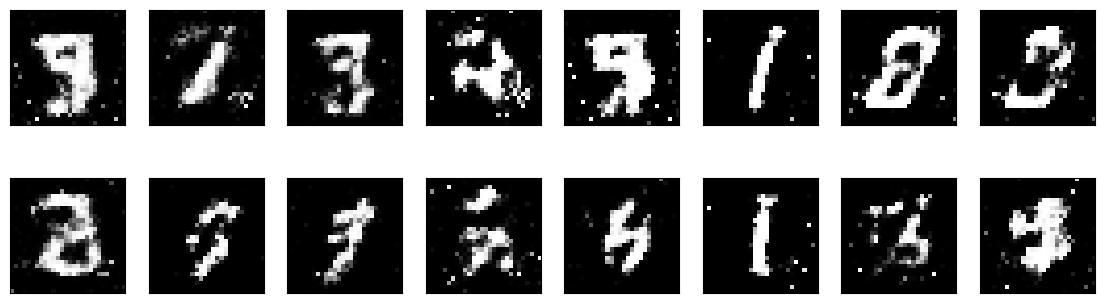

2024-01-01 09:45:06 | Epoch [74/150] | Batch 0/469 | d_loss: 0.9916 | g_loss: 1.3101
2024-01-01 09:45:07 | Epoch [74/150] | Batch 100/469 | d_loss: 1.1716 | g_loss: 1.5173
2024-01-01 09:45:09 | Epoch [74/150] | Batch 200/469 | d_loss: 1.1889 | g_loss: 1.4048
2024-01-01 09:45:10 | Epoch [74/150] | Batch 300/469 | d_loss: 1.1462 | g_loss: 1.1913
2024-01-01 09:45:12 | Epoch [74/150] | Batch 400/469 | d_loss: 1.1505 | g_loss: 1.3561


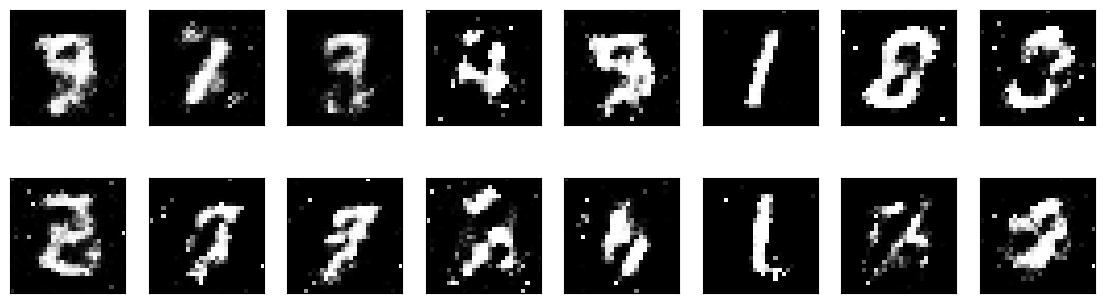

2024-01-01 09:45:15 | Epoch [75/150] | Batch 0/469 | d_loss: 1.1186 | g_loss: 1.3776
2024-01-01 09:45:17 | Epoch [75/150] | Batch 100/469 | d_loss: 1.1598 | g_loss: 1.5875
2024-01-01 09:45:18 | Epoch [75/150] | Batch 200/469 | d_loss: 1.0921 | g_loss: 1.2671
2024-01-01 09:45:20 | Epoch [75/150] | Batch 300/469 | d_loss: 1.0674 | g_loss: 1.3702
2024-01-01 09:45:21 | Epoch [75/150] | Batch 400/469 | d_loss: 1.1192 | g_loss: 1.3161


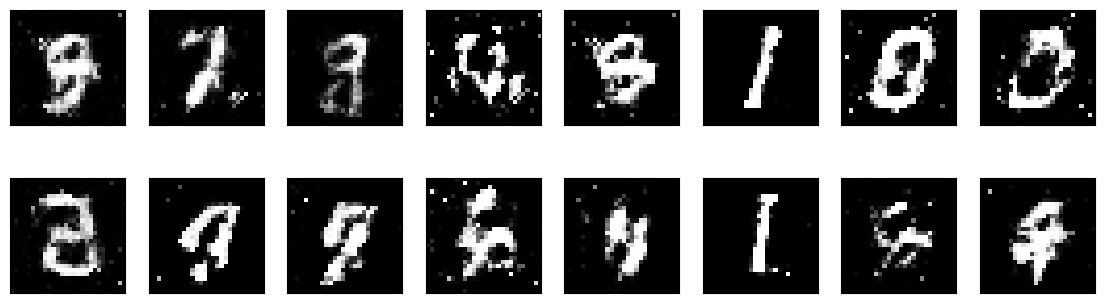

2024-01-01 09:45:25 | Epoch [76/150] | Batch 0/469 | d_loss: 1.0480 | g_loss: 1.4280
2024-01-01 09:45:27 | Epoch [76/150] | Batch 100/469 | d_loss: 1.1865 | g_loss: 1.3116
2024-01-01 09:45:28 | Epoch [76/150] | Batch 200/469 | d_loss: 1.0733 | g_loss: 1.4139
2024-01-01 09:45:30 | Epoch [76/150] | Batch 300/469 | d_loss: 1.1731 | g_loss: 1.0977
2024-01-01 09:45:31 | Epoch [76/150] | Batch 400/469 | d_loss: 1.1017 | g_loss: 1.3992


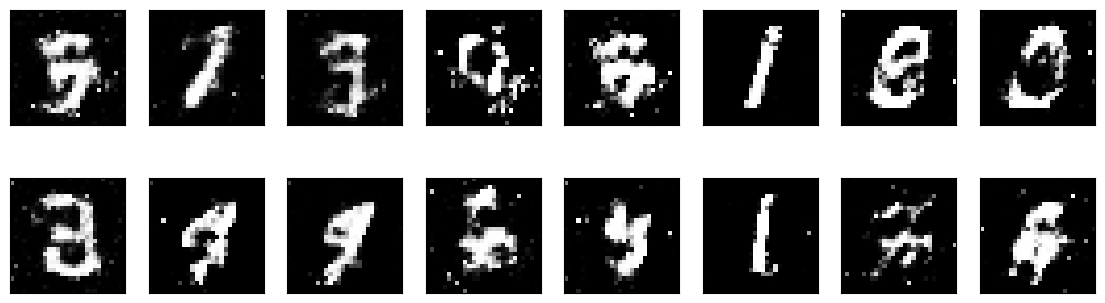

2024-01-01 09:45:35 | Epoch [77/150] | Batch 0/469 | d_loss: 1.1015 | g_loss: 1.2702
2024-01-01 09:45:37 | Epoch [77/150] | Batch 100/469 | d_loss: 1.1934 | g_loss: 1.2025
2024-01-01 09:45:38 | Epoch [77/150] | Batch 200/469 | d_loss: 1.1048 | g_loss: 1.4170
2024-01-01 09:45:40 | Epoch [77/150] | Batch 300/469 | d_loss: 1.1320 | g_loss: 1.3038
2024-01-01 09:45:41 | Epoch [77/150] | Batch 400/469 | d_loss: 1.1651 | g_loss: 1.3954


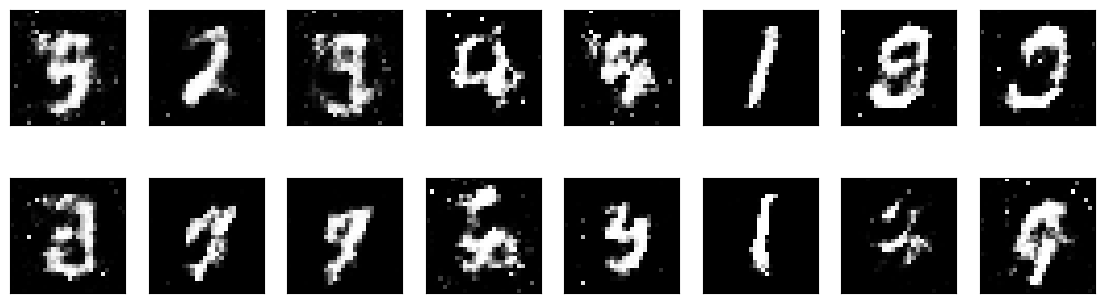

2024-01-01 09:45:45 | Epoch [78/150] | Batch 0/469 | d_loss: 1.1462 | g_loss: 1.3633
2024-01-01 09:45:47 | Epoch [78/150] | Batch 100/469 | d_loss: 1.1432 | g_loss: 1.3492
2024-01-01 09:45:48 | Epoch [78/150] | Batch 200/469 | d_loss: 1.1082 | g_loss: 1.2579
2024-01-01 09:45:50 | Epoch [78/150] | Batch 300/469 | d_loss: 1.1833 | g_loss: 1.4339
2024-01-01 09:45:51 | Epoch [78/150] | Batch 400/469 | d_loss: 1.2236 | g_loss: 1.1973


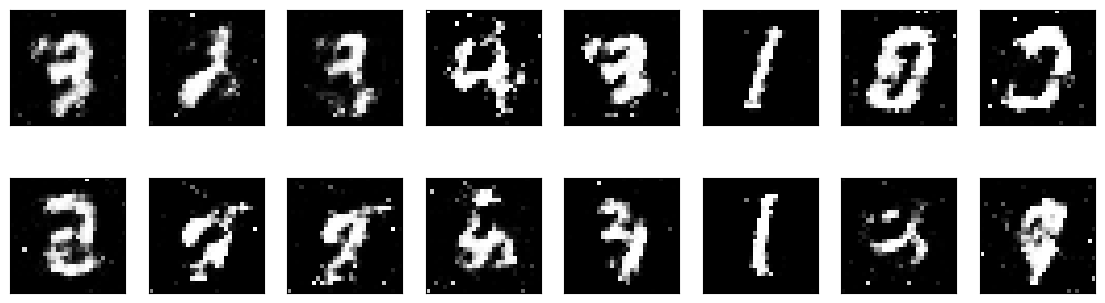

2024-01-01 09:45:55 | Epoch [79/150] | Batch 0/469 | d_loss: 1.1218 | g_loss: 1.3378
2024-01-01 09:45:57 | Epoch [79/150] | Batch 100/469 | d_loss: 1.1658 | g_loss: 1.3771
2024-01-01 09:45:58 | Epoch [79/150] | Batch 200/469 | d_loss: 1.0699 | g_loss: 1.4137
2024-01-01 09:46:00 | Epoch [79/150] | Batch 300/469 | d_loss: 1.1699 | g_loss: 1.2736
2024-01-01 09:46:01 | Epoch [79/150] | Batch 400/469 | d_loss: 1.1849 | g_loss: 1.3842


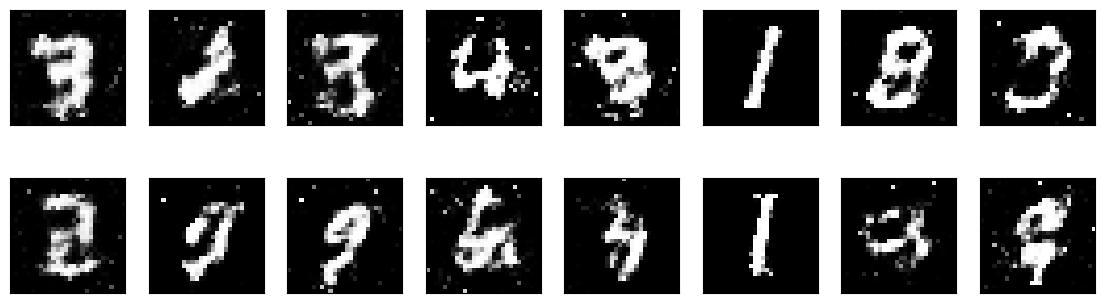

2024-01-01 09:46:05 | Epoch [80/150] | Batch 0/469 | d_loss: 1.1474 | g_loss: 1.3508
2024-01-01 09:46:06 | Epoch [80/150] | Batch 100/469 | d_loss: 1.1495 | g_loss: 1.2268
2024-01-01 09:46:08 | Epoch [80/150] | Batch 200/469 | d_loss: 1.0457 | g_loss: 1.4119
2024-01-01 09:46:09 | Epoch [80/150] | Batch 300/469 | d_loss: 1.1889 | g_loss: 1.4853
2024-01-01 09:46:11 | Epoch [80/150] | Batch 400/469 | d_loss: 1.0632 | g_loss: 1.4796


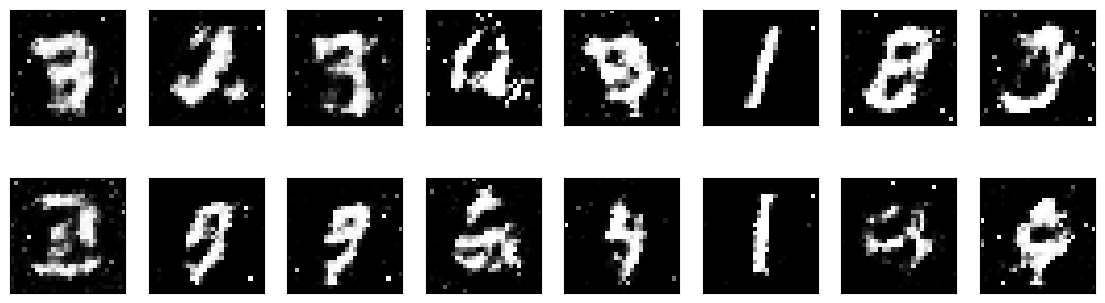

2024-01-01 09:46:15 | Epoch [81/150] | Batch 0/469 | d_loss: 1.1749 | g_loss: 1.1480
2024-01-01 09:46:17 | Epoch [81/150] | Batch 100/469 | d_loss: 1.0453 | g_loss: 1.4848
2024-01-01 09:46:18 | Epoch [81/150] | Batch 200/469 | d_loss: 1.1611 | g_loss: 1.1281
2024-01-01 09:46:20 | Epoch [81/150] | Batch 300/469 | d_loss: 1.1383 | g_loss: 1.3731
2024-01-01 09:46:21 | Epoch [81/150] | Batch 400/469 | d_loss: 1.1010 | g_loss: 1.3064


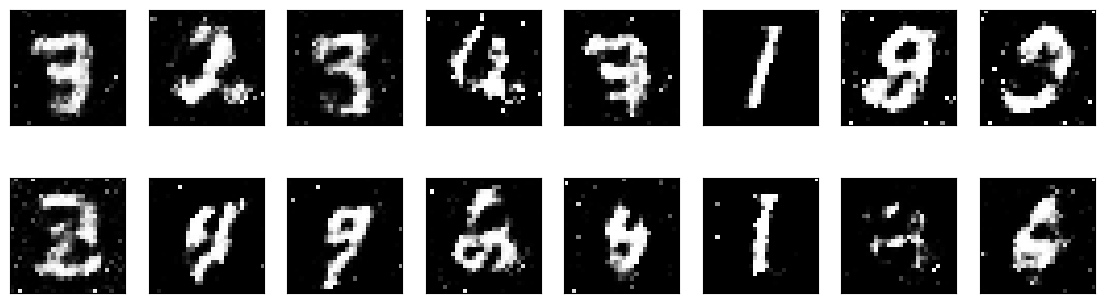

2024-01-01 09:46:25 | Epoch [82/150] | Batch 0/469 | d_loss: 1.0979 | g_loss: 1.3611
2024-01-01 09:46:27 | Epoch [82/150] | Batch 100/469 | d_loss: 1.0724 | g_loss: 1.4779
2024-01-01 09:46:28 | Epoch [82/150] | Batch 200/469 | d_loss: 1.0692 | g_loss: 1.3605
2024-01-01 09:46:29 | Epoch [82/150] | Batch 300/469 | d_loss: 1.1435 | g_loss: 1.1891
2024-01-01 09:46:31 | Epoch [82/150] | Batch 400/469 | d_loss: 1.0817 | g_loss: 1.2814


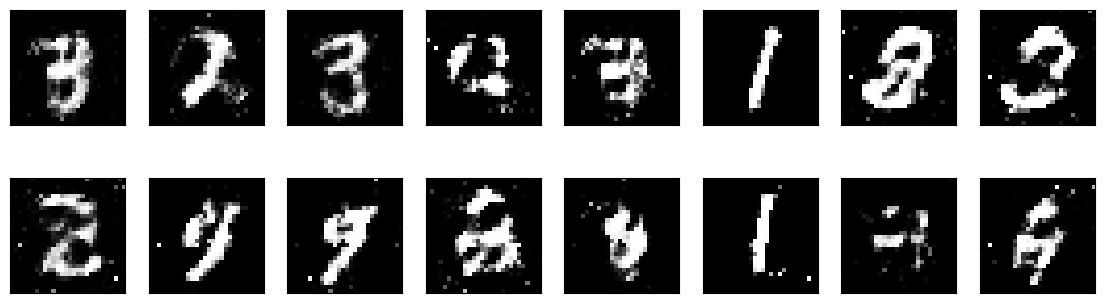

2024-01-01 09:46:34 | Epoch [83/150] | Batch 0/469 | d_loss: 1.0091 | g_loss: 1.3640
2024-01-01 09:46:35 | Epoch [83/150] | Batch 100/469 | d_loss: 1.0711 | g_loss: 1.4533
2024-01-01 09:46:37 | Epoch [83/150] | Batch 200/469 | d_loss: 1.1205 | g_loss: 1.5042
2024-01-01 09:46:38 | Epoch [83/150] | Batch 300/469 | d_loss: 1.0255 | g_loss: 1.5305
2024-01-01 09:46:39 | Epoch [83/150] | Batch 400/469 | d_loss: 1.1313 | g_loss: 1.3118


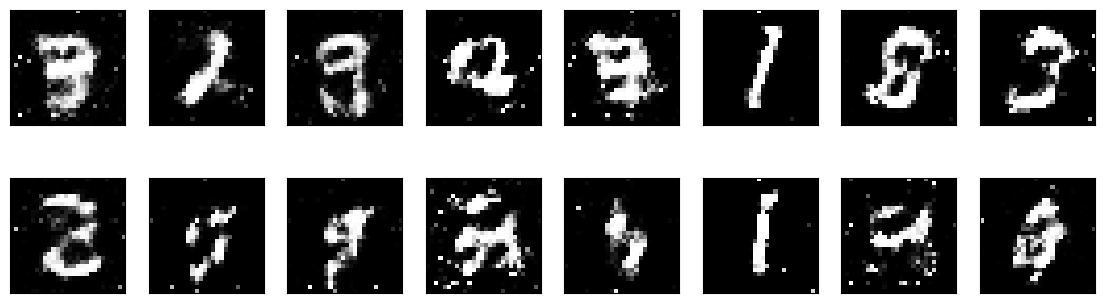

2024-01-01 09:46:43 | Epoch [84/150] | Batch 0/469 | d_loss: 1.0177 | g_loss: 1.6160
2024-01-01 09:46:44 | Epoch [84/150] | Batch 100/469 | d_loss: 1.0959 | g_loss: 1.4619
2024-01-01 09:46:45 | Epoch [84/150] | Batch 200/469 | d_loss: 1.0598 | g_loss: 1.4694
2024-01-01 09:46:46 | Epoch [84/150] | Batch 300/469 | d_loss: 1.1542 | g_loss: 1.5709
2024-01-01 09:46:47 | Epoch [84/150] | Batch 400/469 | d_loss: 1.0865 | g_loss: 1.3993


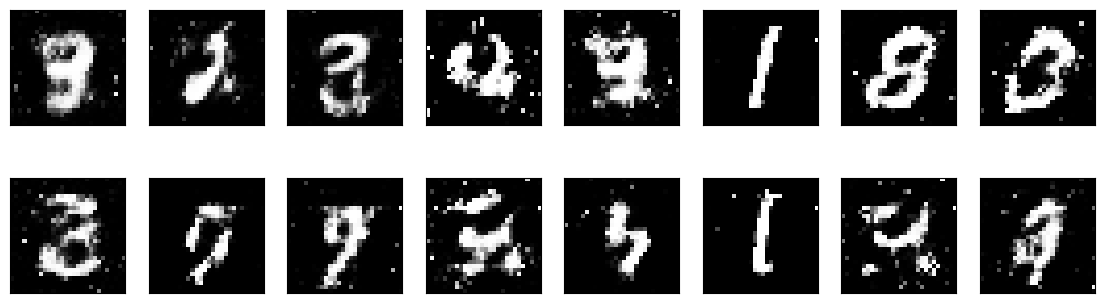

2024-01-01 09:46:51 | Epoch [85/150] | Batch 0/469 | d_loss: 1.0817 | g_loss: 1.3328
2024-01-01 09:46:52 | Epoch [85/150] | Batch 100/469 | d_loss: 1.1062 | g_loss: 1.3308
2024-01-01 09:46:53 | Epoch [85/150] | Batch 200/469 | d_loss: 1.0927 | g_loss: 1.4194
2024-01-01 09:46:55 | Epoch [85/150] | Batch 300/469 | d_loss: 1.1703 | g_loss: 1.4235
2024-01-01 09:46:56 | Epoch [85/150] | Batch 400/469 | d_loss: 1.2464 | g_loss: 1.2426


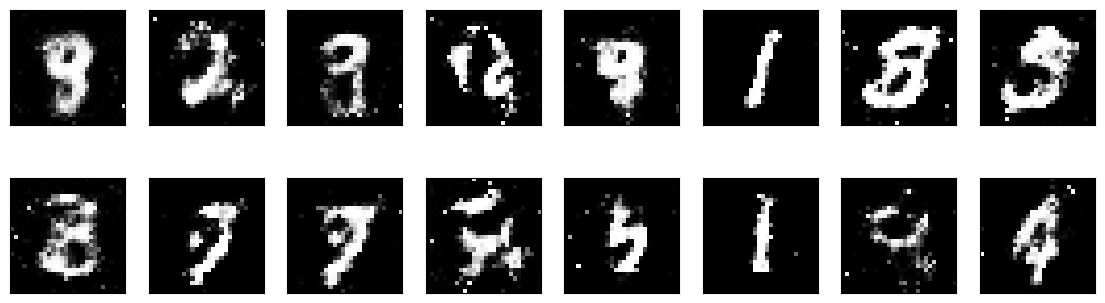

2024-01-01 09:46:59 | Epoch [86/150] | Batch 0/469 | d_loss: 1.0568 | g_loss: 1.4411
2024-01-01 09:47:01 | Epoch [86/150] | Batch 100/469 | d_loss: 1.0871 | g_loss: 1.5925
2024-01-01 09:47:02 | Epoch [86/150] | Batch 200/469 | d_loss: 1.1166 | g_loss: 1.5066
2024-01-01 09:47:03 | Epoch [86/150] | Batch 300/469 | d_loss: 1.1541 | g_loss: 1.1671
2024-01-01 09:47:04 | Epoch [86/150] | Batch 400/469 | d_loss: 1.0952 | g_loss: 1.1905


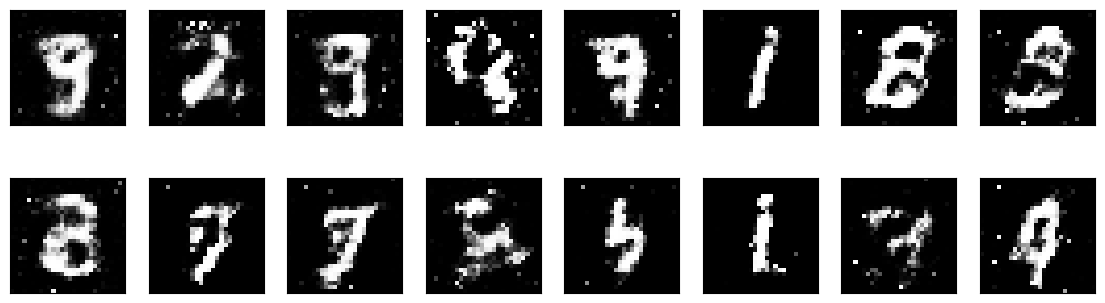

2024-01-01 09:47:08 | Epoch [87/150] | Batch 0/469 | d_loss: 1.0794 | g_loss: 1.4496
2024-01-01 09:47:09 | Epoch [87/150] | Batch 100/469 | d_loss: 1.1373 | g_loss: 1.2816
2024-01-01 09:47:10 | Epoch [87/150] | Batch 200/469 | d_loss: 1.1697 | g_loss: 1.3235
2024-01-01 09:47:12 | Epoch [87/150] | Batch 300/469 | d_loss: 1.1411 | g_loss: 1.3907
2024-01-01 09:47:13 | Epoch [87/150] | Batch 400/469 | d_loss: 1.0568 | g_loss: 1.4118


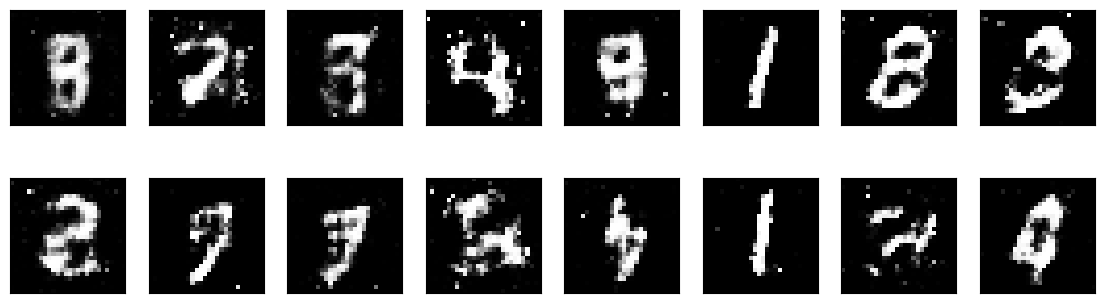

2024-01-01 09:47:17 | Epoch [88/150] | Batch 0/469 | d_loss: 1.1230 | g_loss: 1.5284
2024-01-01 09:47:19 | Epoch [88/150] | Batch 100/469 | d_loss: 1.1729 | g_loss: 1.2502
2024-01-01 09:47:20 | Epoch [88/150] | Batch 200/469 | d_loss: 1.0243 | g_loss: 1.4346
2024-01-01 09:47:22 | Epoch [88/150] | Batch 300/469 | d_loss: 1.1228 | g_loss: 1.4218
2024-01-01 09:47:23 | Epoch [88/150] | Batch 400/469 | d_loss: 1.1415 | g_loss: 1.1179


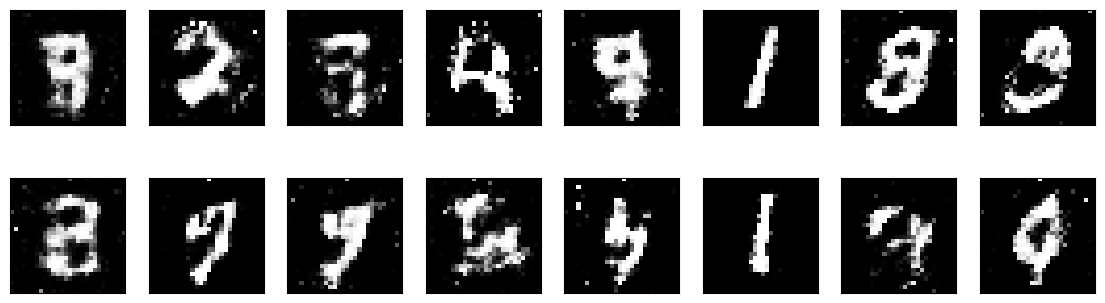

2024-01-01 09:47:27 | Epoch [89/150] | Batch 0/469 | d_loss: 1.1052 | g_loss: 1.4534
2024-01-01 09:47:29 | Epoch [89/150] | Batch 100/469 | d_loss: 1.1569 | g_loss: 1.4354
2024-01-01 09:47:30 | Epoch [89/150] | Batch 200/469 | d_loss: 1.0569 | g_loss: 1.2029
2024-01-01 09:47:32 | Epoch [89/150] | Batch 300/469 | d_loss: 1.1672 | g_loss: 1.1628
2024-01-01 09:47:33 | Epoch [89/150] | Batch 400/469 | d_loss: 1.2096 | g_loss: 1.3264


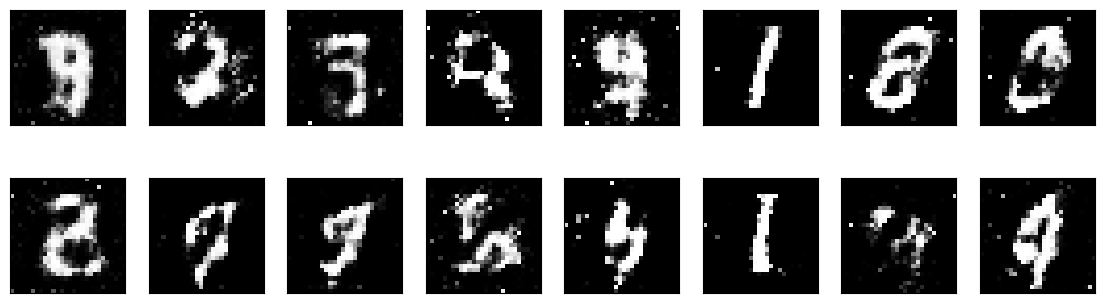

2024-01-01 09:47:37 | Epoch [90/150] | Batch 0/469 | d_loss: 1.1071 | g_loss: 1.3946
2024-01-01 09:47:38 | Epoch [90/150] | Batch 100/469 | d_loss: 1.1849 | g_loss: 1.3804
2024-01-01 09:47:40 | Epoch [90/150] | Batch 200/469 | d_loss: 1.1726 | g_loss: 1.2262
2024-01-01 09:47:41 | Epoch [90/150] | Batch 300/469 | d_loss: 1.1582 | g_loss: 1.1138
2024-01-01 09:47:43 | Epoch [90/150] | Batch 400/469 | d_loss: 1.1628 | g_loss: 1.4008


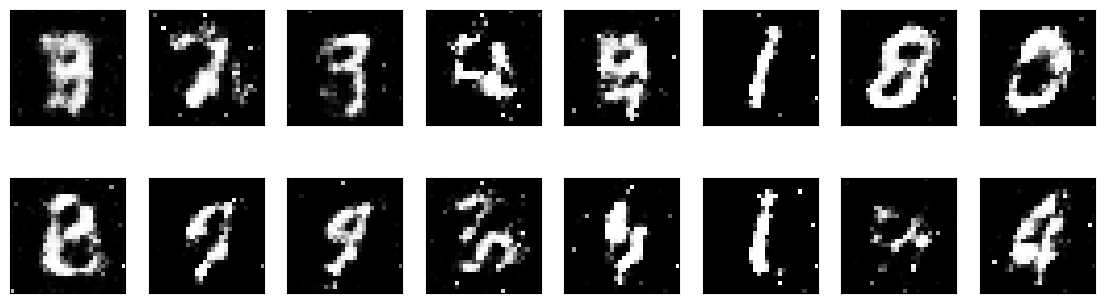

2024-01-01 09:47:47 | Epoch [91/150] | Batch 0/469 | d_loss: 1.1537 | g_loss: 1.5555
2024-01-01 09:47:48 | Epoch [91/150] | Batch 100/469 | d_loss: 1.0481 | g_loss: 1.6205
2024-01-01 09:47:50 | Epoch [91/150] | Batch 200/469 | d_loss: 1.1965 | g_loss: 1.1720
2024-01-01 09:47:51 | Epoch [91/150] | Batch 300/469 | d_loss: 1.1022 | g_loss: 1.2853
2024-01-01 09:47:53 | Epoch [91/150] | Batch 400/469 | d_loss: 1.0114 | g_loss: 1.3572


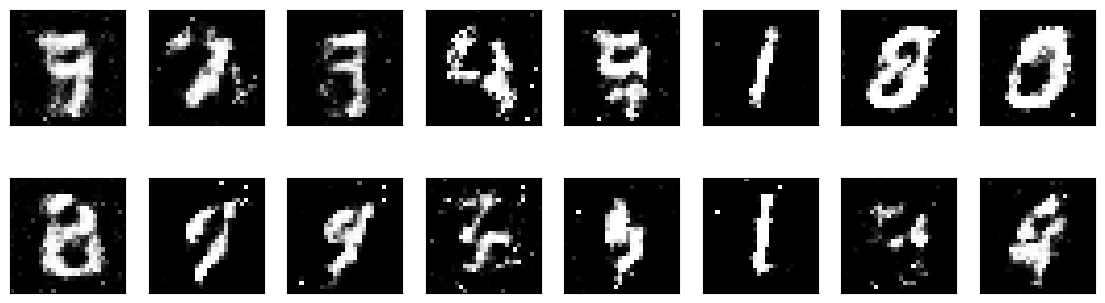

2024-01-01 09:47:57 | Epoch [92/150] | Batch 0/469 | d_loss: 1.1272 | g_loss: 1.3465
2024-01-01 09:47:58 | Epoch [92/150] | Batch 100/469 | d_loss: 0.9971 | g_loss: 1.6012
2024-01-01 09:48:00 | Epoch [92/150] | Batch 200/469 | d_loss: 1.1546 | g_loss: 1.3613
2024-01-01 09:48:01 | Epoch [92/150] | Batch 300/469 | d_loss: 1.2039 | g_loss: 1.2182
2024-01-01 09:48:03 | Epoch [92/150] | Batch 400/469 | d_loss: 1.0354 | g_loss: 1.3394


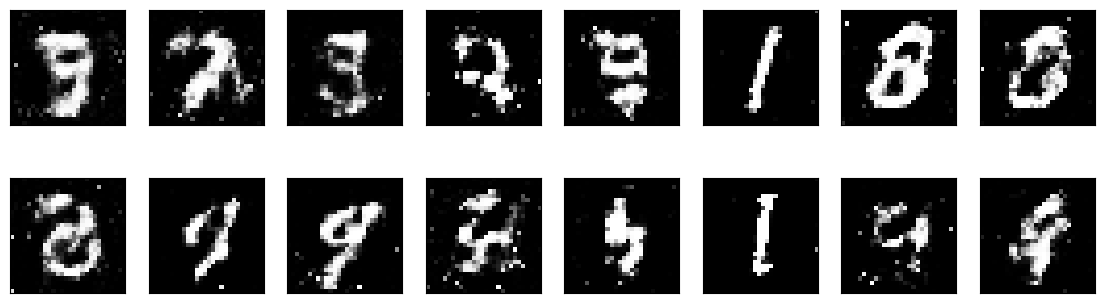

2024-01-01 09:48:06 | Epoch [93/150] | Batch 0/469 | d_loss: 1.0648 | g_loss: 1.4280
2024-01-01 09:48:08 | Epoch [93/150] | Batch 100/469 | d_loss: 1.0507 | g_loss: 1.6886
2024-01-01 09:48:09 | Epoch [93/150] | Batch 200/469 | d_loss: 1.1590 | g_loss: 1.3530
2024-01-01 09:48:11 | Epoch [93/150] | Batch 300/469 | d_loss: 1.2068 | g_loss: 1.4384
2024-01-01 09:48:12 | Epoch [93/150] | Batch 400/469 | d_loss: 1.2830 | g_loss: 1.2677


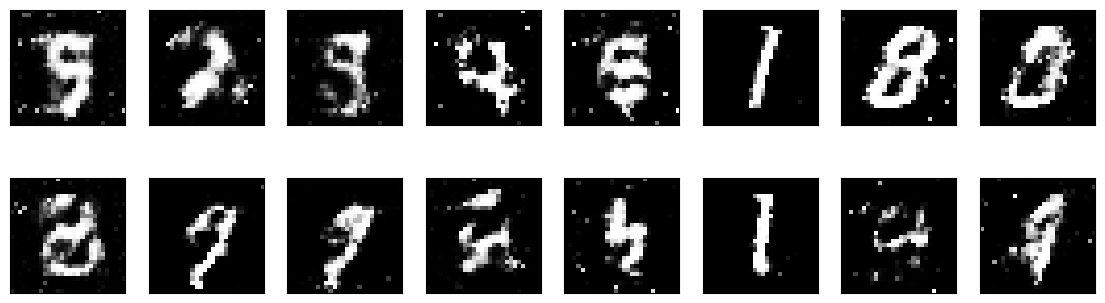

2024-01-01 09:48:16 | Epoch [94/150] | Batch 0/469 | d_loss: 1.1238 | g_loss: 1.2525
2024-01-01 09:48:18 | Epoch [94/150] | Batch 100/469 | d_loss: 1.0997 | g_loss: 1.3010
2024-01-01 09:48:19 | Epoch [94/150] | Batch 200/469 | d_loss: 1.0881 | g_loss: 1.4771
2024-01-01 09:48:21 | Epoch [94/150] | Batch 300/469 | d_loss: 1.0739 | g_loss: 1.2476
2024-01-01 09:48:22 | Epoch [94/150] | Batch 400/469 | d_loss: 1.1970 | g_loss: 1.2114


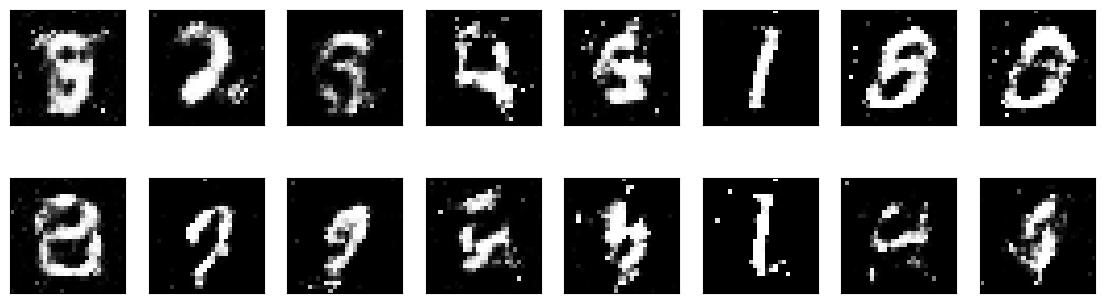

2024-01-01 09:48:26 | Epoch [95/150] | Batch 0/469 | d_loss: 1.1417 | g_loss: 1.5661
2024-01-01 09:48:28 | Epoch [95/150] | Batch 100/469 | d_loss: 1.0818 | g_loss: 1.3780
2024-01-01 09:48:29 | Epoch [95/150] | Batch 200/469 | d_loss: 1.1873 | g_loss: 1.3432
2024-01-01 09:48:30 | Epoch [95/150] | Batch 300/469 | d_loss: 1.2491 | g_loss: 1.3289
2024-01-01 09:48:32 | Epoch [95/150] | Batch 400/469 | d_loss: 1.0697 | g_loss: 1.3754


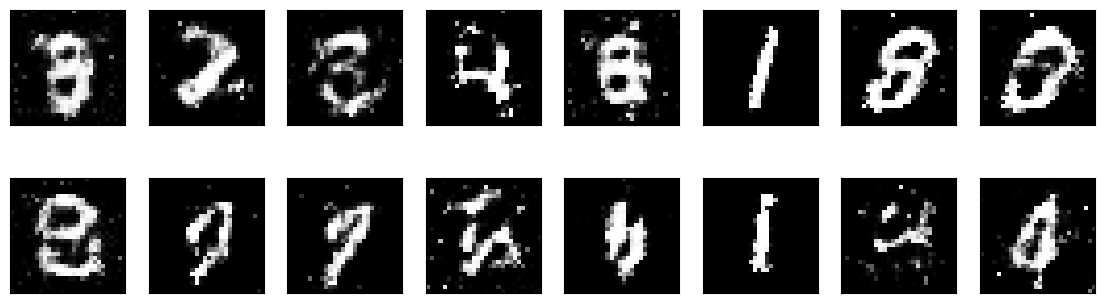

2024-01-01 09:48:36 | Epoch [96/150] | Batch 0/469 | d_loss: 1.1204 | g_loss: 1.4381
2024-01-01 09:48:37 | Epoch [96/150] | Batch 100/469 | d_loss: 1.1579 | g_loss: 1.3174
2024-01-01 09:48:39 | Epoch [96/150] | Batch 200/469 | d_loss: 1.1780 | g_loss: 1.2850
2024-01-01 09:48:40 | Epoch [96/150] | Batch 300/469 | d_loss: 1.2080 | g_loss: 1.2319
2024-01-01 09:48:42 | Epoch [96/150] | Batch 400/469 | d_loss: 1.1594 | g_loss: 1.2783


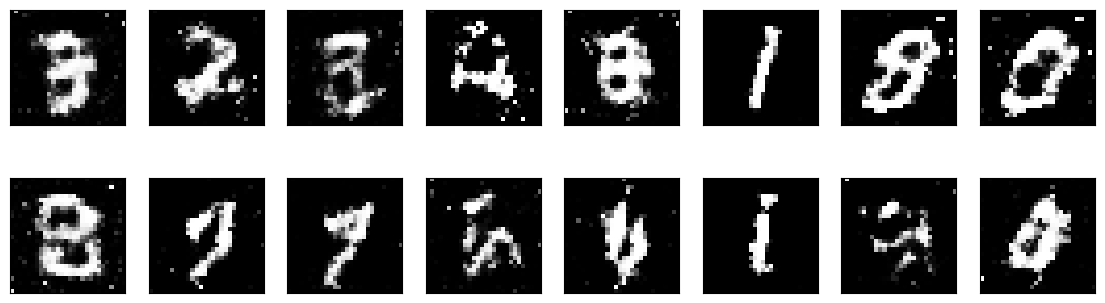

2024-01-01 09:48:45 | Epoch [97/150] | Batch 0/469 | d_loss: 1.1425 | g_loss: 1.4687
2024-01-01 09:48:47 | Epoch [97/150] | Batch 100/469 | d_loss: 1.1745 | g_loss: 1.2225
2024-01-01 09:48:48 | Epoch [97/150] | Batch 200/469 | d_loss: 1.0686 | g_loss: 1.5017
2024-01-01 09:48:50 | Epoch [97/150] | Batch 300/469 | d_loss: 1.1451 | g_loss: 1.4017
2024-01-01 09:48:51 | Epoch [97/150] | Batch 400/469 | d_loss: 1.0794 | g_loss: 1.5375


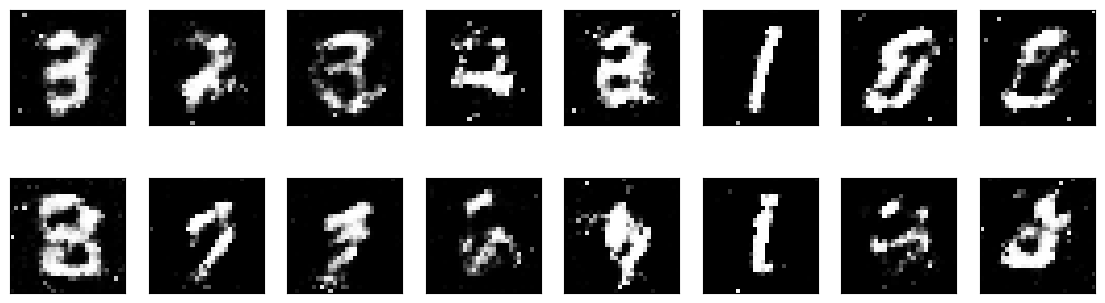

2024-01-01 09:48:55 | Epoch [98/150] | Batch 0/469 | d_loss: 1.0679 | g_loss: 1.4530
2024-01-01 09:48:57 | Epoch [98/150] | Batch 100/469 | d_loss: 1.0657 | g_loss: 1.5506
2024-01-01 09:48:58 | Epoch [98/150] | Batch 200/469 | d_loss: 1.0800 | g_loss: 1.3684
2024-01-01 09:49:00 | Epoch [98/150] | Batch 300/469 | d_loss: 1.1991 | g_loss: 1.1509
2024-01-01 09:49:01 | Epoch [98/150] | Batch 400/469 | d_loss: 1.1190 | g_loss: 1.2592


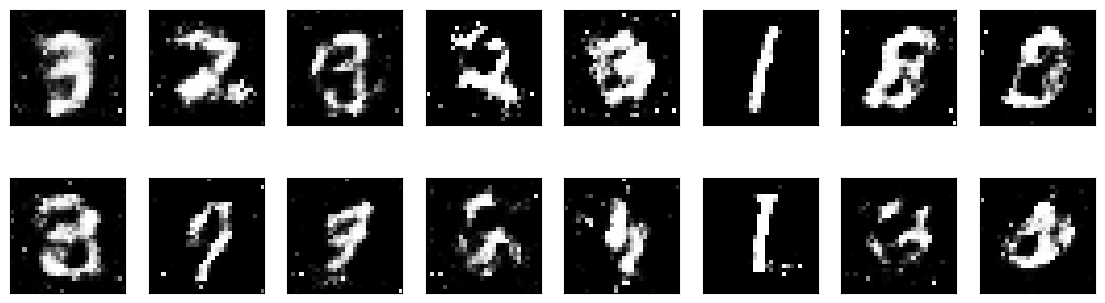

2024-01-01 09:49:05 | Epoch [99/150] | Batch 0/469 | d_loss: 1.2031 | g_loss: 1.1470
2024-01-01 09:49:06 | Epoch [99/150] | Batch 100/469 | d_loss: 1.1781 | g_loss: 1.4916
2024-01-01 09:49:08 | Epoch [99/150] | Batch 200/469 | d_loss: 1.1405 | g_loss: 1.1939
2024-01-01 09:49:09 | Epoch [99/150] | Batch 300/469 | d_loss: 1.0863 | g_loss: 1.4100
2024-01-01 09:49:11 | Epoch [99/150] | Batch 400/469 | d_loss: 1.1515 | g_loss: 1.1830


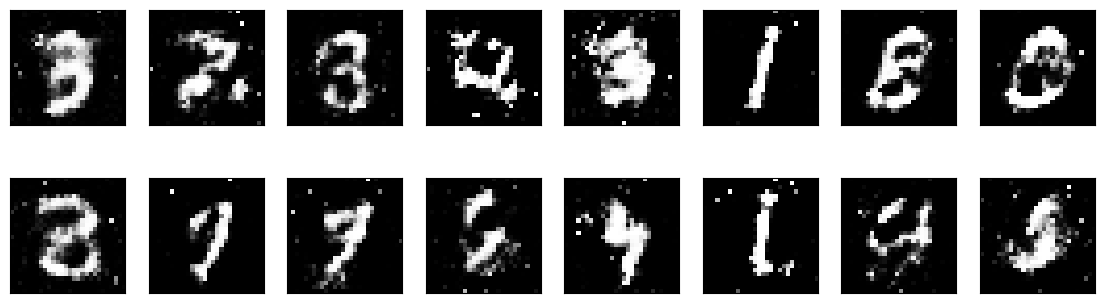

2024-01-01 09:49:15 | Epoch [100/150] | Batch 0/469 | d_loss: 1.0742 | g_loss: 1.4087
2024-01-01 09:49:16 | Epoch [100/150] | Batch 100/469 | d_loss: 1.1229 | g_loss: 1.2382
2024-01-01 09:49:18 | Epoch [100/150] | Batch 200/469 | d_loss: 1.1376 | g_loss: 1.1670
2024-01-01 09:49:19 | Epoch [100/150] | Batch 300/469 | d_loss: 1.2088 | g_loss: 1.2296
2024-01-01 09:49:21 | Epoch [100/150] | Batch 400/469 | d_loss: 1.0814 | g_loss: 1.1697


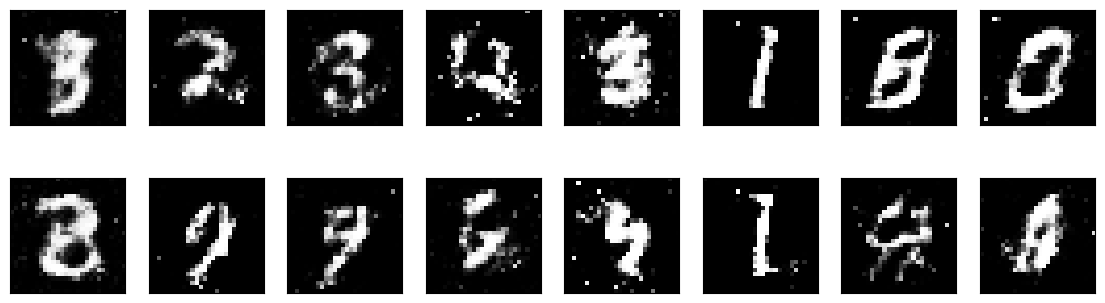

2024-01-01 09:49:25 | Epoch [101/150] | Batch 0/469 | d_loss: 1.1246 | g_loss: 1.3052
2024-01-01 09:49:26 | Epoch [101/150] | Batch 100/469 | d_loss: 1.2251 | g_loss: 1.3361
2024-01-01 09:49:28 | Epoch [101/150] | Batch 200/469 | d_loss: 1.2057 | g_loss: 1.2644
2024-01-01 09:49:29 | Epoch [101/150] | Batch 300/469 | d_loss: 1.2012 | g_loss: 1.1320
2024-01-01 09:49:31 | Epoch [101/150] | Batch 400/469 | d_loss: 1.1665 | g_loss: 1.1345


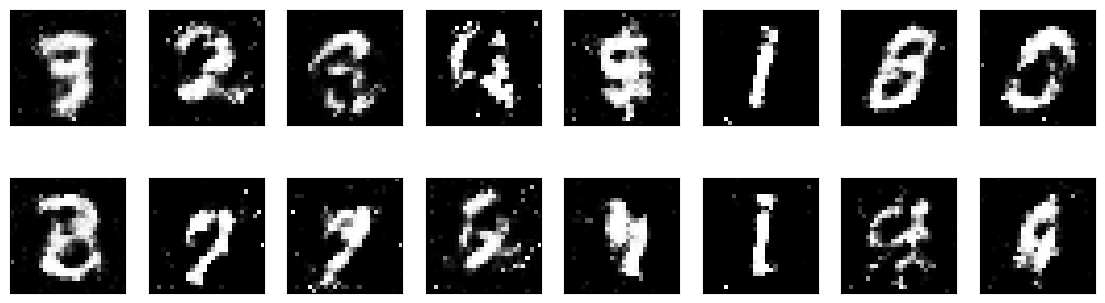

2024-01-01 09:49:35 | Epoch [102/150] | Batch 0/469 | d_loss: 1.1698 | g_loss: 1.2982
2024-01-01 09:49:37 | Epoch [102/150] | Batch 100/469 | d_loss: 1.1634 | g_loss: 1.3424
2024-01-01 09:49:38 | Epoch [102/150] | Batch 200/469 | d_loss: 1.1577 | g_loss: 1.2437
2024-01-01 09:49:39 | Epoch [102/150] | Batch 300/469 | d_loss: 1.1384 | g_loss: 1.3443
2024-01-01 09:49:41 | Epoch [102/150] | Batch 400/469 | d_loss: 1.1703 | g_loss: 1.2778


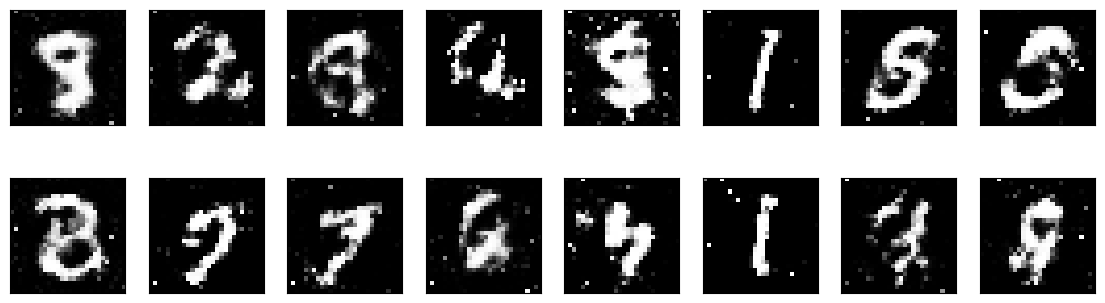

2024-01-01 09:49:45 | Epoch [103/150] | Batch 0/469 | d_loss: 1.0926 | g_loss: 1.3567
2024-01-01 09:49:47 | Epoch [103/150] | Batch 100/469 | d_loss: 1.1980 | g_loss: 1.2964
2024-01-01 09:49:48 | Epoch [103/150] | Batch 200/469 | d_loss: 1.1231 | g_loss: 1.2441
2024-01-01 09:49:50 | Epoch [103/150] | Batch 300/469 | d_loss: 1.1480 | g_loss: 1.3588
2024-01-01 09:49:51 | Epoch [103/150] | Batch 400/469 | d_loss: 1.1703 | g_loss: 1.2977


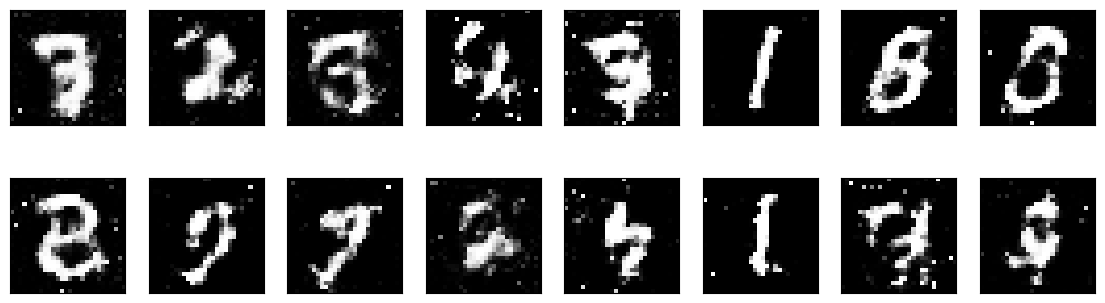

2024-01-01 09:49:55 | Epoch [104/150] | Batch 0/469 | d_loss: 1.0378 | g_loss: 1.3266
2024-01-01 09:49:56 | Epoch [104/150] | Batch 100/469 | d_loss: 1.1410 | g_loss: 1.4416
2024-01-01 09:49:58 | Epoch [104/150] | Batch 200/469 | d_loss: 1.1597 | g_loss: 1.3195
2024-01-01 09:49:59 | Epoch [104/150] | Batch 300/469 | d_loss: 1.1410 | g_loss: 1.2207
2024-01-01 09:50:01 | Epoch [104/150] | Batch 400/469 | d_loss: 1.1319 | g_loss: 1.2689


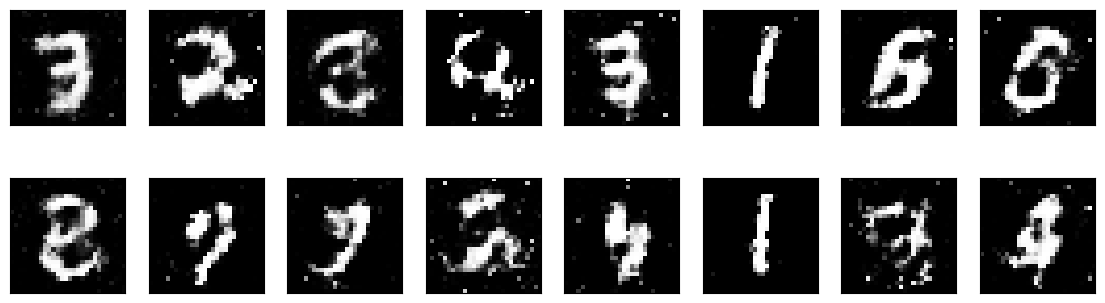

2024-01-01 09:50:05 | Epoch [105/150] | Batch 0/469 | d_loss: 1.1768 | g_loss: 1.3302
2024-01-01 09:50:06 | Epoch [105/150] | Batch 100/469 | d_loss: 1.2051 | g_loss: 1.3034
2024-01-01 09:50:08 | Epoch [105/150] | Batch 200/469 | d_loss: 1.1550 | g_loss: 1.3069
2024-01-01 09:50:09 | Epoch [105/150] | Batch 300/469 | d_loss: 1.1253 | g_loss: 1.5534
2024-01-01 09:50:11 | Epoch [105/150] | Batch 400/469 | d_loss: 1.1431 | g_loss: 1.3850


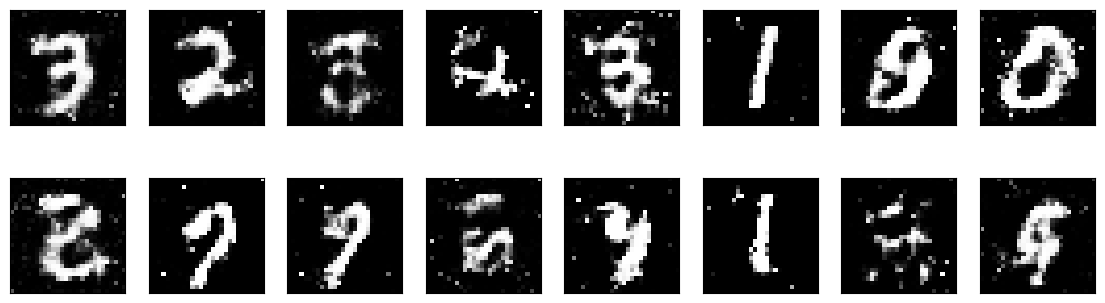

2024-01-01 09:50:15 | Epoch [106/150] | Batch 0/469 | d_loss: 1.1061 | g_loss: 1.4369
2024-01-01 09:50:17 | Epoch [106/150] | Batch 100/469 | d_loss: 1.1148 | g_loss: 1.4345
2024-01-01 09:50:18 | Epoch [106/150] | Batch 200/469 | d_loss: 1.1991 | g_loss: 1.3125
2024-01-01 09:50:20 | Epoch [106/150] | Batch 300/469 | d_loss: 1.1836 | g_loss: 1.1215
2024-01-01 09:50:21 | Epoch [106/150] | Batch 400/469 | d_loss: 1.1928 | g_loss: 1.3840


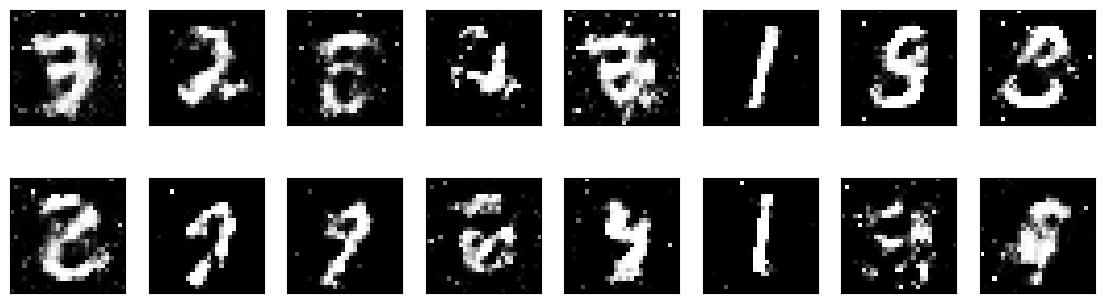

2024-01-01 09:50:25 | Epoch [107/150] | Batch 0/469 | d_loss: 1.2002 | g_loss: 1.2278
2024-01-01 09:50:27 | Epoch [107/150] | Batch 100/469 | d_loss: 1.1673 | g_loss: 1.3821
2024-01-01 09:50:28 | Epoch [107/150] | Batch 200/469 | d_loss: 1.1757 | g_loss: 1.4541
2024-01-01 09:50:30 | Epoch [107/150] | Batch 300/469 | d_loss: 1.0393 | g_loss: 1.2633
2024-01-01 09:50:31 | Epoch [107/150] | Batch 400/469 | d_loss: 1.1772 | g_loss: 1.3038


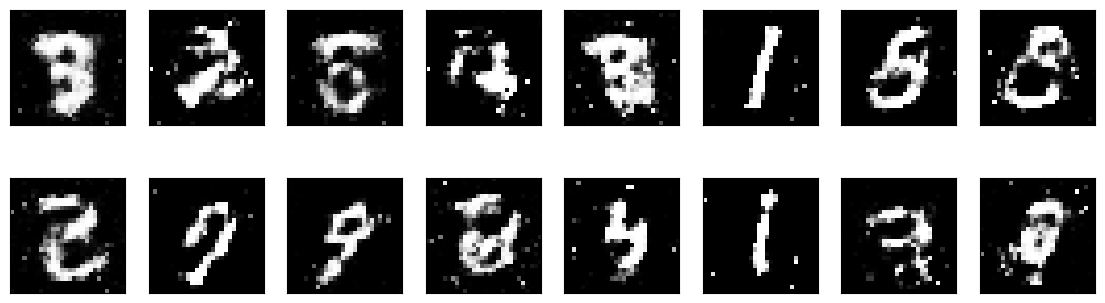

2024-01-01 09:50:35 | Epoch [108/150] | Batch 0/469 | d_loss: 1.1473 | g_loss: 1.2860
2024-01-01 09:50:37 | Epoch [108/150] | Batch 100/469 | d_loss: 1.1933 | g_loss: 1.2796
2024-01-01 09:50:38 | Epoch [108/150] | Batch 200/469 | d_loss: 1.1301 | g_loss: 1.1892
2024-01-01 09:50:40 | Epoch [108/150] | Batch 300/469 | d_loss: 1.1703 | g_loss: 1.3220
2024-01-01 09:50:41 | Epoch [108/150] | Batch 400/469 | d_loss: 1.0672 | g_loss: 1.2559


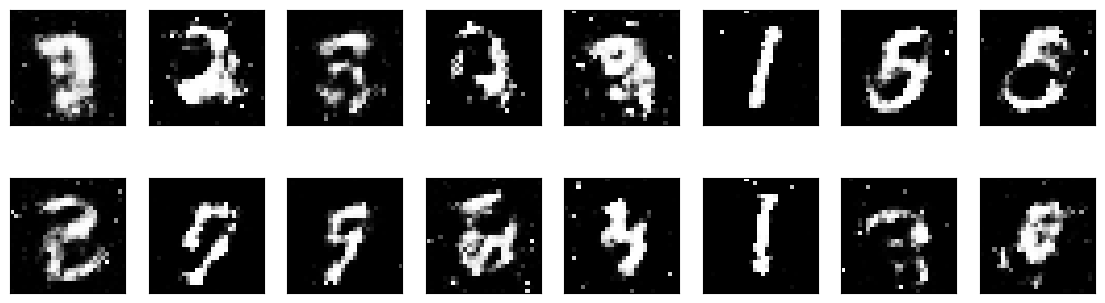

2024-01-01 09:50:45 | Epoch [109/150] | Batch 0/469 | d_loss: 1.1552 | g_loss: 1.3965
2024-01-01 09:50:47 | Epoch [109/150] | Batch 100/469 | d_loss: 1.1270 | g_loss: 1.2534
2024-01-01 09:50:48 | Epoch [109/150] | Batch 200/469 | d_loss: 1.2100 | g_loss: 1.0815
2024-01-01 09:50:50 | Epoch [109/150] | Batch 300/469 | d_loss: 1.1393 | g_loss: 1.1015
2024-01-01 09:50:51 | Epoch [109/150] | Batch 400/469 | d_loss: 1.0889 | g_loss: 1.4117


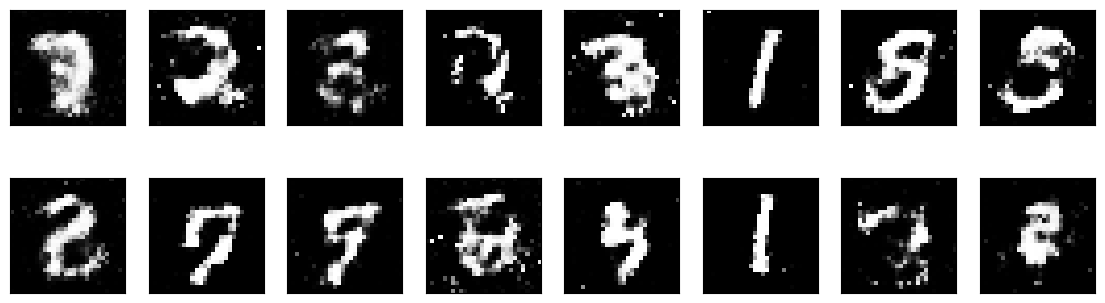

2024-01-01 09:50:55 | Epoch [110/150] | Batch 0/469 | d_loss: 1.1257 | g_loss: 1.2413
2024-01-01 09:50:56 | Epoch [110/150] | Batch 100/469 | d_loss: 1.1399 | g_loss: 1.2917
2024-01-01 09:50:58 | Epoch [110/150] | Batch 200/469 | d_loss: 1.1938 | g_loss: 1.2730
2024-01-01 09:50:59 | Epoch [110/150] | Batch 300/469 | d_loss: 1.2155 | g_loss: 1.1843
2024-01-01 09:51:01 | Epoch [110/150] | Batch 400/469 | d_loss: 1.1483 | g_loss: 1.4196


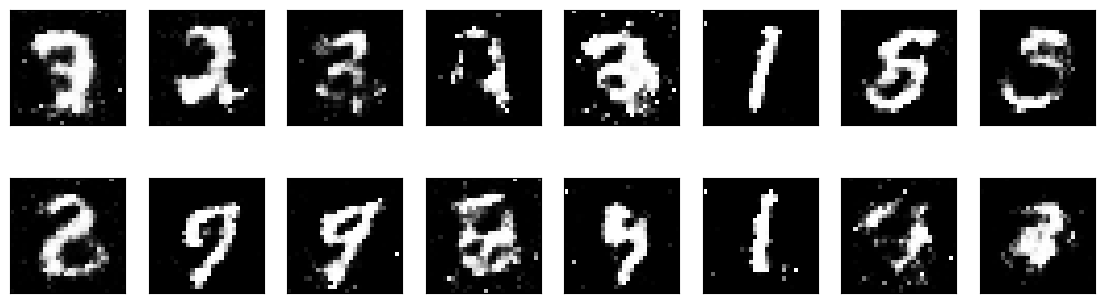

2024-01-01 09:51:05 | Epoch [111/150] | Batch 0/469 | d_loss: 1.0371 | g_loss: 1.4114
2024-01-01 09:51:06 | Epoch [111/150] | Batch 100/469 | d_loss: 1.2533 | g_loss: 1.3785
2024-01-01 09:51:08 | Epoch [111/150] | Batch 200/469 | d_loss: 1.2016 | g_loss: 1.3657
2024-01-01 09:51:09 | Epoch [111/150] | Batch 300/469 | d_loss: 1.1761 | g_loss: 1.2311
2024-01-01 09:51:10 | Epoch [111/150] | Batch 400/469 | d_loss: 1.0589 | g_loss: 1.3070


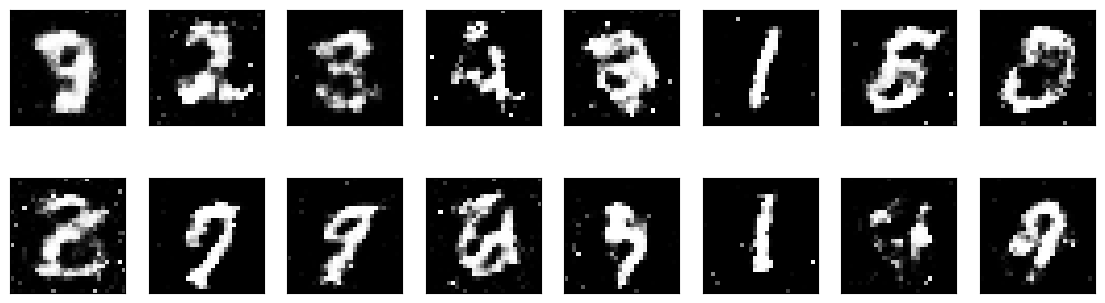

2024-01-01 09:51:14 | Epoch [112/150] | Batch 0/469 | d_loss: 1.1981 | g_loss: 1.2088
2024-01-01 09:51:16 | Epoch [112/150] | Batch 100/469 | d_loss: 1.2222 | g_loss: 1.2248
2024-01-01 09:51:17 | Epoch [112/150] | Batch 200/469 | d_loss: 1.1801 | g_loss: 1.2048
2024-01-01 09:51:19 | Epoch [112/150] | Batch 300/469 | d_loss: 1.1253 | g_loss: 1.3563
2024-01-01 09:51:20 | Epoch [112/150] | Batch 400/469 | d_loss: 1.1558 | g_loss: 1.3768


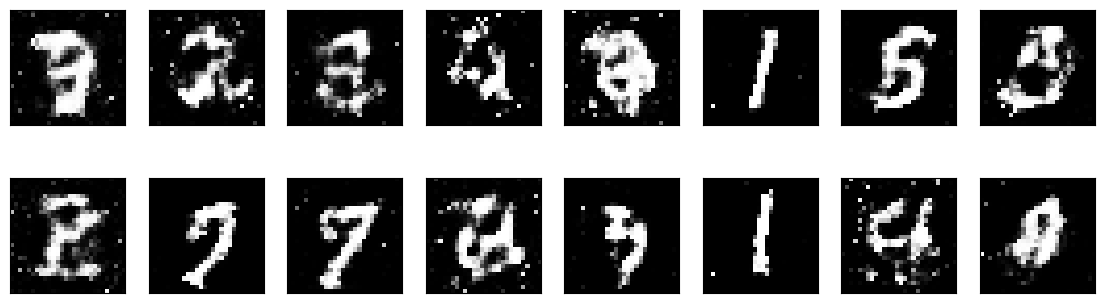

2024-01-01 09:51:24 | Epoch [113/150] | Batch 0/469 | d_loss: 1.0930 | g_loss: 1.3608
2024-01-01 09:51:26 | Epoch [113/150] | Batch 100/469 | d_loss: 1.2289 | g_loss: 1.1837
2024-01-01 09:51:27 | Epoch [113/150] | Batch 200/469 | d_loss: 1.1434 | g_loss: 1.2263
2024-01-01 09:51:29 | Epoch [113/150] | Batch 300/469 | d_loss: 1.1193 | g_loss: 1.2570
2024-01-01 09:51:30 | Epoch [113/150] | Batch 400/469 | d_loss: 1.1238 | g_loss: 1.4457


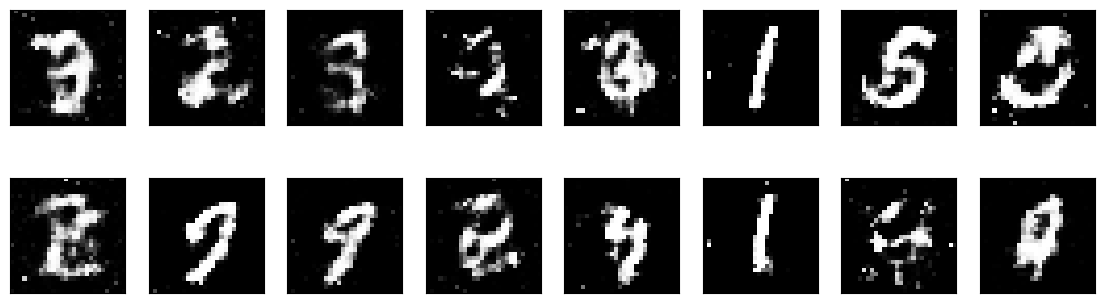

2024-01-01 09:51:34 | Epoch [114/150] | Batch 0/469 | d_loss: 1.0700 | g_loss: 1.4021
2024-01-01 09:51:36 | Epoch [114/150] | Batch 100/469 | d_loss: 1.1997 | g_loss: 1.2086
2024-01-01 09:51:37 | Epoch [114/150] | Batch 200/469 | d_loss: 1.1050 | g_loss: 1.4216
2024-01-01 09:51:38 | Epoch [114/150] | Batch 300/469 | d_loss: 1.2009 | g_loss: 1.2343
2024-01-01 09:51:40 | Epoch [114/150] | Batch 400/469 | d_loss: 1.1064 | g_loss: 1.3786


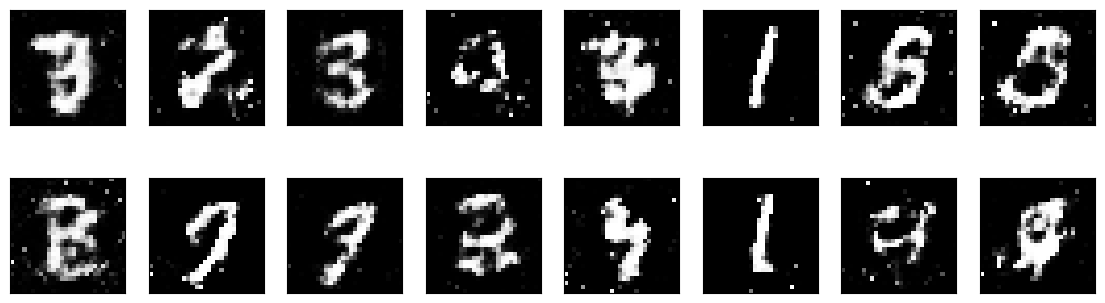

2024-01-01 09:51:44 | Epoch [115/150] | Batch 0/469 | d_loss: 1.0944 | g_loss: 1.3630
2024-01-01 09:51:45 | Epoch [115/150] | Batch 100/469 | d_loss: 1.1159 | g_loss: 1.4075
2024-01-01 09:51:46 | Epoch [115/150] | Batch 200/469 | d_loss: 1.0743 | g_loss: 1.5621
2024-01-01 09:51:48 | Epoch [115/150] | Batch 300/469 | d_loss: 1.1781 | g_loss: 1.0952
2024-01-01 09:51:49 | Epoch [115/150] | Batch 400/469 | d_loss: 1.0481 | g_loss: 1.4734


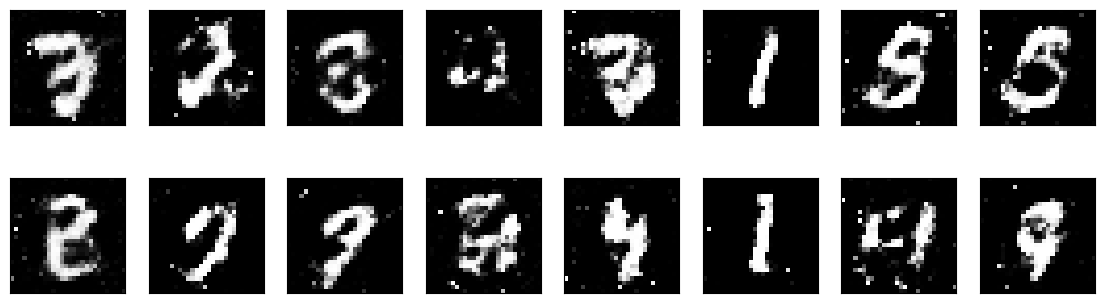

2024-01-01 09:51:54 | Epoch [116/150] | Batch 0/469 | d_loss: 1.1427 | g_loss: 1.2512
2024-01-01 09:51:55 | Epoch [116/150] | Batch 100/469 | d_loss: 1.0074 | g_loss: 1.3045
2024-01-01 09:51:56 | Epoch [116/150] | Batch 200/469 | d_loss: 1.0744 | g_loss: 1.4824
2024-01-01 09:51:58 | Epoch [116/150] | Batch 300/469 | d_loss: 1.2135 | g_loss: 1.2270
2024-01-01 09:51:59 | Epoch [116/150] | Batch 400/469 | d_loss: 1.2030 | g_loss: 1.3651


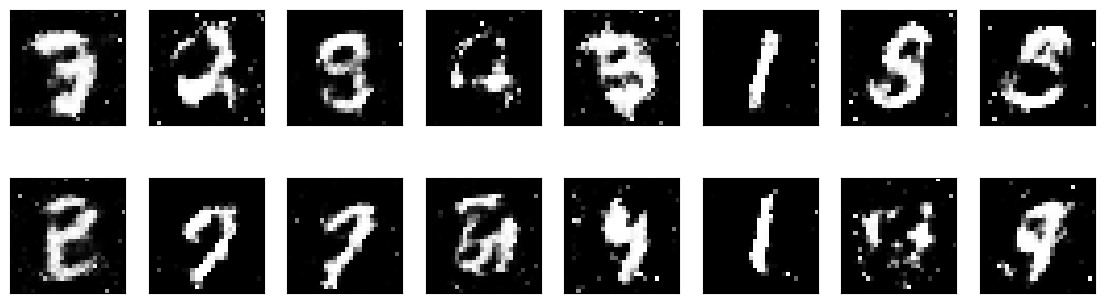

2024-01-01 09:52:03 | Epoch [117/150] | Batch 0/469 | d_loss: 1.1513 | g_loss: 1.4042
2024-01-01 09:52:05 | Epoch [117/150] | Batch 100/469 | d_loss: 1.1828 | g_loss: 1.2866
2024-01-01 09:52:06 | Epoch [117/150] | Batch 200/469 | d_loss: 1.0749 | g_loss: 1.2664
2024-01-01 09:52:08 | Epoch [117/150] | Batch 300/469 | d_loss: 1.0820 | g_loss: 1.5114
2024-01-01 09:52:09 | Epoch [117/150] | Batch 400/469 | d_loss: 1.2049 | g_loss: 1.3008


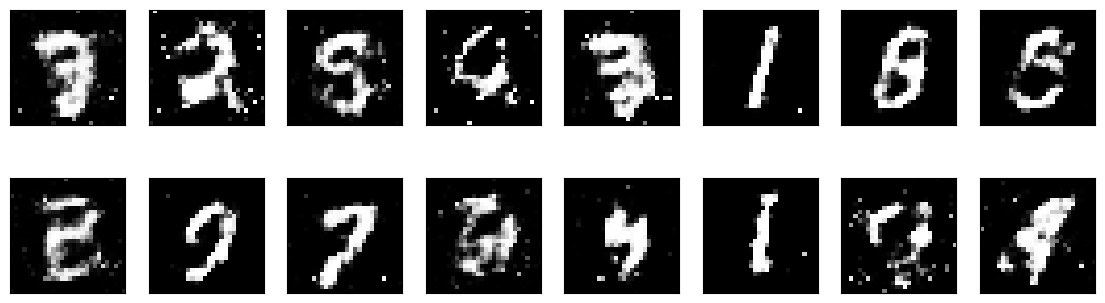

2024-01-01 09:52:13 | Epoch [118/150] | Batch 0/469 | d_loss: 1.1459 | g_loss: 1.2250
2024-01-01 09:52:15 | Epoch [118/150] | Batch 100/469 | d_loss: 1.1023 | g_loss: 1.4231
2024-01-01 09:52:16 | Epoch [118/150] | Batch 200/469 | d_loss: 1.0934 | g_loss: 1.3792
2024-01-01 09:52:18 | Epoch [118/150] | Batch 300/469 | d_loss: 1.2032 | g_loss: 1.2111
2024-01-01 09:52:19 | Epoch [118/150] | Batch 400/469 | d_loss: 1.0668 | g_loss: 1.6571


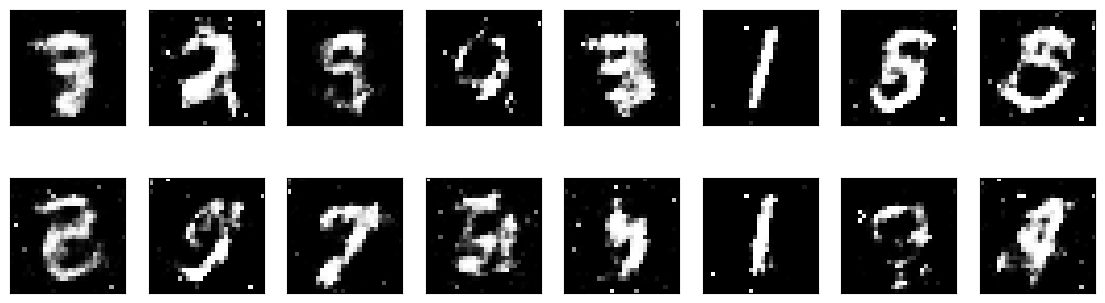

2024-01-01 09:52:23 | Epoch [119/150] | Batch 0/469 | d_loss: 1.1050 | g_loss: 1.2533
2024-01-01 09:52:25 | Epoch [119/150] | Batch 100/469 | d_loss: 1.2011 | g_loss: 1.4282
2024-01-01 09:52:26 | Epoch [119/150] | Batch 200/469 | d_loss: 1.1423 | g_loss: 1.3416
2024-01-01 09:52:28 | Epoch [119/150] | Batch 300/469 | d_loss: 1.1832 | g_loss: 1.0736
2024-01-01 09:52:29 | Epoch [119/150] | Batch 400/469 | d_loss: 1.1168 | g_loss: 1.2305


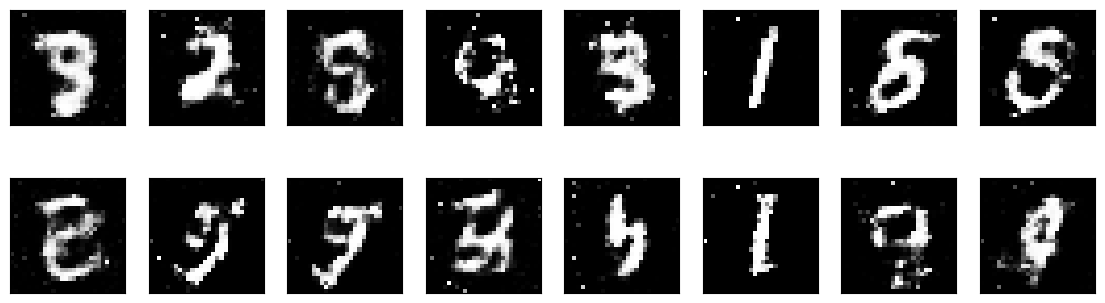

2024-01-01 09:52:33 | Epoch [120/150] | Batch 0/469 | d_loss: 1.1586 | g_loss: 1.3113
2024-01-01 09:52:35 | Epoch [120/150] | Batch 100/469 | d_loss: 1.2177 | g_loss: 1.1622
2024-01-01 09:52:36 | Epoch [120/150] | Batch 200/469 | d_loss: 1.1563 | g_loss: 1.1244
2024-01-01 09:52:38 | Epoch [120/150] | Batch 300/469 | d_loss: 1.2631 | g_loss: 1.3564
2024-01-01 09:52:39 | Epoch [120/150] | Batch 400/469 | d_loss: 1.1721 | g_loss: 1.2808


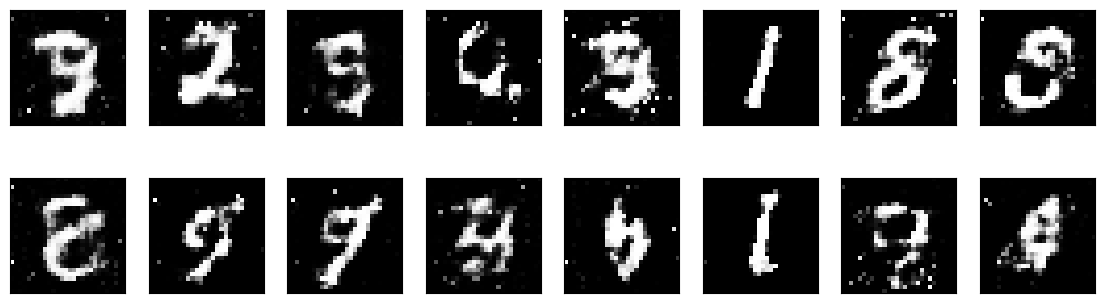

2024-01-01 09:52:43 | Epoch [121/150] | Batch 0/469 | d_loss: 1.1747 | g_loss: 1.2168
2024-01-01 09:52:44 | Epoch [121/150] | Batch 100/469 | d_loss: 1.1454 | g_loss: 1.2517
2024-01-01 09:52:46 | Epoch [121/150] | Batch 200/469 | d_loss: 1.1636 | g_loss: 1.2836
2024-01-01 09:52:47 | Epoch [121/150] | Batch 300/469 | d_loss: 1.1944 | g_loss: 1.2827
2024-01-01 09:52:49 | Epoch [121/150] | Batch 400/469 | d_loss: 1.1317 | g_loss: 1.2391


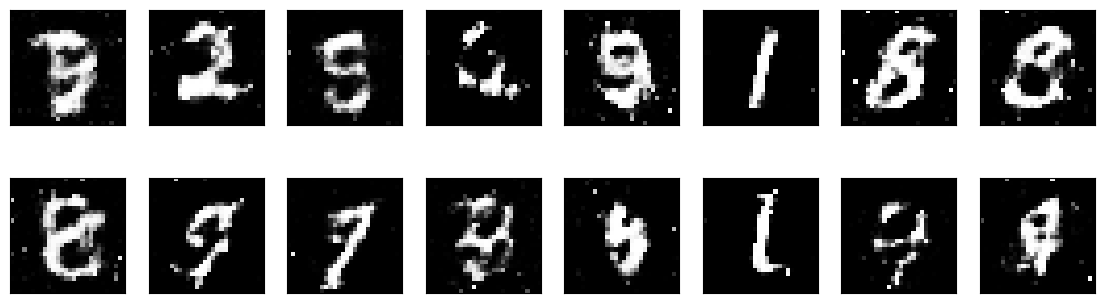

2024-01-01 09:52:53 | Epoch [122/150] | Batch 0/469 | d_loss: 1.1180 | g_loss: 1.2858
2024-01-01 09:52:54 | Epoch [122/150] | Batch 100/469 | d_loss: 1.2035 | g_loss: 1.1890
2024-01-01 09:52:55 | Epoch [122/150] | Batch 200/469 | d_loss: 1.1390 | g_loss: 1.3678
2024-01-01 09:52:57 | Epoch [122/150] | Batch 300/469 | d_loss: 1.0787 | g_loss: 1.3492
2024-01-01 09:52:58 | Epoch [122/150] | Batch 400/469 | d_loss: 1.0662 | g_loss: 1.3044


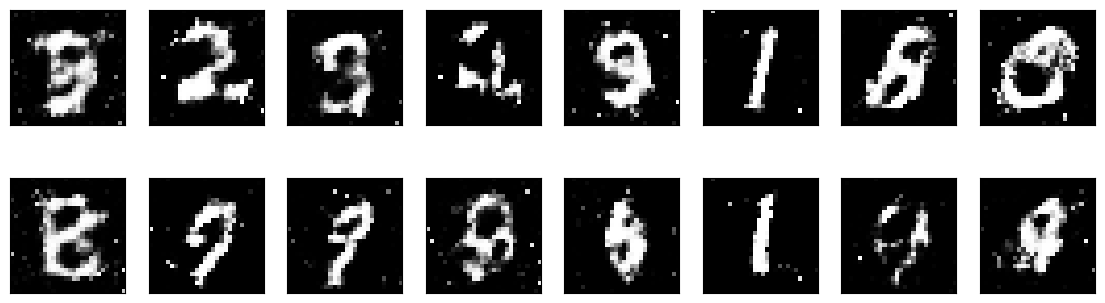

2024-01-01 09:53:02 | Epoch [123/150] | Batch 0/469 | d_loss: 1.0520 | g_loss: 1.3583
2024-01-01 09:53:04 | Epoch [123/150] | Batch 100/469 | d_loss: 1.2176 | g_loss: 1.4485
2024-01-01 09:53:05 | Epoch [123/150] | Batch 200/469 | d_loss: 1.1553 | g_loss: 1.4374
2024-01-01 09:53:07 | Epoch [123/150] | Batch 300/469 | d_loss: 1.0808 | g_loss: 1.5844
2024-01-01 09:53:08 | Epoch [123/150] | Batch 400/469 | d_loss: 1.1319 | g_loss: 1.2858


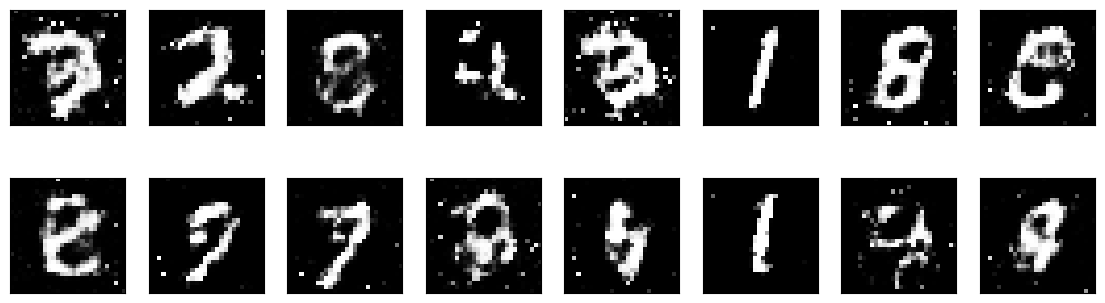

2024-01-01 09:53:12 | Epoch [124/150] | Batch 0/469 | d_loss: 1.1023 | g_loss: 1.2983
2024-01-01 09:53:14 | Epoch [124/150] | Batch 100/469 | d_loss: 1.2351 | g_loss: 1.3113
2024-01-01 09:53:15 | Epoch [124/150] | Batch 200/469 | d_loss: 1.0106 | g_loss: 1.4042
2024-01-01 09:53:16 | Epoch [124/150] | Batch 300/469 | d_loss: 1.1713 | g_loss: 1.1439
2024-01-01 09:53:18 | Epoch [124/150] | Batch 400/469 | d_loss: 1.2377 | g_loss: 1.2820


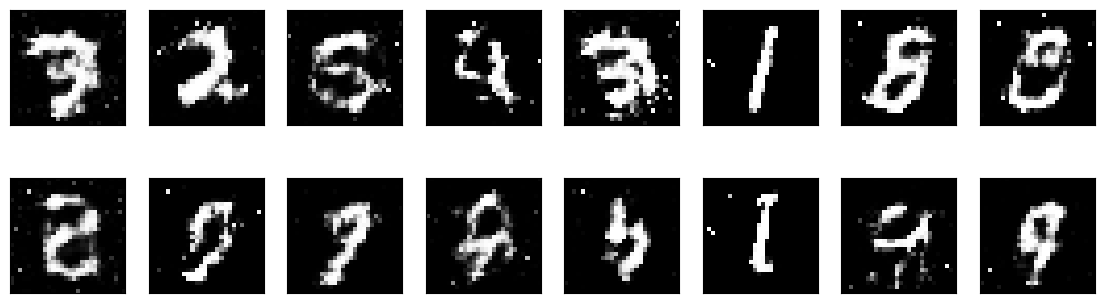

2024-01-01 09:53:22 | Epoch [125/150] | Batch 0/469 | d_loss: 1.1819 | g_loss: 1.2758
2024-01-01 09:53:23 | Epoch [125/150] | Batch 100/469 | d_loss: 1.1738 | g_loss: 1.3961
2024-01-01 09:53:25 | Epoch [125/150] | Batch 200/469 | d_loss: 1.1015 | g_loss: 1.2530
2024-01-01 09:53:26 | Epoch [125/150] | Batch 300/469 | d_loss: 1.1717 | g_loss: 1.2568
2024-01-01 09:53:27 | Epoch [125/150] | Batch 400/469 | d_loss: 1.1578 | g_loss: 1.1969


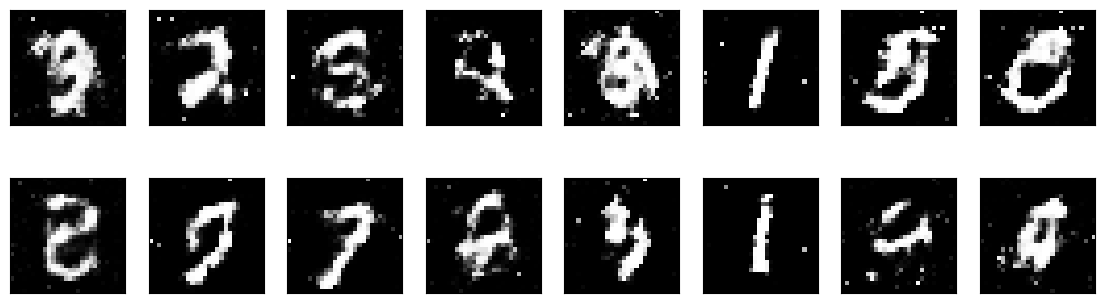

2024-01-01 09:53:31 | Epoch [126/150] | Batch 0/469 | d_loss: 1.1888 | g_loss: 1.2527
2024-01-01 09:53:33 | Epoch [126/150] | Batch 100/469 | d_loss: 1.1329 | g_loss: 1.3206
2024-01-01 09:53:34 | Epoch [126/150] | Batch 200/469 | d_loss: 1.1751 | g_loss: 1.3307
2024-01-01 09:53:35 | Epoch [126/150] | Batch 300/469 | d_loss: 1.1799 | g_loss: 1.5043
2024-01-01 09:53:37 | Epoch [126/150] | Batch 400/469 | d_loss: 1.1937 | g_loss: 1.2317


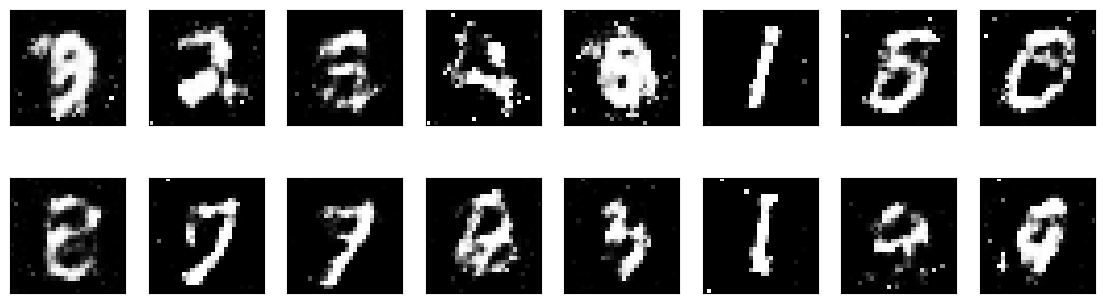

2024-01-01 09:53:41 | Epoch [127/150] | Batch 0/469 | d_loss: 1.2082 | g_loss: 1.1997
2024-01-01 09:53:42 | Epoch [127/150] | Batch 100/469 | d_loss: 1.1688 | g_loss: 1.1666
2024-01-01 09:53:44 | Epoch [127/150] | Batch 200/469 | d_loss: 1.1275 | g_loss: 1.1800
2024-01-01 09:53:45 | Epoch [127/150] | Batch 300/469 | d_loss: 1.1943 | g_loss: 1.4176
2024-01-01 09:53:46 | Epoch [127/150] | Batch 400/469 | d_loss: 1.2114 | g_loss: 1.2501


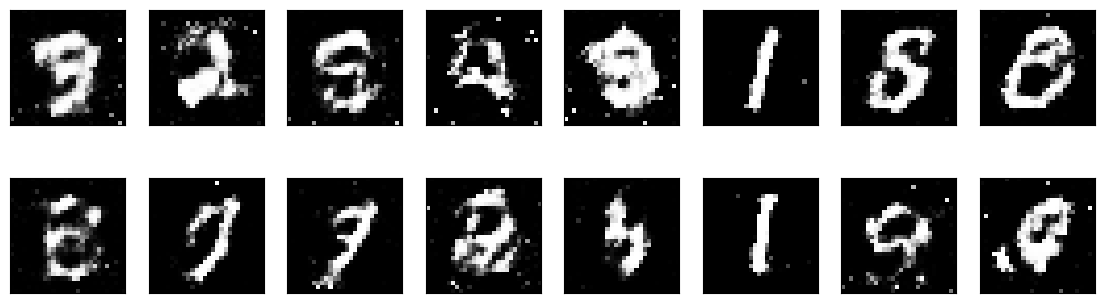

2024-01-01 09:53:51 | Epoch [128/150] | Batch 0/469 | d_loss: 1.1821 | g_loss: 1.1787
2024-01-01 09:53:53 | Epoch [128/150] | Batch 100/469 | d_loss: 1.2304 | g_loss: 1.3309
2024-01-01 09:53:54 | Epoch [128/150] | Batch 200/469 | d_loss: 1.1452 | g_loss: 1.2897
2024-01-01 09:53:55 | Epoch [128/150] | Batch 300/469 | d_loss: 1.2238 | g_loss: 1.2083
2024-01-01 09:53:57 | Epoch [128/150] | Batch 400/469 | d_loss: 1.1189 | g_loss: 1.2860


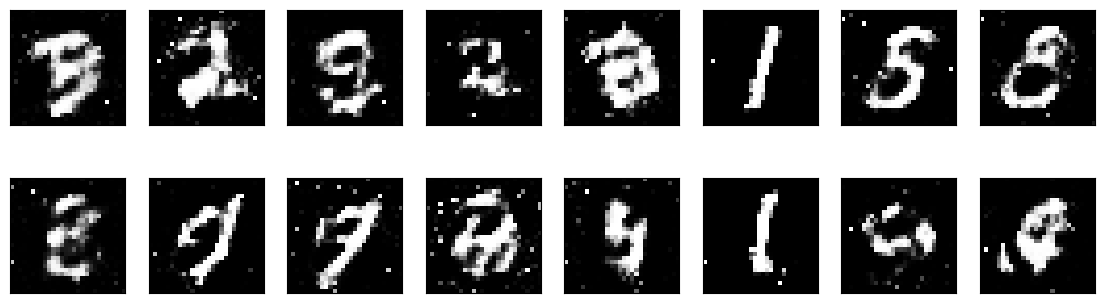

2024-01-01 09:54:01 | Epoch [129/150] | Batch 0/469 | d_loss: 1.0749 | g_loss: 1.4000
2024-01-01 09:54:02 | Epoch [129/150] | Batch 100/469 | d_loss: 1.2105 | g_loss: 1.4064
2024-01-01 09:54:04 | Epoch [129/150] | Batch 200/469 | d_loss: 1.1148 | g_loss: 1.4861
2024-01-01 09:54:05 | Epoch [129/150] | Batch 300/469 | d_loss: 1.0735 | g_loss: 1.2109
2024-01-01 09:54:07 | Epoch [129/150] | Batch 400/469 | d_loss: 1.1313 | g_loss: 1.2507


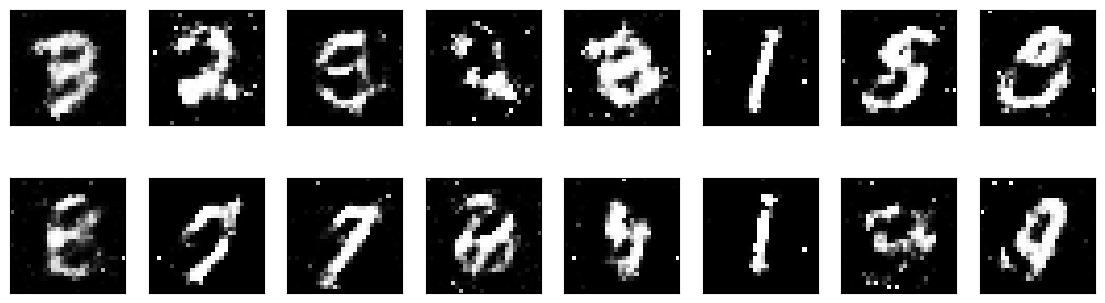

2024-01-01 09:54:11 | Epoch [130/150] | Batch 0/469 | d_loss: 1.1820 | g_loss: 1.2841
2024-01-01 09:54:12 | Epoch [130/150] | Batch 100/469 | d_loss: 1.0815 | g_loss: 1.3875
2024-01-01 09:54:14 | Epoch [130/150] | Batch 200/469 | d_loss: 1.1739 | g_loss: 1.3112
2024-01-01 09:54:15 | Epoch [130/150] | Batch 300/469 | d_loss: 1.1633 | g_loss: 1.3072
2024-01-01 09:54:17 | Epoch [130/150] | Batch 400/469 | d_loss: 1.1032 | g_loss: 1.3808


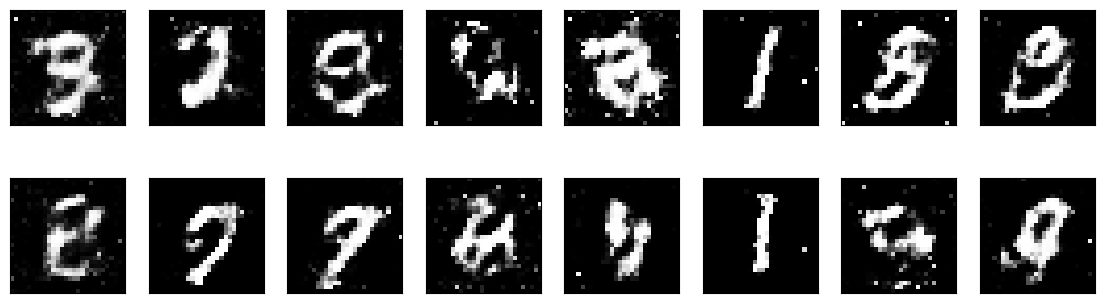

2024-01-01 09:54:21 | Epoch [131/150] | Batch 0/469 | d_loss: 1.1311 | g_loss: 1.2246
2024-01-01 09:54:22 | Epoch [131/150] | Batch 100/469 | d_loss: 1.3112 | g_loss: 1.1075
2024-01-01 09:54:23 | Epoch [131/150] | Batch 200/469 | d_loss: 1.1532 | g_loss: 1.3051
2024-01-01 09:54:25 | Epoch [131/150] | Batch 300/469 | d_loss: 1.1845 | g_loss: 1.0390
2024-01-01 09:54:26 | Epoch [131/150] | Batch 400/469 | d_loss: 1.1934 | g_loss: 1.0794


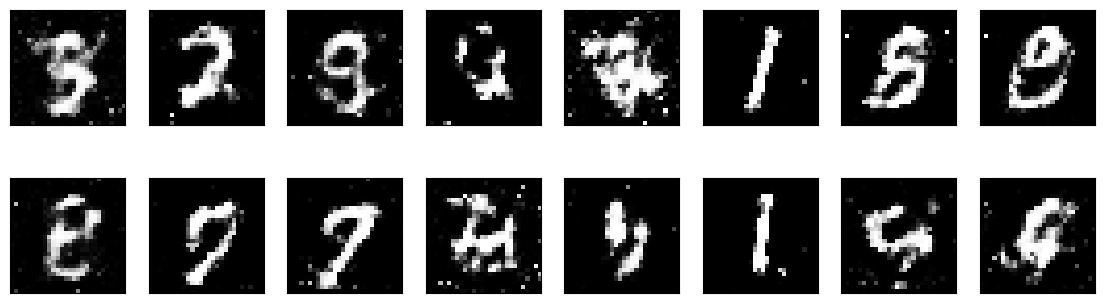

2024-01-01 09:54:30 | Epoch [132/150] | Batch 0/469 | d_loss: 1.1568 | g_loss: 1.3301
2024-01-01 09:54:32 | Epoch [132/150] | Batch 100/469 | d_loss: 1.2192 | g_loss: 1.3728
2024-01-01 09:54:33 | Epoch [132/150] | Batch 200/469 | d_loss: 1.2411 | g_loss: 1.1990
2024-01-01 09:54:35 | Epoch [132/150] | Batch 300/469 | d_loss: 1.1988 | g_loss: 1.2471
2024-01-01 09:54:36 | Epoch [132/150] | Batch 400/469 | d_loss: 1.1191 | g_loss: 1.1959


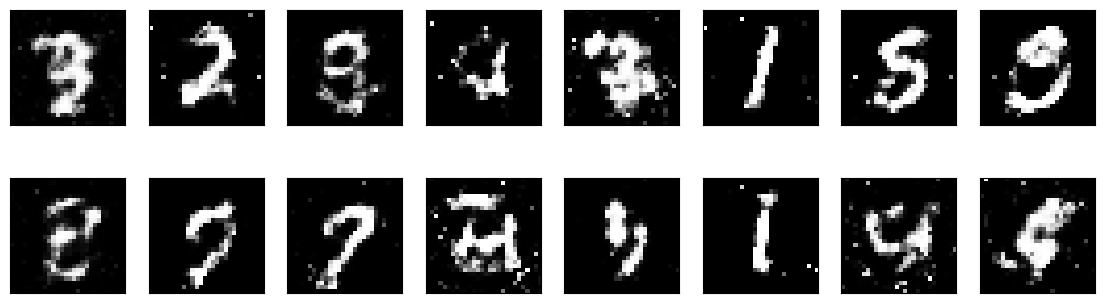

2024-01-01 09:54:40 | Epoch [133/150] | Batch 0/469 | d_loss: 1.1290 | g_loss: 1.2433
2024-01-01 09:54:42 | Epoch [133/150] | Batch 100/469 | d_loss: 1.2057 | g_loss: 1.2929
2024-01-01 09:54:43 | Epoch [133/150] | Batch 200/469 | d_loss: 1.1745 | g_loss: 1.2976
2024-01-01 09:54:45 | Epoch [133/150] | Batch 300/469 | d_loss: 1.1441 | g_loss: 1.2695
2024-01-01 09:54:46 | Epoch [133/150] | Batch 400/469 | d_loss: 1.2045 | g_loss: 1.0773


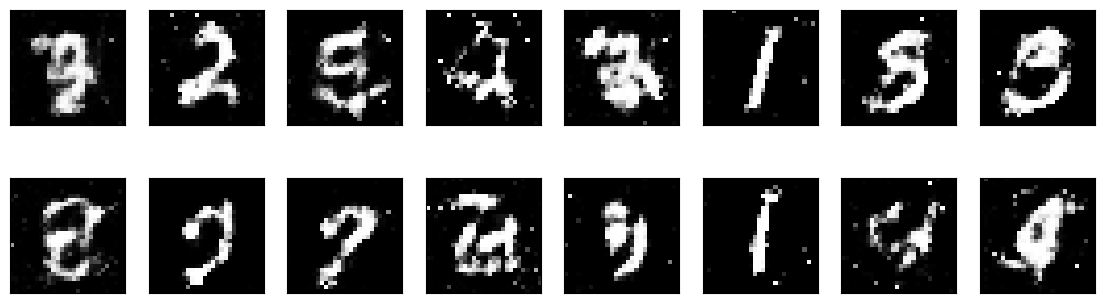

2024-01-01 09:54:50 | Epoch [134/150] | Batch 0/469 | d_loss: 1.1811 | g_loss: 1.2968
2024-01-01 09:54:51 | Epoch [134/150] | Batch 100/469 | d_loss: 1.1481 | g_loss: 1.2876
2024-01-01 09:54:53 | Epoch [134/150] | Batch 200/469 | d_loss: 1.0955 | g_loss: 1.1862
2024-01-01 09:54:54 | Epoch [134/150] | Batch 300/469 | d_loss: 1.1046 | g_loss: 1.2113
2024-01-01 09:54:56 | Epoch [134/150] | Batch 400/469 | d_loss: 1.2262 | g_loss: 1.2140


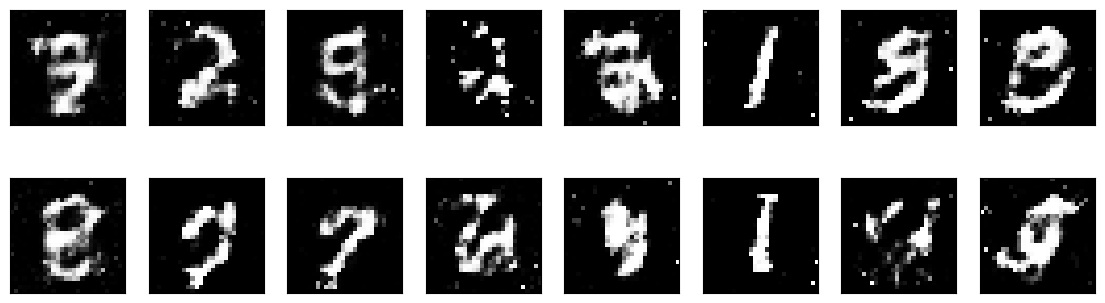

2024-01-01 09:55:00 | Epoch [135/150] | Batch 0/469 | d_loss: 1.1550 | g_loss: 1.3449
2024-01-01 09:55:01 | Epoch [135/150] | Batch 100/469 | d_loss: 1.1592 | g_loss: 1.3777
2024-01-01 09:55:02 | Epoch [135/150] | Batch 200/469 | d_loss: 1.1605 | g_loss: 1.1582
2024-01-01 09:55:04 | Epoch [135/150] | Batch 300/469 | d_loss: 1.1292 | g_loss: 1.2073
2024-01-01 09:55:05 | Epoch [135/150] | Batch 400/469 | d_loss: 1.1067 | g_loss: 1.2799


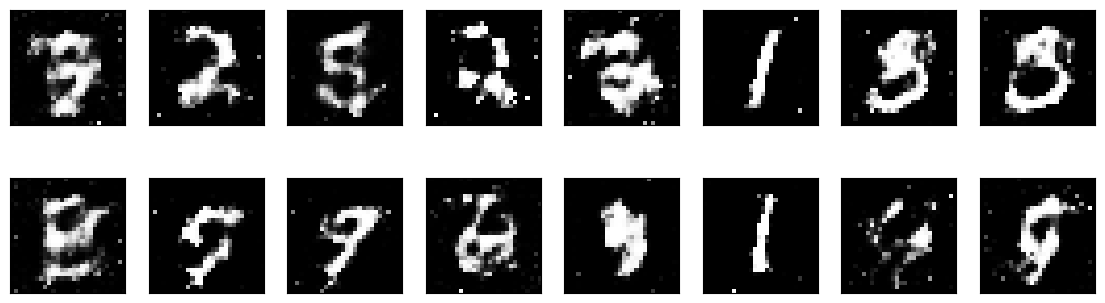

2024-01-01 09:55:09 | Epoch [136/150] | Batch 0/469 | d_loss: 1.2375 | g_loss: 1.2803
2024-01-01 09:55:11 | Epoch [136/150] | Batch 100/469 | d_loss: 1.1506 | g_loss: 1.3319
2024-01-01 09:55:12 | Epoch [136/150] | Batch 200/469 | d_loss: 1.1948 | g_loss: 1.2051
2024-01-01 09:55:13 | Epoch [136/150] | Batch 300/469 | d_loss: 1.1050 | g_loss: 1.3313
2024-01-01 09:55:15 | Epoch [136/150] | Batch 400/469 | d_loss: 1.2321 | g_loss: 1.1372


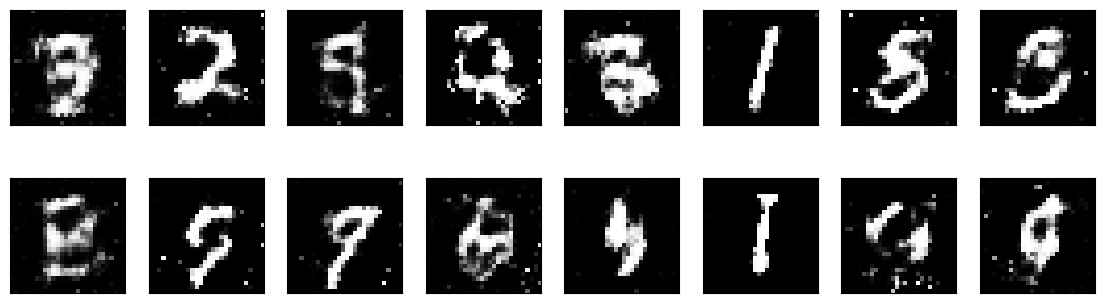

2024-01-01 09:55:19 | Epoch [137/150] | Batch 0/469 | d_loss: 1.1699 | g_loss: 1.4420
2024-01-01 09:55:20 | Epoch [137/150] | Batch 100/469 | d_loss: 1.1449 | g_loss: 1.2672
2024-01-01 09:55:21 | Epoch [137/150] | Batch 200/469 | d_loss: 1.2076 | g_loss: 1.2062
2024-01-01 09:55:23 | Epoch [137/150] | Batch 300/469 | d_loss: 1.2051 | g_loss: 1.2500
2024-01-01 09:55:24 | Epoch [137/150] | Batch 400/469 | d_loss: 1.2057 | g_loss: 1.2104


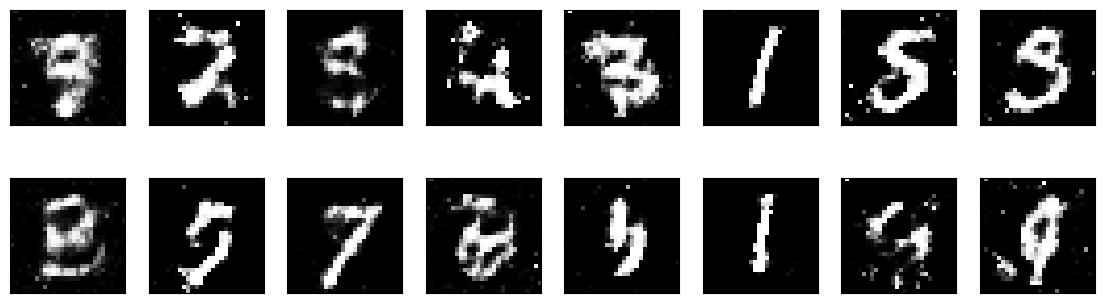

2024-01-01 09:55:28 | Epoch [138/150] | Batch 0/469 | d_loss: 1.1937 | g_loss: 1.4773
2024-01-01 09:55:30 | Epoch [138/150] | Batch 100/469 | d_loss: 1.1657 | g_loss: 1.2760
2024-01-01 09:55:31 | Epoch [138/150] | Batch 200/469 | d_loss: 1.1927 | g_loss: 1.2246
2024-01-01 09:55:32 | Epoch [138/150] | Batch 300/469 | d_loss: 1.2693 | g_loss: 1.0732
2024-01-01 09:55:34 | Epoch [138/150] | Batch 400/469 | d_loss: 1.1418 | g_loss: 1.3479


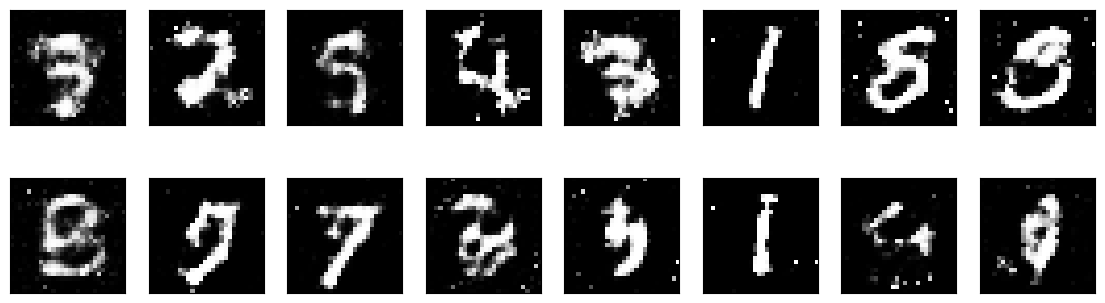

2024-01-01 09:55:37 | Epoch [139/150] | Batch 0/469 | d_loss: 1.1848 | g_loss: 1.0852
2024-01-01 09:55:39 | Epoch [139/150] | Batch 100/469 | d_loss: 1.1561 | g_loss: 1.4457
2024-01-01 09:55:40 | Epoch [139/150] | Batch 200/469 | d_loss: 1.1869 | g_loss: 1.2632
2024-01-01 09:55:41 | Epoch [139/150] | Batch 300/469 | d_loss: 1.1549 | g_loss: 1.1966
2024-01-01 09:55:43 | Epoch [139/150] | Batch 400/469 | d_loss: 1.2009 | g_loss: 1.1210


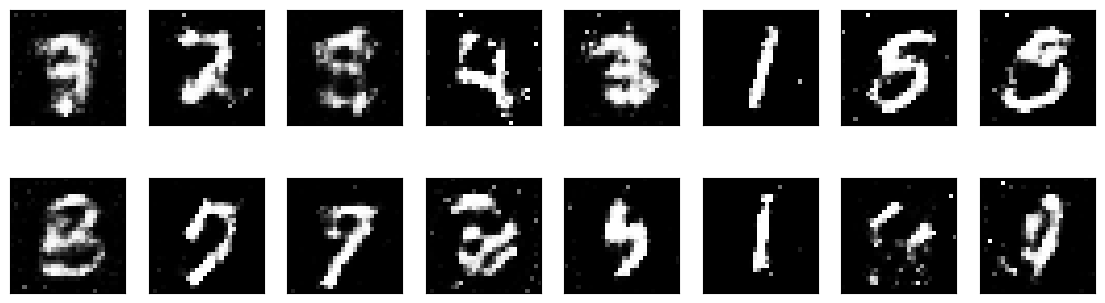

2024-01-01 09:55:46 | Epoch [140/150] | Batch 0/469 | d_loss: 1.2047 | g_loss: 1.3073
2024-01-01 09:55:48 | Epoch [140/150] | Batch 100/469 | d_loss: 1.1848 | g_loss: 1.1519
2024-01-01 09:55:49 | Epoch [140/150] | Batch 200/469 | d_loss: 1.1163 | g_loss: 1.2289
2024-01-01 09:55:50 | Epoch [140/150] | Batch 300/469 | d_loss: 1.2019 | g_loss: 1.1528
2024-01-01 09:55:52 | Epoch [140/150] | Batch 400/469 | d_loss: 1.2193 | g_loss: 1.1149


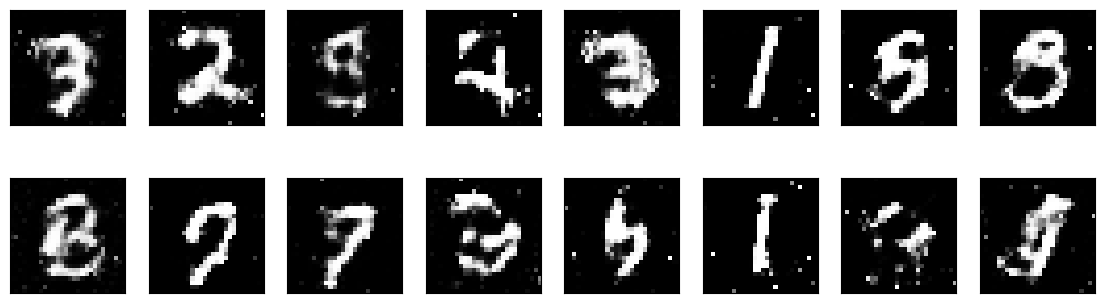

2024-01-01 09:55:56 | Epoch [141/150] | Batch 0/469 | d_loss: 1.1392 | g_loss: 1.3658
2024-01-01 09:55:57 | Epoch [141/150] | Batch 100/469 | d_loss: 1.1326 | g_loss: 1.3370
2024-01-01 09:55:58 | Epoch [141/150] | Batch 200/469 | d_loss: 1.1520 | g_loss: 1.0448
2024-01-01 09:56:00 | Epoch [141/150] | Batch 300/469 | d_loss: 1.1298 | g_loss: 1.2564
2024-01-01 09:56:01 | Epoch [141/150] | Batch 400/469 | d_loss: 1.2643 | g_loss: 1.1901


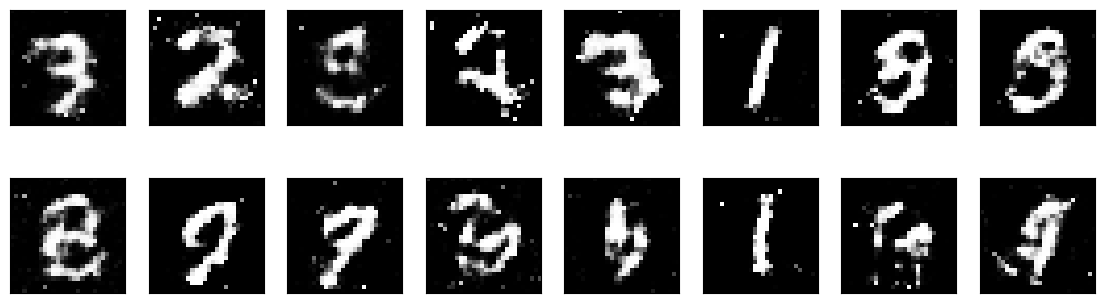

2024-01-01 09:56:05 | Epoch [142/150] | Batch 0/469 | d_loss: 1.1583 | g_loss: 1.2516
2024-01-01 09:56:06 | Epoch [142/150] | Batch 100/469 | d_loss: 1.2025 | g_loss: 1.1181
2024-01-01 09:56:07 | Epoch [142/150] | Batch 200/469 | d_loss: 1.1534 | g_loss: 1.0992
2024-01-01 09:56:09 | Epoch [142/150] | Batch 300/469 | d_loss: 1.1750 | g_loss: 1.2366
2024-01-01 09:56:10 | Epoch [142/150] | Batch 400/469 | d_loss: 1.1509 | g_loss: 1.1514


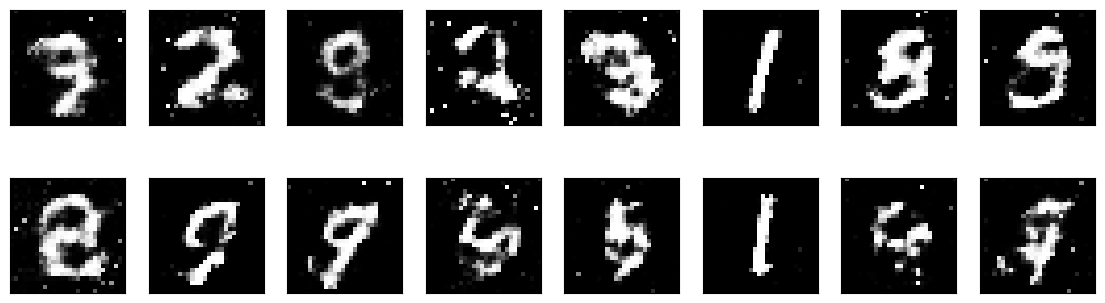

2024-01-01 09:56:14 | Epoch [143/150] | Batch 0/469 | d_loss: 1.0279 | g_loss: 1.3857
2024-01-01 09:56:15 | Epoch [143/150] | Batch 100/469 | d_loss: 1.2496 | g_loss: 1.1405
2024-01-01 09:56:17 | Epoch [143/150] | Batch 200/469 | d_loss: 1.2150 | g_loss: 1.0931
2024-01-01 09:56:18 | Epoch [143/150] | Batch 300/469 | d_loss: 1.1390 | g_loss: 1.3232
2024-01-01 09:56:19 | Epoch [143/150] | Batch 400/469 | d_loss: 1.1668 | g_loss: 1.2578


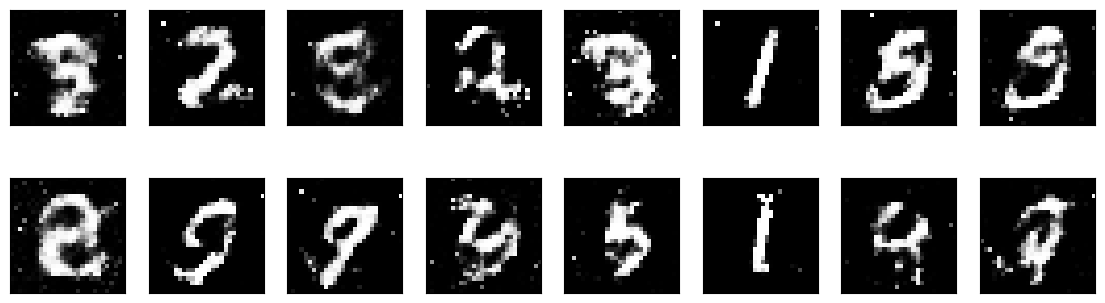

2024-01-01 09:56:23 | Epoch [144/150] | Batch 0/469 | d_loss: 1.1374 | g_loss: 1.5130
2024-01-01 09:56:25 | Epoch [144/150] | Batch 100/469 | d_loss: 1.1455 | g_loss: 1.2420
2024-01-01 09:56:26 | Epoch [144/150] | Batch 200/469 | d_loss: 1.1938 | g_loss: 1.0862
2024-01-01 09:56:27 | Epoch [144/150] | Batch 300/469 | d_loss: 1.1996 | g_loss: 1.2004
2024-01-01 09:56:29 | Epoch [144/150] | Batch 400/469 | d_loss: 1.1283 | g_loss: 1.1113


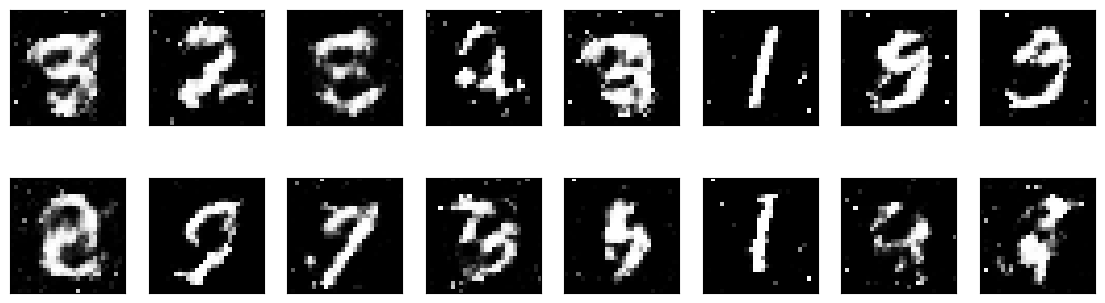

2024-01-01 09:56:32 | Epoch [145/150] | Batch 0/469 | d_loss: 1.1421 | g_loss: 1.3002
2024-01-01 09:56:34 | Epoch [145/150] | Batch 100/469 | d_loss: 1.1462 | g_loss: 1.4091
2024-01-01 09:56:35 | Epoch [145/150] | Batch 200/469 | d_loss: 1.0972 | g_loss: 1.2796
2024-01-01 09:56:37 | Epoch [145/150] | Batch 300/469 | d_loss: 1.1174 | g_loss: 1.3974
2024-01-01 09:56:38 | Epoch [145/150] | Batch 400/469 | d_loss: 1.2529 | g_loss: 1.1910


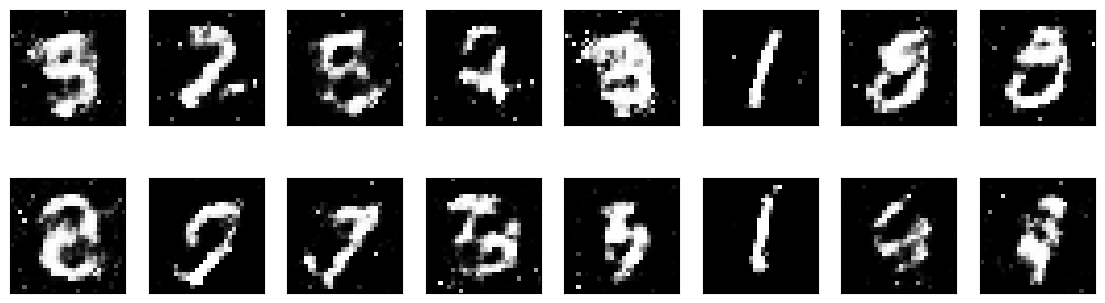

2024-01-01 09:56:42 | Epoch [146/150] | Batch 0/469 | d_loss: 1.1227 | g_loss: 1.3693
2024-01-01 09:56:43 | Epoch [146/150] | Batch 100/469 | d_loss: 1.1354 | g_loss: 1.3560
2024-01-01 09:56:44 | Epoch [146/150] | Batch 200/469 | d_loss: 1.1277 | g_loss: 1.5331
2024-01-01 09:56:46 | Epoch [146/150] | Batch 300/469 | d_loss: 1.2161 | g_loss: 1.1171
2024-01-01 09:56:47 | Epoch [146/150] | Batch 400/469 | d_loss: 1.1828 | g_loss: 1.1873


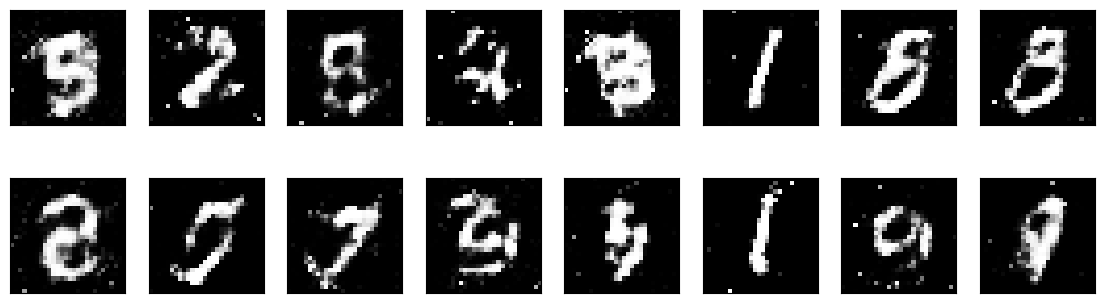

2024-01-01 09:56:51 | Epoch [147/150] | Batch 0/469 | d_loss: 1.1342 | g_loss: 1.1974
2024-01-01 09:56:52 | Epoch [147/150] | Batch 100/469 | d_loss: 1.2016 | g_loss: 1.1466
2024-01-01 09:56:53 | Epoch [147/150] | Batch 200/469 | d_loss: 1.1360 | g_loss: 1.2314
2024-01-01 09:56:55 | Epoch [147/150] | Batch 300/469 | d_loss: 1.1686 | g_loss: 1.1612
2024-01-01 09:56:56 | Epoch [147/150] | Batch 400/469 | d_loss: 1.1817 | g_loss: 1.2012


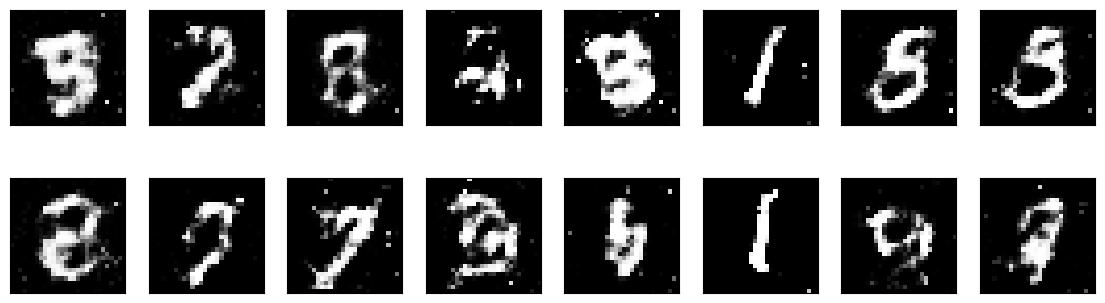

2024-01-01 09:57:00 | Epoch [148/150] | Batch 0/469 | d_loss: 1.1842 | g_loss: 1.1943
2024-01-01 09:57:01 | Epoch [148/150] | Batch 100/469 | d_loss: 1.1671 | g_loss: 1.2464
2024-01-01 09:57:03 | Epoch [148/150] | Batch 200/469 | d_loss: 1.2456 | g_loss: 1.0771
2024-01-01 09:57:04 | Epoch [148/150] | Batch 300/469 | d_loss: 1.2687 | g_loss: 1.2525
2024-01-01 09:57:05 | Epoch [148/150] | Batch 400/469 | d_loss: 1.1601 | g_loss: 1.2807


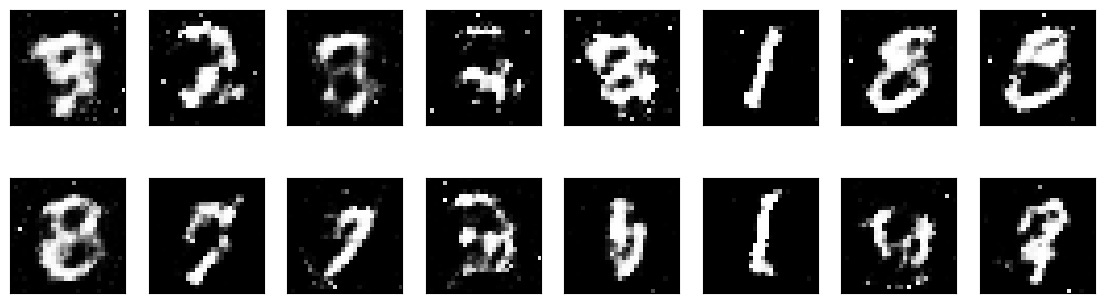

2024-01-01 09:57:09 | Epoch [149/150] | Batch 0/469 | d_loss: 1.1807 | g_loss: 1.3054
2024-01-01 09:57:11 | Epoch [149/150] | Batch 100/469 | d_loss: 1.2881 | g_loss: 1.1908
2024-01-01 09:57:12 | Epoch [149/150] | Batch 200/469 | d_loss: 1.1211 | g_loss: 1.0704
2024-01-01 09:57:13 | Epoch [149/150] | Batch 300/469 | d_loss: 1.2319 | g_loss: 1.2974
2024-01-01 09:57:15 | Epoch [149/150] | Batch 400/469 | d_loss: 1.1850 | g_loss: 1.0532


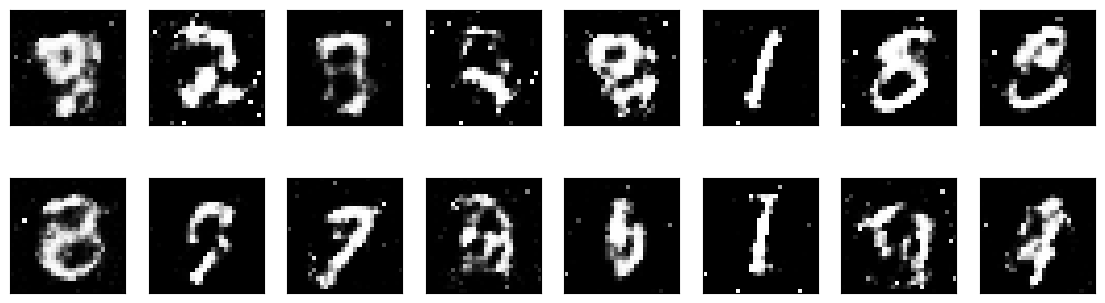

2024-01-01 09:57:18 | Epoch [150/150] | Batch 0/469 | d_loss: 1.2576 | g_loss: 1.1631
2024-01-01 09:57:20 | Epoch [150/150] | Batch 100/469 | d_loss: 1.2289 | g_loss: 1.1439
2024-01-01 09:57:21 | Epoch [150/150] | Batch 200/469 | d_loss: 1.1905 | g_loss: 1.1790
2024-01-01 09:57:23 | Epoch [150/150] | Batch 300/469 | d_loss: 1.2193 | g_loss: 1.2060
2024-01-01 09:57:24 | Epoch [150/150] | Batch 400/469 | d_loss: 1.2857 | g_loss: 1.1781


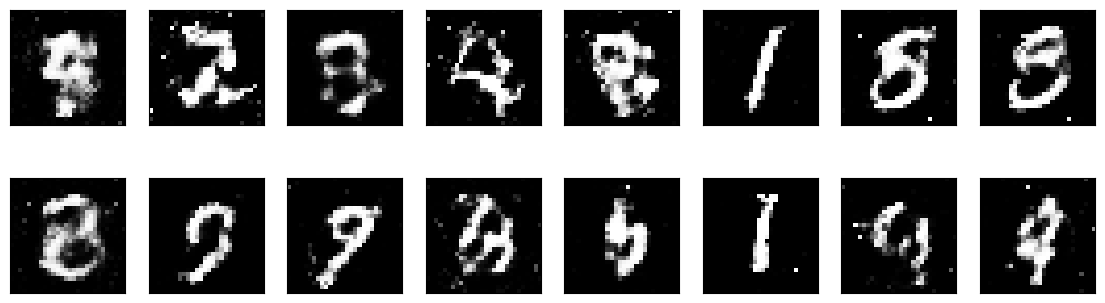

In [27]:
# training hyperparams
num_epochs = 150

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 100

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}')
    
            ## AFTER EACH EPOCH##
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    view_samples(-1, samples)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

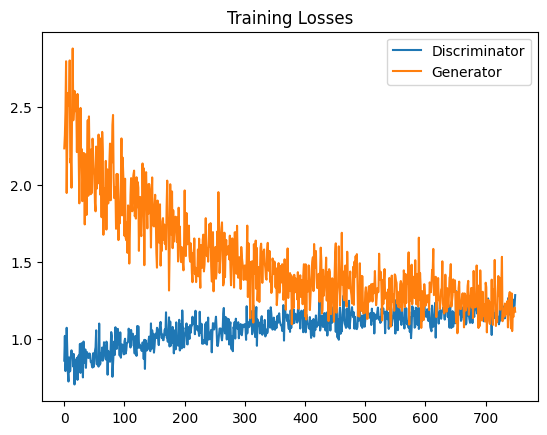

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [29]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

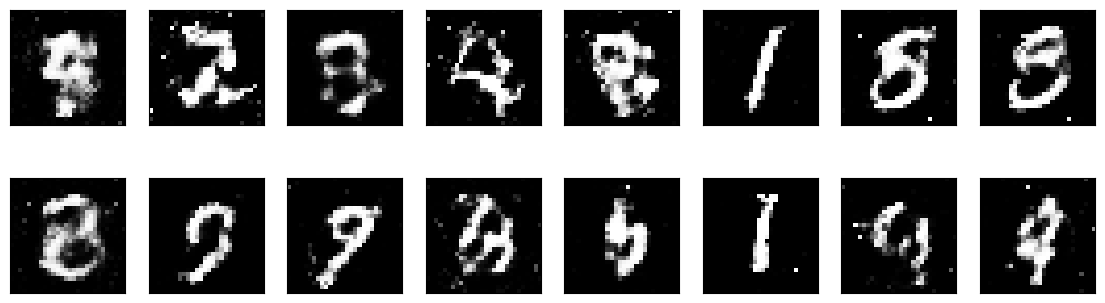

In [30]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

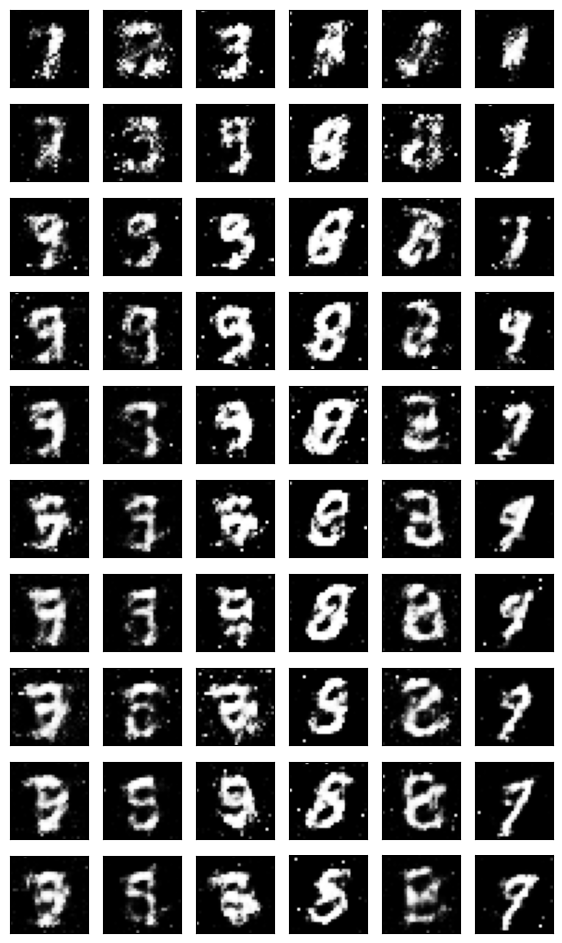

In [31]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

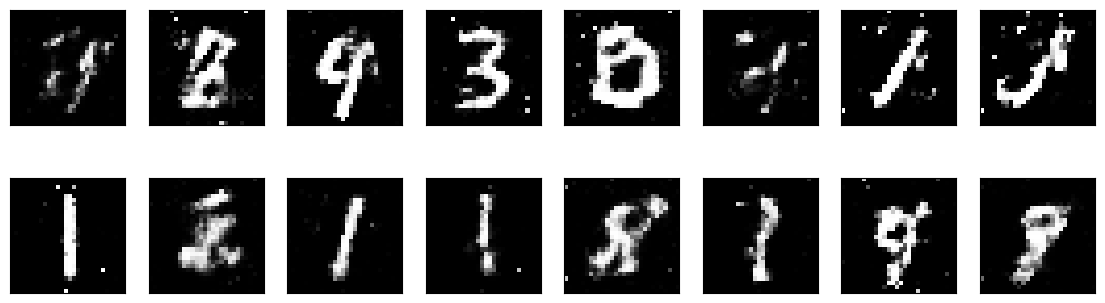

In [32]:
# randomly generated, new latent vectors
sample_size = 16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])